# DATA HANDLING

In [1]:
import netCDF4
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates               
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import skew, kurtosis, pearsonr, norm
import itertools
from matplotlib.colors import Normalize
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from matplotlib.table import Table
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import datetime
from astral import LocationInfo
from astral.sun import sun, daylight

## Dataframes:  LMP, FARM, IMP1F, IMP2F

In [2]:
# setting pandas to print whole dataframes 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# open and read file.netCDF4 and file.xlsx
dati_LPDS = pd.read_excel('/home/andrea/enea_project/data/data_old/20230109_20243108_Lampedusa_lev15.xlsx', header= 6)
df_lmp_dump = pd.DataFrame(dati_LPDS)
df_f_dump = netCDF4.Dataset('/home/andrea/enea_project/data/data_old/farm.nc', 'r')
df_m_dump = netCDF4.Dataset('/home/andrea/enea_project/data/data_old/meteo.nc', 'r')

# build the dataframe of observations only with the information that it is going to be used
df_lmp_dummy = pd.DataFrame({'time': df_lmp_dump['Day_of_Year(Fraction)'][1:], '675nm': df_lmp_dump['AOD_675nm'][1:], '500nm': df_lmp_dump['AOD_500nm'][1:], '440nm': df_lmp_dump['AOD_440nm'][1:], 'pw': df_lmp_dump['Precipitable_Water(cm)'][1:], 'ang_440_870': df_lmp_dump['440-870_Angstrom_Exponent'][1:], 'ang_440_675': df_lmp_dump['440-675_Angstrom_Exponent'][1:], 'ang_500_870': df_lmp_dump['500-870_Angstrom_Exponent'][1:]}) #'sza': df_lmp_dump['info su cui riflettere'][2:], 'oam': df_lmp_dump['info su cui riflettere.1'][2:]

# decoding time for observed data and famr and meteo data. Observation starting time: 2022-12-31 00:00:00. Simulation starting time: 1900-01-01 00:00:00
df_f_dump = netCDF4.Dataset('/home/andrea/enea_project/data/data_old/farm.nc', 'r')
df_m_dump = netCDF4.Dataset('/home/andrea/enea_project/data/data_old/meteo.nc', 'r')

# reopen files
reference_time_f_m = dt.datetime(1900, 1, 1, 0, 0, 0)
reference_time_lmp = dt.datetime(2022, 12, 31, 1, 0, 0) # from UTC to UTC+1
decoded_time_f = [reference_time_f_m + dt.timedelta(hours= float(t)) for t in df_f_dump.variables['time'][:]]
decoded_time_m = [reference_time_f_m + dt.timedelta(hours= float(t)) for t in df_m_dump.variables['time'][:]]

# define error of AOD and ANG
err_aod = 0.021
err_ang = 0.001

err_ang_440_675 = abs(-(1/np.log(440/675))*((err_aod/df_lmp_dummy['440nm'])-(err_aod/df_lmp_dummy['675nm'])))

# convert aod at 500nm to aod at 550nm through Angstrom exponent in the range of 500-870nm using the Beer-Lambert law
aod550 = df_lmp_dummy['500nm']*(550/500)**(-df_lmp_dummy['ang_440_675'])
err_aod550 = (err_aod*(aod550/df_lmp_dummy['500nm']) + err_ang*abs(np.log(500/550))*aod550)

err_aod550_new = (err_aod*(aod550/df_lmp_dummy['500nm']) + err_ang_440_675*abs(np.log(500/550))*aod550)

# multiplied time for 24 to covert the day fraction of the year in hours to obtain the decoded time of observations
df_lmp = pd.DataFrame({'time': df_lmp_dummy['time']*(24), '675nm': df_lmp_dummy['675nm'], '500nm': df_lmp_dummy['500nm'], 'LMP': aod550, 'err_550': err_aod550, '440nm': df_lmp_dummy['440nm'], 'pw': df_lmp_dummy['pw'], 'ang_440_870': df_lmp_dummy['ang_440_870'], 'ang_440_675': df_lmp_dummy['ang_440_675'], 'ang_500_870': df_lmp_dummy['ang_500_870']}) #'sza': df_lmp_dummy['sza'], 'oam': df_lmp_dummy['oam']
number_to_add = df_lmp.iloc[8055, 0]
df_lmp_mod = df_lmp.copy()

# adding hours at the beginning of the new year because the counter was inizialized and the decoded time was giving the same year
df_lmp_mod.loc[df_lmp_mod.index > 8056, 'time'] += number_to_add

df_lmp.reset_index(drop= True, inplace= True)
df_lmp_mod.reset_index(drop= True, inplace= True)
decoded_time_lmp = [reference_time_lmp + dt.timedelta(hours= float(t)) for t in df_lmp_mod['time'][:]]

# convert decoded time into pandas datetime object
dt_f = pd.to_datetime(decoded_time_f)
dt_m = pd.to_datetime(decoded_time_m)
dt_lmp = pd.to_datetime(decoded_time_lmp)

# defining dataframe with time coded in pandas format, using pd.to_datetime
df_lmp_filter = pd.DataFrame({'time': dt_lmp, '675nm': df_lmp_dummy['675nm'], '500nm': df_lmp_dummy['500nm'], 'LMP': aod550, 'err_550': err_aod550, 'err_new': err_aod550_new, '440nm': df_lmp_dummy['440nm'], 'pw': df_lmp_dummy['pw'], 'ang_440_870': df_lmp_dummy['ang_440_870'], 'ang_440_675': df_lmp_dummy['ang_440_675'], 'ang_500_870': df_lmp_dummy['ang_500_870']}) # 'sza': df_lmp_dummy['sza'], 'oam': df_lmp_dummy['oam']

# filter data from -999 values
df_lmp_filter = df_lmp_filter[(df_lmp_filter['LMP'] != -999) & (df_lmp_filter['LMP'] >= 0) & (df_lmp_filter['500nm'] != -999) & (df_lmp_filter['500nm'] >= 0) & (df_lmp_filter['675nm'] != -999) & (df_lmp_filter['675nm'] >= 0) & (df_lmp_filter['440nm'] != -999) & (df_lmp_filter['440nm'] >= 0) & (df_lmp_filter['pw'] != -999) & (df_lmp_filter['pw'] >= 0) & (df_lmp_filter['ang_500_870'] != -999) & (df_lmp_filter['ang_500_870'] >= 0)]
df_lmp_filter.reset_index(drop= True, inplace= True)

rayleigh = 0.0729 # in FARM
# now we create FARM and METEO dataframes with varibles of interest
df_m = pd.DataFrame({'time': dt_m, 'REL': df_m_dump.variables['REL'][:], 'HMIX': df_m_dump.variables['HMIX'][:]})
df_f = pd.DataFrame({'time': dt_f, 'AOD': df_f_dump['AOD'][:], 'FARM': (df_f_dump['AOD'][:]-rayleigh)})
#'ALB': df_m_dump.variables['ALBEDO'][:],
#'TCC': df_m_dump.variables['TCC'][:]/(10),
#'PREC': df_m_dump.variables['PREC'][:],

In [3]:
# Convert start_time and end_time to datetime objects
start_time = pd.to_datetime('2023-09-01 05:39:43')
end_time = pd.to_datetime('2024-08-31 16:51:40')

# Filter data within the time range using .loc[]
df_lampedusa_f = df_lmp_filter.loc[(df_lmp_filter['time'] >= start_time) & (df_lmp_filter['time'] <= end_time)]
df_farm_f = df_f.loc[(df_f['time'] >= start_time) & (df_f['time'] <= end_time)]
df_meteo_f = df_m.loc[(df_m['time'] >= start_time) & (df_m['time'] <= end_time)]

# Print the filtered DataFrames to verify
print(df_lampedusa_f.head())
print(df_farm_f)
#print(df_meteo_f.head())

                        time     675nm     500nm       LMP   err_550  \
0 2023-09-01 06:43:02.035200  0.122557  0.184850  0.162841  0.018515   
1 2023-09-01 06:46:43.996800  0.118493  0.175877  0.155727  0.018609   
2 2023-09-01 06:49:25.996800  0.115598  0.171603  0.151973  0.018612   
3 2023-09-01 06:52:44.025600  0.116838  0.171642  0.152468  0.018669   
4 2023-09-01 06:55:43.996800  0.115153  0.170407  0.151077  0.018632   

    err_new     440nm        pw  ang_440_870  ang_440_675  ang_500_870  
0  0.021177  0.215317  2.313476     1.318223     1.330054     1.333904  
1  0.021162  0.203495  2.318539     1.260390     1.276695     1.274494  
2  0.021162  0.198299  2.337520     1.258196     1.274595     1.273372  
3  0.021152  0.197785  2.367673     1.225561     1.242844     1.239075  
4  0.021159  0.196564  2.309194     1.243437     1.263231     1.257889  
                    time       AOD      FARM
5    2023-09-01 06:00:00  0.103744  0.030844
6    2023-09-01 07:00:00  0.104226  0.0

## Filtering events

In [4]:
df_measeure = df_lmp_filter.copy()

df_measeure['year'] = df_measeure['time'].dt.year
df_measeure['month'] = df_measeure['time'].dt.month
df_measeure['day'] = df_measeure['time'].dt.day
df_measeure['h'] = df_measeure['time'].dt.hour
df_measeure['m'] = df_measeure['time'].dt.minute
df_measeure['s'] = df_measeure['time'].dt.second

#print(df_measeure)

columns_mean = ['675nm', '500nm', 'LMP', 'err_550', 'err_new', '440nm', 'pw', 'ang_440_870', 'ang_440_675', 'ang_500_870']
filter_on_hourly_values= 6

hourly_count = df_measeure.groupby(['year', 'month', 'day', 'h']).size().reset_index(name= 'n')
filt_h = hourly_count[hourly_count['n'] >= filter_on_hourly_values]

filt_df = pd.merge(df_measeure, filt_h, on=['year', 'month', 'day', 'h'], how= 'right')

print(hourly_count)

      year  month  day   h   n
0     2023      9    1   6   7
1     2023      9    1   7  14
2     2023      9    1   8  12
3     2023      9    1   9  14
4     2023      9    1  10  17
5     2023      9    1  11  18
6     2023      9    1  12  18
7     2023      9    1  13  18
8     2023      9    1  14  15
9     2023      9    1  15  10
10    2023      9    1  16  15
11    2023      9    1  17  14
12    2023      9    2   6  12
13    2023      9    2   7  14
14    2023      9    2   8  12
15    2023      9    2   9  14
16    2023      9    2  10  17
17    2023      9    2  11   7
18    2023      9    2  12   8
19    2023      9    2  13  13
20    2023      9    2  14   2
21    2023      9    2  15   2
22    2023      9    2  16  16
23    2023      9    3   6   1
24    2023      9    3   7   2
25    2023      9    3   9   5
26    2023      9    3  10  10
27    2023      9    3  11   8
28    2023      9    3  12  15
29    2023      9    3  13  18
30    2023      9    3  14  11
31    20

### Mean at 6 corresponds to the average between 5 and 6. Error calculation and propagation.

### AOD and ANG error propagation

In [5]:
# Make copies of the DataFrames
df_lmp_offset = filt_df.copy()
df_f_offset = df_farm_f.copy()
df_m_offset = df_meteo_f.copy()

# dataframe of errors
df_obs = pd.DataFrame({
    'time': df_lmp_offset['time'],
    'LMP': df_lmp_offset['LMP']
    })
df_error = pd.DataFrame({
    'time': df_lmp_offset['time'],
    'err_obs': df_lmp_offset['err_550'], # errori propagazione associati alle misure al minuto
    'err_new': df_lmp_offset['err_new']
    })

df_error['time'] += pd.Timedelta(hours= 1)
df_obs['time'] += pd.Timedelta(hours= 1)

# Offset the 'time' column in df_lmp_offset by 1 hour
df_lmp_offset['time'] += pd.Timedelta(hours=1)

# Resample df_lmp_offset to hourly means and drop NaN values
df_lmp_re = df_lmp_offset.resample('h', on= 'time').mean().dropna()
df_err_mean = df_obs.resample('h', on= 'time').mean().dropna()
df_err_var = df_obs.resample('h', on= 'time').var().dropna()
df_err_std = df_obs.resample('h', on= 'time').std(ddof=1).dropna()

df_err_mean_d = df_obs.resample('D', on= 'time').mean().dropna()
df_err_var_d = df_obs.resample('D', on= 'time').var().dropna()
df_err_std_d = df_obs.resample('D', on= 'time').std(ddof=1).dropna()

df_error_count = df_error.groupby(pd.Grouper(key= 'time', freq= 'h')).size().dropna()
df_ErrCount = pd.DataFrame({'time': df_error_count.index.to_numpy(), 'n_values': df_error_count})
df_ErrCount.reset_index(inplace = True, drop= True)

df_err_h_mean = df_error.groupby(pd.Grouper(key= 'time', freq= 'h'))[['err_obs', 'err_new']].apply(
    lambda x: pd.Series({
        'err_mean': np.mean(x['err_obs']), 
        'err_mean_new': np.mean(x['err_new'])
    })
    ).dropna()
df_ErrMean = pd.DataFrame({
    'time': df_err_h_mean.index.to_numpy(),
    'err_mean': df_err_h_mean['err_mean'],
    'err_mean_new': df_err_h_mean['err_mean_new']})
df_ErrMean.reset_index(inplace = True, drop = True)

df_error_count_D = df_error.groupby(pd.Grouper(key= 'time', freq= 'D')).size().dropna()
df_ErrCountDay = pd.DataFrame({'time': df_error_count_D.index.to_numpy(), 'n_values': df_error_count_D})
df_ErrCountDay.reset_index(inplace = True, drop= True)

df_err_h_mean_D = df_error.groupby(pd.Grouper(key= 'time', freq= 'D'))[['err_obs', 'err_new']].apply(
    lambda x: pd.Series({
        'err_mean': np.mean(x['err_obs']**2),#/len(x['err_obs']),
        'err_mean_new': np.mean(x['err_new']**2)#/len(x['err_new'])
        })
        ).dropna()
df_ErrMeanDay = pd.DataFrame({
    'time': df_err_h_mean_D.index.to_numpy(),
    'err_mean': df_err_h_mean_D['err_mean'],
    'err_mean_new': df_err_h_mean_D['err_mean_new']})
df_ErrMeanDay.reset_index(inplace = True, drop = True)

df_ErrCount_eq = pd.merge(df_ErrMean, df_ErrCount, on= 'time', how= 'inner')
df_ErrStd = pd.DataFrame({
    'time': df_ErrCount_eq['time'],
    'std': (df_ErrMean['err_mean']/(np.sqrt(df_ErrCount_eq['n_values']))),
    'std_new': (df_ErrMean['err_mean_new']/(np.sqrt(df_ErrCount_eq['n_values'])))})
df_ErrStd.reset_index(inplace = True, drop = True)

df_ErrCount_eq_D = pd.merge(df_ErrMeanDay, df_ErrCountDay, on= 'time', how= 'inner')
df_ErrStdDay = pd.DataFrame({
    'time': df_ErrCount_eq_D['time'],
    'std': (df_ErrMeanDay['err_mean']/(np.sqrt(df_ErrCount_eq_D['n_values']))),
    'std_new': (df_ErrMeanDay['err_mean_new']/(np.sqrt(df_ErrCount_eq_D['n_values'])))})
df_ErrStdDay.reset_index(inplace = True, drop = True)

df_ErrStd_camp = pd.DataFrame({'time': df_err_std.index.to_numpy(), 'std_camp': df_err_std['LMP']})
df_ErrStd_camp.reset_index(inplace = True, drop = True)

df_ErrStd_camp_D = pd.DataFrame({'time': df_err_std_d.index.to_numpy(), 'std_camp': df_err_std_d['LMP']})
df_ErrStd_camp_D.reset_index(inplace = True, drop = True)

df_ErrSum_h = np.sqrt((df_ErrStd_camp['std_camp']**2) + (df_ErrStd['std']**2))
df_ErrSum_24h= np.sqrt((df_ErrStd_camp_D['std_camp']**2) + (df_ErrStdDay['std']**2))
df_ErrSum_h_new = np.sqrt((df_ErrStd_camp['std_camp']**2) + (df_ErrStd['std_new']**2))
df_ErrSum_24h_new= np.sqrt((df_ErrStd_camp_D['std_camp']**2) + (df_ErrStdDay['std_new']**2))

df_ErrSum_H = pd.DataFrame({'time': df_ErrStd['time'], 'err_1h': df_ErrSum_h, 'err_1h_new': df_ErrSum_h_new})
df_ErrSum_H.reset_index(inplace= True, drop= True)
df_ErrSum_H.dropna(inplace= True)
df_ErrSum_24H = pd.DataFrame({'time': df_ErrStdDay['time'], 'err_day': df_ErrSum_24h, 'err_day_new': df_ErrSum_24h_new})
df_ErrSum_24H.reset_index(inplace= True, drop= True)

# Merge DataFrames on 'time' to create a unified DataFrame with common timestamps
df_homo = (df_m_offset.merge(df_f_offset, on= 'time', how='inner').merge(df_lmp_re, on= 'time', how='inner'))

def resample_data(df, period):
    df_resampled = df.resample(period, on= 'time').mean()
    df_resampled.dropna(inplace= True)
    df_resampled.reset_index(inplace= True)
    return df_resampled

# Create a dictionary with resampled data for 1h, 3h, 6h, and 24h intervals
data = {
    'data1h': pd.merge(resample_data(df_homo, '1h'), df_ErrSum_H, on= 'time', how= 'inner'),
    'data3h': resample_data(df_homo, '3h'),
    'data6h': resample_data(df_homo, '6h'),
    'data24h': pd.merge(resample_data(df_homo, 'D'), df_ErrSum_24H, on= 'time', how= 'inner')
}
data['data1h'].drop(columns=['n'], inplace= True)
data['data3h'].drop(columns=['n'], inplace= True)
data['data6h'].drop(columns=['n'], inplace= True)
data['data24h'].drop(columns=['n'], inplace= True)

print(data['data1h'].head())

                 time       REL        HMIX       AOD      FARM     675nm  \
0 2023-09-01 07:00:00  5.035646  426.046456  0.104226  0.031326  0.116774   
1 2023-09-01 08:00:00  5.035646  427.021901  0.104794  0.031894  0.099983   
2 2023-09-01 09:00:00  5.035646  407.224369  0.102972  0.030072  0.101001   
3 2023-09-01 10:00:00  5.035646  411.440817  0.101120  0.028220  0.111492   
4 2023-09-01 11:00:00  5.035646  397.773840  0.100012  0.027112  0.104780   

      500nm       LMP   err_550   err_new     440nm        pw  ang_440_870  \
0  0.173007  0.153278  0.018621  0.021160  0.199991  2.337000     1.250941   
1  0.143079  0.128180  0.018833  0.021129  0.162904  2.247174     1.111925   
2  0.142875  0.128514  0.018904  0.021120  0.161577  2.169194     1.061298   
3  0.161215  0.144033  0.018776  0.021139  0.183798  2.165095     1.115527   
4  0.152251  0.135894  0.018756  0.021145  0.173375  1.976550     1.131055   

   ang_440_675  ang_500_870    year  month  day     h          m    

In [6]:
# plt.figure(figsize=(12, 8))
# marzo = data['data3h'][(data['data3h']['time'].dt.month == 3) & (data['data3h']['time'].dt.year == 2024)]
# plt.scatter(marzo['time'], marzo['LMP'], s=5)
# plt.grid(True)
# punto = marzo[marzo['time'].dt.day == 26]
# print(punto)

### Filtering hours per day, taking the maximum in summer and the maximun in winter. Then it is necessary to do a fit and take the 75% or 60% of data

In [7]:
day_count_dump = data['data1h'].copy()
#print(day_count_dump.columns)

day_count_dump['year_1'] = day_count_dump['time'].dt.year 
day_count_dump['month_1'] = day_count_dump['time'].dt.month
day_count_dump['day_1'] = day_count_dump['time'].dt.day
day_count_dump['hour_1'] = day_count_dump['time'].dt.hour

# #print(day_count_dump)

day_count = day_count_dump.groupby(['year_1', 'month_1', 'day_1']).size().reset_index(name = 'hours_in_day')

# X_h = pd.DataFrame()

# for i in range(1, 13):
#     month_data = day_count[day_count['month_1'] == i].max()
#     X_h[f'month_{i}'] = month_data

# X_h = X_h.T
# X = []
# Y = []

# for i in range(1, 13): 
#     X.append(X_h.loc[f'month_{i}', 'month_1'])
#     Y.append(X_h.loc[f'month_{i}', 'hours_in_day'])

# X = np.array(X).reshape(-1, 1)
# Y = np.array(Y).reshape(-1, 1)
# print(X)

# reg_h = linear_model.LinearRegression(fit_intercept= True).fit(X, Y)
# print(f"Coeff_imp1:{reg_h.coef_}\nIntercept_imp1:{reg_h.intercept_}")

# Y_pred = reg_h.predict(X)

# plt.figure(figsize=(12, 8))

# for i in range(1, 13):
#     plt.scatter(X_h.loc[f'month_{i}', 'month_1'], X_h.loc[f'month_{i}', 'hours_in_day'], label=f'Month {i}')
# plt.title('Scatter Plot of Maximum Hours in Each Day per Month')
# plt.xlabel('Day of the Month')
# plt.ylabel('Hours in Day')
# plt.legend()
# plt.grid()
# plt.show()

# plt.figure(figsize=(12, 8))

# # Scatter plot dei dati originali
# plt.scatter(X, Y, color='blue', label='Data')

# # Linea di regressione
# plt.plot(X, Y_pred, color='red', label='Regression Line')
# plt.title('Plot of Maximum Hours in Each Day per Month')
# plt.xlabel('Month of the Year')
# plt.ylabel('Maximum Hours in Day')
# plt.legend()
# plt.grid()
# plt.show()

# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)

# # Regressione lineare con caratteristiche polinomiali
# reg_h2 = LinearRegression(fit_intercept=True).fit(X_poly, Y)

# # Coefficienti e intercetta
# print(f"Coefficients: {reg_h2.coef_}\nIntercept: {reg_h2.intercept_}")

# # Predire i valori
# Y_pred2 = reg_h2.predict(X_poly)

# # Creazione del grafico
# plt.figure(figsize=(12, 8))

# # Scatter plot dei dati originali
# plt.scatter(X, Y, color='blue', label='Data')

# # Linea di regressione
# plt.plot(X, Y_pred2, color='red', label='Second-Order Fit')

# # Configurazioni grafiche
# # plt.title('Plot of Maximum Hours in Each Day per Month with Second-Order Fit')
# # plt.xlabel('Month of the Year')
# # plt.ylabel('Maximum Hours in Day')
# # plt.legend()
# # plt.grid()
# # plt.show()

## Daylight during the year

In [8]:
LMPsite = LocationInfo(name="Lampedusa", region="Italy", latitude=35.52, longitude=12.63)
date_range = pd.date_range(start= "2023-09-01", end= "2024-08-31", freq= 'D')

daylight_durations = []

# Loop through each date and calculate daylight duration
for single_date in date_range:
    specific_date = single_date.date()
    sun_hours = sun(LMPsite.observer, date = specific_date)
    daylight_duration = sun_hours['sunset'] - sun_hours['sunrise']
    daylight_durations.append({
        "time": pd.to_datetime(specific_date),
        "daylight_duration": int(daylight_duration.total_seconds() // 3600)
    })

# Convert results to a Pandas DataFrame for easier analysis
daylight_df = pd.DataFrame(daylight_durations)

# Display the first few rows
print(daylight_df)

          time  daylight_duration
0   2023-09-01                 12
1   2023-09-02                 12
2   2023-09-03                 12
3   2023-09-04                 12
4   2023-09-05                 12
5   2023-09-06                 12
6   2023-09-07                 12
7   2023-09-08                 12
8   2023-09-09                 12
9   2023-09-10                 12
10  2023-09-11                 12
11  2023-09-12                 12
12  2023-09-13                 12
13  2023-09-14                 12
14  2023-09-15                 12
15  2023-09-16                 12
16  2023-09-17                 12
17  2023-09-18                 12
18  2023-09-19                 12
19  2023-09-20                 12
20  2023-09-21                 12
21  2023-09-22                 12
22  2023-09-23                 12
23  2023-09-24                 12
24  2023-09-25                 12
25  2023-09-26                 12
26  2023-09-27                 11
27  2023-09-28                 11
28  2023-09-29

## Filtering hours per day based on the 60% of the daylight 

In [9]:
day_count_dump_2 = data['data24h'].copy()
df_filter_on_days = pd.concat([day_count_dump_2, day_count], axis = 1)

def filter_day(xMonth):
    yDay = (-0.2)*xMonth**2 + 2.3*xMonth + 5.6
    soglia = 0.6 * yDay
    return soglia

df_days_filtered = pd.DataFrame()

for i in range(1, 13):
    filterData = df_filter_on_days[(df_filter_on_days['time'].dt.month == i) & (df_filter_on_days['hours_in_day'] >= filter_day(i))]
    df_days_filtered = pd.concat([df_days_filtered, filterData], ignore_index=True)

df_days_filtered.sort_values(by='time', inplace=True)
df_days_filtered.reset_index(drop=True, inplace=True)

#print(df_days_filtered)

#### FILTER WITH ASTRAL HOURS

df_days_filtered_astral = pd.merge(df_filter_on_days, daylight_df, on= 'time', how= 'left')
#print(df_days_filtered_astral.columns)

df_daylight_50 = df_days_filtered_astral[df_days_filtered_astral['hours_in_day'] >= 0.5*df_days_filtered_astral['daylight_duration']].reset_index(drop= True)

DataDayFiltered = {
    'Fit2Ord': df_days_filtered,
    'FiltAstral60': df_daylight_50 
}

print(df_daylight_50.columns)

Index(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',
       'err_550', 'err_new', '440nm', 'pw', 'ang_440_870', 'ang_440_675',
       'ang_500_870', 'year', 'month', 'day', 'h', 'm', 's', 'err_day',
       'err_day_new', 'year_1', 'month_1', 'day_1', 'hours_in_day',
       'daylight_duration'],
      dtype='object')


### Season: 
- Winter: December-Jaunary-February (DJF) 12-1-2
- Spring: March-April-May (MAM) 3-4-5
- Summer: June-July-August (JJA) 6-7-8
- Fall: September-October-November (SON) 9-10-11

In [10]:
# Individual months
december23_1h = data['data1h'][(data['data1h']['time'].dt.year == 2023) & (data['data1h']['time'].dt.month == 12)]
november23_1h = data['data1h'][(data['data1h']['time'].dt.year == 2023) & (data['data1h']['time'].dt.month == 11)]
october23_1h = data['data1h'][(data['data1h']['time'].dt.year == 2023) & (data['data1h']['time'].dt.month == 10)]
september23_1h = data['data1h'][(data['data1h']['time'].dt.year == 2023) & (data['data1h']['time'].dt.month == 9)]
january24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 1)]
february24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 2)]
march24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 3)]
april24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 4)]
may24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 5)]
june24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 6)]
july24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 7)]
august24_1h = data['data1h'][(data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month == 8)]

# Seasons
fall_1h = data['data1h'][
    (data['data1h']['time'].dt.year == 2023) & 
    (data['data1h']['time'].dt.month >= 9) & 
    (data['data1h']['time'].dt.month <= 11)
]

# Correcting the winter season logic to include December 2023 and January/February 2024
winter_1h = data['data1h'][
    ((data['data1h']['time'].dt.year == 2023) & (data['data1h']['time'].dt.month == 12)) |
    ((data['data1h']['time'].dt.year == 2024) & (data['data1h']['time'].dt.month <= 2))
]

spring_1h = data['data1h'][
    (data['data1h']['time'].dt.year == 2024) & 
    (data['data1h']['time'].dt.month >= 3) & 
    (data['data1h']['time'].dt.month <= 5)
]

summer_1h = data['data1h'][
    (data['data1h']['time'].dt.year == 2024) & 
    (data['data1h']['time'].dt.month >= 6) & 
    (data['data1h']['time'].dt.month <= 8)
]

print(winter_1h.columns)

Index(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',
       'err_550', 'err_new', '440nm', 'pw', 'ang_440_870', 'ang_440_675',
       'ang_500_870', 'year', 'month', 'day', 'h', 'm', 's', 'err_1h',
       'err_1h_new'],
      dtype='object')


# Implementation of Kim's formula for Lampedusa site
## First IMPROVE:
Rayleigh scattering assumed to be costant ($10 Mm^{-1}$), absorption by gases is considered zero. Concentrations in $[\mu g\cdot  m^{-3}]$ and dry mass extinction efficiency are in $(m^{2}\cdot \mu g^{-1})$ and $f(RH)$ is **unitless**.
$$
b_{ext}\approx 0.003\times f(RH)[Ammonium Sulfate((NH_{4})_{2}SO_{4})] +\\
+0.003\times f(RH)[Ammonium Nitrate(NH_{4}NO_{3})] + 0.004\times [Organic Mass]\\
+0.01\times [Elemental Carbon] + 0.001\times [Fine Soil]\\
+0.0006\times [Coarse Mass] + 0.001 \times RayleighScattering
$$
## Second IMPROVE
- Sea salt has been added;
- Site-specific Rayleigh scattering; 
- OC ratio from 1.4 to 1.8; 
- Associated hygroscopies for *small mode, large mode, sea salt*
$$
b_{ext}\approx 2.2f_{S}(RH)[Small Ammonium Sulfate] + 4.8f_{L}(RH)[Large Ammonium Sulfate]\\
+2.4f_{S}(RH)[Small Ammonium Nitrate] + 5.1f_{L}(RH)[Large Ammonium Nitrate]\\
+2.8[Small Organic Mass] + 6.1[Large Organic Mass]\\
+10[Elemental Carbon] + 1[Fine Soil] + 1.7f_{SS}(RH)[Sea Salt]\\
+0.6 × [Coarse Mass] + Rayleigh Scattering(Site Specific) + 0.33[NO2 (ppb)]
$$

### $f(RH)$:
$$
\begin{align}
f(RH) = b_{0}+b_{1}\left(\frac{1}{1-RH}\right)+b_{2}\left(\frac{1}{1-RH}\right)^{2}\\
f(RH) = \exp{\left(-1-\frac{0.6}{RH-1.2}-\frac{0.75}{RH-1.5}\right)}
\end{align}
$$

## AODs estimated: 

$$
    AOD = \sum_{i=1}^{N}\left(b_{ext}\right)_{i}\Delta Z_{i}
$$

- $N$: number of vertical layers in the numerical model; 
- $\Delta Z_{i}$: is the thickness of each layer;
  
### centro-cella
20 65 125 210 325 480 690 975 1360 1880 2580 3525 4805 6290

### facce
0 40 90 160 260 390 570 810 1140 1580 2180 2980 4070 5540 7040

### spessore
40 50 70 100 130 180 240 330 440 600 800 1090 1470 1500

## IMP1F

In [11]:
from func_RH import f_rh_farm

z = df_f_dump['z'][:]
dz_C = np.diff(z)
dz = [40, 50, 70, 100, 130, 180, 240, 330, 440, 600, 800, 1090, 1470, 1500]
N = len(dz)
df_dz = pd.DataFrame({'dz': dz})
df_rh = pd.DataFrame({'time': dt_m})
df_species = pd.DataFrame({'time' : dt_f})
df_meteo = pd.DataFrame({'time': dt_m})

species = ['c_A25I', 'c_A25J', 'c_ACORS', 'c_AECI', 'c_AECJ', 'c_ANH4I', 'c_ANH4J', 'c_ANO3I', 'c_ANO3J', 'c_AORAI', 'c_AORAJ', 'c_AORBI', 'c_AORBJ', 
           'c_AORPAI', 'c_AORPAJ', 'c_ASEAS', 'c_ASEASJ', 'c_ASO4I', 'c_ASO4J', 'c_ASOIL', 'c_ASOILJ', 'c_PM10', 'c_PM25', 'c_NO2']

species_test = ['c_A25I', 'c_A25J', 'c_ACORS', 'c_AECI', 'c_AECJ', 'c_ANH4I', 'c_ANH4J', 'c_ANO3I', 'c_ANO3J', 'c_AORAI', 'c_AORAJ', 'c_AORBI', 'c_AORBJ', 
           'c_AORPAI', 'c_AORPAJ', 'c_ASEAS', 'c_ASEASJ', 'c_ASO4I', 'c_ASO4J', 'c_ASOIL', 'c_PM10', 'c_PM25', 'c_NO2']

meteos = ['P', 'T']

# extracting data all at once
rh_data = df_m_dump.variables['RH'][:, :N]/100
species_data = {species_name: df_f_dump.variables[species_name][:, :N] for species_name in species}
meteo_data = {meteo_var: df_m_dump.variables[meteo_var][:, :N] for meteo_var in meteos}

#creating dataframe with time column
df_rh = pd.concat([df_rh, pd.DataFrame(rh_data, columns=[f'layer_{i}' for i in range(N)])], axis= 1)

for species_name, species_array in species_data.items():
    species_columns = {f'layer_{i}_species_{species_name}': species_array[:, i] for i in range(N)}
    df_species = pd.concat([df_species, pd.DataFrame(species_columns)], axis= 1)

for meteo_var, meteo_array in meteo_data.items():
    meteo_colums = {f'layer_{i}_{meteo_var}': meteo_array[:, i] for i in range(N)}
    df_meteo = pd.concat([df_meteo, pd.DataFrame(meteo_colums)], axis= 1)

#for species_name_test in species_test:
#    for i in range(N): 
#        df_species[f'layer_{i}_species_{species_name_test}'] = 0.0

df_FarmRhSpecies_merged = pd.merge(df_species, df_rh, on= 'time', how= 'inner')

df_frh_farm = {}

# f(RH) function, Kim function is the second one used in Kim's article, the first one will be not used because its divergence for humidity high values
for k in range(N):
    column= f'layer_{k}'
    df_frh_farm[column] = f_rh_farm.g_h_c(df_FarmRhSpecies_merged[f'layer_{k}'])

# defining costants for the extinction coeffiencient 
RayS_1 = 10e-6
RayS_2 = 12e-6
A = 3e-6
B = 4e-6
C = 1e-6
E = 1e-5
C_fit_ODR = 1.3346e-6 
D_fit_ODR = 0.801e-6
C_fit_NS = 1.3110e-6
D_fit_NS = 0.787e-6
D = 6e-7

aitken = ['c_A25I', 'c_AECI', 'c_ANH4I', 'c_ANO3I', 'c_AORAI', 'c_AORBI', 'c_AORPAI', 'c_ASO4I']
accumulation = ['c_A25J', 'c_AECJ', 'c_ANH4J', 'c_ANO3J', 'c_AORAJ', 'c_AORBJ', 'c_AORPAJ', 'c_ASEASJ', 'c_ASO4J', 'c_ASOILJ']
coarse = ['c_ACORS', 'c_ASEAS', 'c_ASOIL']

df_bext_kim_I = {}
df_bext_kim_J = {}
df_bext_farm_I = {}
df_bext_farm_J = {}
df_bext_farm_J_ODR = {}
df_bext_farm_J_NS = {}

# coarse mode is indipendent from f(RH)
df_bext_C = {}
df_bext_C_ODR = {}
df_bext_C_NS = {}
 
for l in range(N):
    column_1= f'layer_{l}'

    bext_farm_1I = A * df_frh_farm[f'layer_{l}'] * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4I'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4I']) +\
                B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAI'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBI']) +\
                C * df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECI']
    df_bext_farm_I[column_1] = bext_farm_1I

    bext_farm_1J = A * df_frh_farm[f'layer_{l}'] * ( df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J']) + B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) + \
                C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ'])
    df_bext_farm_J[column_1] = bext_farm_1J

    bext_farm_1J_ODR = A * df_frh_farm[f'layer_{l}'] * ( df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J']) + B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) + \
                C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ']) +\
                      (C_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ']))
    df_bext_farm_J_ODR[column_1] = bext_farm_1J_ODR

    bext_farm_1J_NS = A * df_frh_farm[f'layer_{l}'] * ( df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J']) + B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) + \
                C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ']) +\
                      (C_fit_NS * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ']))
    df_bext_farm_J_NS[column_1] = bext_farm_1J_NS

    bext_1C = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])
    df_bext_C[column_1] = bext_1C

    bext_1C_ODR = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS']) + D_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])
    df_bext_C_ODR[column_1] = bext_1C_ODR

    bext_1C_NS = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS']) + D_fit_NS * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])
    df_bext_C_NS[column_1] = bext_1C_NS

#aitken
df_bext_farm_I = pd.DataFrame(df_bext_farm_I)
df_bext_farm_I = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_farm_I], axis= 1)
#accumulation
df_bext_farm_J = pd.DataFrame(df_bext_farm_J)
df_bext_farm_J = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_farm_J], axis= 1)
df_bext_farm_J_ODR = pd.DataFrame(df_bext_farm_J_ODR)
df_bext_farm_J_ODR = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_farm_J_ODR], axis= 1)
df_bext_farm_J_NS = pd.DataFrame(df_bext_farm_J_NS)
df_bext_farm_J_NS = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_farm_J_NS], axis= 1)
#coarse
df_bext_C = pd.DataFrame(df_bext_C)
df_bext_C = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_C], axis= 1)
df_bext_C_ODR = pd.DataFrame(df_bext_C_ODR)
df_bext_C_ODR = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_C_ODR], axis= 1)
df_bext_C_NS = pd.DataFrame(df_bext_C_NS)
df_bext_C_NS = pd.concat([df_FarmRhSpecies_merged['time'], df_bext_C_NS], axis= 1)

# AOD IMPROVE first formula with Kim-f(RH) and FARM-f(RH)
aodimp = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
aodimp['IMP1F'] = 0.0
aodimp['IMP1F_ODR'] = 0.0
aodimp['IMP1F_NS'] = 0.0

# Rayleigh scattering calculated with the formual from HansenAndTravis 1974
length = 0.55 # micrometri
P_atm = 1013.25
c_1 = 0.008569
c_2 = 0.0113
c_3 = 0.00013
tau0 = (c_1*(length)**(-4)*(1+c_2*(length)**(-2)+c_3*(length)**(-4)))*10e-6
df_ray = {}
raytot = 0.0
raytot_1 = 0.0
raytot_2 = 0.0

for i in range(N):
    name = f'lay_{i}'
    temp = (tau0*((df_meteo[f'layer_{i}_P'])/P_atm)) 
    df_ray[name] = temp
    tot_2 = df_ray[f'lay_{i}']*dz[i]
    raytot += tot_2

for i in range(N):
    tot = RayS_1 * dz[i]
    tot_1 = RayS_2 * dz[i]
    raytot_1 += tot
    raytot_2 += tot_1
    
for n in range(N): 
    aod_farm_1 = (df_bext_farm_I[f'layer_{n}'] + df_bext_farm_J[f'layer_{n}'] + df_bext_C[f'layer_{n}']) * dz[n:n+1]
    aod_farm_1_ODR = (df_bext_farm_I[f'layer_{n}'] + df_bext_farm_J_ODR[f'layer_{n}'] + df_bext_C_ODR[f'layer_{n}']) * dz[n:n+1]
    aod_farm_1_NS = (df_bext_farm_I[f'layer_{n}'] + df_bext_farm_J_NS[f'layer_{n}'] + df_bext_C_NS[f'layer_{n}']) * dz[n:n+1]
    aodimp['IMP1F_ODR'] += aod_farm_1_ODR
    aodimp['IMP1F_NS'] += aod_farm_1_NS
    aodimp['IMP1F'] += aod_farm_1
#print(df_FarmRhSpecies_merged.columns)

## f(RH): FARM based on tabulated values

In [12]:
from func_RH import f_rh_kim_2
df_frh = {}

for i in range(N):
    column3 = f'layer_{i}'
    frh = f_rh_kim_2.func2(df_FarmRhSpecies_merged['time'], df_FarmRhSpecies_merged, column3)
    df_frh[column3] = frh

## Small Mode and Large Mode: $20\mu g/cm^{3}$ threshold

In [13]:
# Large mode and small mode: IMPROVE 2
df_ASO4_large = {}
df_ASO4_small = {}

df_ANO3_large = {}
df_ANO3_small = {}

df_OrgMas_large = {}
df_OrgMas_small = {}

threshold = 20.0

for j in range(N):
    column_3 = f'layer_{j}'

    value_1 = (1.375) * (df_FarmRhSpecies_merged[f'layer_{j}_species_c_ASO4I'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_ASO4J'])

    value_2 = (1.291) * (df_FarmRhSpecies_merged[f'layer_{j}_species_c_ANO3I'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_ANO3J'])

    value_3 = df_FarmRhSpecies_merged[f'layer_{j}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_A25J'] \
                + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORAI'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORAJ']\
                + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORBI'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORBJ']\
                + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{j}_species_c_AORPAJ']
        
    df_ASO4_large[column_3]= np.where(value_1 <= threshold, (value_1 / threshold) * value_1, value_1)
    df_ASO4_small[column_3] = np.where(value_1 <= threshold, value_1 - (value_1 / threshold) * value_1, 0.0)

    df_ANO3_large[column_3] = np.where(value_2 <= threshold, (value_2 / threshold) * value_2, value_2)
    df_ANO3_small[column_3] = np.where(value_2 <= threshold, value_2 - (value_2 / threshold) * value_2, 0.0)

    df_OrgMas_large[column_3] = np.where(value_3 <= threshold, (value_3 / threshold) * value_3, value_3)
    df_OrgMas_small[column_3] = np.where(value_3 <= threshold, value_3 - (value_3 / threshold) * value_3, 0.0)

df_ASO4_large = pd.DataFrame(df_ASO4_large)
df_ASO4_large = pd.concat([df_FarmRhSpecies_merged['time'], df_ASO4_large], axis= 1)

df_ASO4_small = pd.DataFrame(df_ASO4_small)
df_ASO4_small = pd.concat([df_FarmRhSpecies_merged['time'], df_ASO4_small], axis= 1)

df_ANO3_large = pd.DataFrame(df_ANO3_large)
df_ANO3_large = pd.concat([df_FarmRhSpecies_merged['time'], df_ANO3_large], axis= 1)

df_ANO3_small = pd.DataFrame(df_ANO3_small)
df_ANO3_small = pd.concat([df_FarmRhSpecies_merged['time'], df_ANO3_small], axis= 1)

df_OrgMas_large = pd.DataFrame(df_OrgMas_large)
df_OrgMas_large = pd.concat([df_FarmRhSpecies_merged['time'], df_OrgMas_large], axis= 1)

df_OrgMas_small = pd.DataFrame(df_OrgMas_small)
df_OrgMas_small = pd.concat([df_FarmRhSpecies_merged['time'], df_OrgMas_small], axis= 1)

## IMP2F

In [14]:
aodimp['IMP2F'] = 0.0
aodimp['IMP2F_ODR'] = 0.0
aodimp['IMP2F_NS'] = 0.0

#Costants
Rayleigh = 0.0729
Temp = 298.15
R = 8.314
NO2 = 4.6
A1 = 2.2e-6
A2 = 4.8e-6
A3 = 2.4e-6
A4 = 5.1e-6
A5 = 2.8e-6
A6 = 6.1e-6
B1 = 1.0e-5
C1 = 1.0e-6 
C1_fit_ODR = 1.3512e-6
C3_fit_ODR = 0.811e-6
C1_fit_NS = 1.2804e-6
C3_fit_NS = 0.768e-6
C2 = 1.7e-6
C3 = 6.0e-7
D1 = 3.3e-7

df_bext_imp2 = {}
df_bext_imp2_ODR = {}
df_bext_imp2_NS = {}

for h in range(N): 
    column_2 = f'layer_{h}'

    bext_2 = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) + \
            C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'] +\
                    df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2[column_2] = bext_2
    aod2 = (df_bext_imp2[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F'] += aod2
    
    bext_2_ODR = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) + \
            C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS']) + \
            C3_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2_ODR[column_2] = bext_2_ODR
    aod2_ODR = (df_bext_imp2_ODR[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F_ODR'] += aod2_ODR
    
    bext_2_NS = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1_fit_NS * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) + \
            C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS']) + \
            C3_fit_NS * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2_NS[column_2] = bext_2_NS
    aod2_NS = (df_bext_imp2_NS[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F_NS'] += aod2_NS

df_aodimp = aodimp[(aodimp['time'] >= start_time) & (aodimp['time'] <= end_time)].copy()
df_aodimp.reset_index(drop= True, inplace= True)
print(df_aodimp)

                    time     IMP1F  IMP1F_ODR  IMP1F_NS     IMP2F  IMP2F_ODR  \
0    2023-09-01 06:00:00  0.035486   0.038713  0.038487  0.066765   0.067992   
1    2023-09-01 07:00:00  0.033832   0.036685  0.036486  0.066240   0.067192   
2    2023-09-01 08:00:00  0.034810   0.037648  0.037449  0.067189   0.068093   
3    2023-09-01 09:00:00  0.032660   0.035301  0.035117  0.057942   0.058832   
4    2023-09-01 10:00:00  0.031234   0.033671  0.033501  0.054527   0.055400   
5    2023-09-01 11:00:00  0.029562   0.031875  0.031713  0.051253   0.052158   
6    2023-09-01 12:00:00  0.027408   0.029496  0.029350  0.044402   0.045255   
7    2023-09-01 13:00:00  0.025832   0.027809  0.027671  0.040185   0.041081   
8    2023-09-01 14:00:00  0.026271   0.028178  0.028045  0.039493   0.040327   
9    2023-09-01 15:00:00  0.025897   0.027786  0.027654  0.038554   0.039380   
10   2023-09-01 16:00:00  0.025089   0.026803  0.026683  0.036006   0.036769   
11   2023-09-01 17:00:00  0.024581   0.0

In [15]:
df_IMP = pd.merge(df_homo, df_aodimp, on= 'time', how= 'inner')

df_IMP_1h = df_IMP.resample('1h', on= 'time').mean()
df_IMP_1h.dropna(inplace= True)
df_IMP_1h.reset_index(inplace= True)

df_IMP_3h = df_IMP.resample('3h', on= 'time').mean()
df_IMP_3h.dropna(inplace= True)
df_IMP_3h.reset_index(inplace= True)

df_IMP_6h = df_IMP.resample('6h', on= 'time').mean()
df_IMP_6h.dropna(inplace= True)
df_IMP_6h.reset_index(inplace= True)

df_IMP_24h = df_IMP.resample('24h', on= 'time').mean()
df_IMP_24h.dropna(inplace= True)
df_IMP_24h.reset_index(inplace= True)

# dataframe complete with IMPROVE aod
data_h = {
    'm1': pd.concat([df_IMP_1h, data['data1h']['err_1h']], axis= 1),
    'm3': df_IMP_3h,
    'm6': df_IMP_6h,
    'm24': pd.concat([df_IMP_24h, data['data24h']['err_day_new']], axis= 1)
}

print(data_h['m24'].head())

        time       REL         HMIX       AOD      FARM     675nm     500nm  \
0 2023-09-01  5.035646   391.787967  0.099547  0.026647  0.095119  0.141450   
1 2023-09-02  5.035646   544.440704  0.136878  0.063978  0.103569  0.130753   
2 2023-09-03  5.035646   526.402011  0.174482  0.101582  0.167539  0.198902   
3 2023-09-04  5.035646   421.419693  0.146731  0.073831  0.173636  0.205572   
4 2023-09-05  5.035646  1079.377258  0.109617  0.036717  0.124442  0.171234   

        LMP   err_550   err_new     440nm        pw  ang_440_870  ang_440_675  \
0  0.125302  0.018606  0.021169  0.162793  2.006438     1.220563     1.277003   
1  0.122067  0.019559  0.021053  0.140011  2.114237     0.702738     0.754193   
2  0.188898  0.019953  0.021021  0.210377  2.911590     0.476943     0.546337   
3  0.195148  0.019912  0.021025  0.218698  2.432319     0.511764     0.568670   
4  0.155079  0.019037  0.021098  0.193434  2.470398     0.933282     1.037913   

   ang_500_870    year  month  day    

## Error (variability) for daily mean of models (FARM, IMP1F, IMP2F)

In [16]:
time = df_IMP_1h['time']
AodFarm = df_IMP_1h['FARM']
AodImp1 = df_IMP_1h['IMP1F']
AodImp2 = df_IMP_1h['IMP2F']

ErrFarm = df_IMP_1h.resample('D', on= 'time').apply(lambda x: np.std(x['AOD']))
ErrImp1 = df_IMP_1h.resample('D', on= 'time').apply(lambda x: np.std(x['IMP1F']))
ErrImp2 = df_IMP_1h.resample('D', on= 'time').apply(lambda x: np.std(x['IMP2F']))

ErrImp1.dropna(inplace= True)
ErrImp1.reset_index()
ErrImp2.dropna(inplace= True)
ErrImp2.reset_index()
ErrFarm.dropna(inplace= True)
ErrFarm.reset_index()

df_ErrImp1_24 = pd.DataFrame({'time': ErrImp1.index.to_numpy(), 'err_IMP1_24': ErrImp1})
df_ErrImp2_24 = pd.DataFrame({'time': ErrImp2.index.to_numpy(), 'err_IMP2_24': ErrImp2})
df_ErrFarm_24 = pd.DataFrame({'time': ErrFarm.index.to_numpy(), 'errFarm_24': ErrFarm})

df_ErrImp1_24.reset_index(inplace= True, drop= True)
df_ErrImp2_24.reset_index(inplace= True, drop= True)
df_ErrFarm_24.reset_index(inplace= True, drop= True)

df_ErrMod = pd.merge(pd.merge(df_ErrFarm_24, df_ErrImp1_24, on = 'time', how= 'inner'), df_ErrImp2_24, on= 'time', how= 'inner')

df_to_clean = pd.merge(DataDayFiltered['FiltAstral60'], pd.merge(data_h['m24'], df_ErrMod, on= 'time', how= 'inner'), on= 'time', how= 'inner')

columns_to_keep = ['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm',
       'LMP', 'err_550', '440nm', 'pw', 'ang_440_870',
       'ang_440_675', 'ang_500_870', 'hours_in_day',
       'daylight_duration', 'IMP1F', 'IMP2F', 'err_FARM_24',
       'err_IMP1_24', 'err_IMP2_24', 'err_day_new']

df_cleaned = df_to_clean.rename(columns = {
    'time': 'time',
    'REL_x': 'REL',
    'HMIX_x': 'HMIX',
    'AOD_x': 'AOD',
    'FARM_x': 'FARM',
    '675nm_x': '675nm',
    '500nm_x': '500nm',
    'LMP_x': 'LMP',
    'err_550_x': 'err_550',
    '440nm_x': '440nm',
    'pw_x': 'pw',
    'ang_440_870_x': 'ang_440_870',
    'ang_440_675_x': 'ang_440_675',
    'ang_500_870_x': 'ang_500_870',
    'err_day_x': 'err_day',
    'hours_in_day_x': 'hours_in_day',
    'daylight_duration_x': 'daylight_duration',
    'IMP1F_x': 'IMP1F',
    'IMP2F_x': 'IMP2F',
    'errFarm_24': 'err_FARM_24',
    'err_IMP1_24_x': 'err_IMP1_24',
    'err_IMP2_24_x': 'err_IMP2_24', 
    'err_day_new_x': 'err_day_new'
}   
)

df_cleaned = df_cleaned[columns_to_keep]

Data = {
    '1H': data_h['m1'],
    '3H': data_h['m3'],
    '6H': data_h['m6'],
    '1D': pd.merge(data_h['m24'], df_ErrMod, on= 'time', how= 'inner'),
    '1D_f': df_cleaned
}

#print(Data['1D']['FARM']-Data['1D']['LMP'])

In [17]:
print(Data['1D'])

          time       REL         HMIX       AOD      FARM     675nm     500nm  \
0   2023-09-01  5.035646   391.787967  0.099547  0.026647  0.095119  0.141450   
1   2023-09-02  5.035646   544.440704  0.136878  0.063978  0.103569  0.130753   
2   2023-09-03  5.035646   526.402011  0.174482  0.101582  0.167539  0.198902   
3   2023-09-04  5.035646   421.419693  0.146731  0.073831  0.173636  0.205572   
4   2023-09-05  5.035646  1079.377258  0.109617  0.036717  0.124442  0.171234   
5   2023-09-06  5.035646   721.307520  0.133730  0.060830  0.109677  0.163221   
6   2023-09-07  5.035646   554.294030  0.154684  0.081784  0.121265  0.188004   
7   2023-09-08  5.035646   587.086813  0.262019  0.189119  0.109099  0.176693   
8   2023-09-09  5.035646   384.277570  0.240621  0.167721  0.178675  0.278014   
9   2023-09-11  5.035646   421.027130  0.146952  0.074052  0.086626  0.150982   
10  2023-09-12  5.035646   487.473085  0.135091  0.062191  0.076612  0.131676   
11  2023-09-13  5.035646   5

### Filtering data on ANG and AOD values
- Desert Dust (DD): $\tau\ge0.15 $ and $\alpha\le0.5$; 
- Biomass burnign urban/industrial (BU): $\tau\ge0.1$ and $\alpha\ge1.5$;
- Mixed aerosol (M): everything outside the previous intervals;
  
*The filter was applied for hourly averaged values and it is possible having relaxed conditions for daily averaged values but for the first analysis the filter is manteined invariated*

### Histograms: 
Bin width based on: 
$$\frac{Max - Min}{\sqrt{N}}$$

## Season 3H

In [18]:
# Seasons
fall_3h = data_h['m3'][
    (data_h['m3']['time'].dt.year == 2023) & 
    (data_h['m3']['time'].dt.month >= 9) & 
    (data_h['m3']['time'].dt.month <= 11)
]

winter_3h = data_h['m3'][
    (((data_h['m3']['time'].dt.year == 2023) & (data_h['m3']['time'].dt.month == 12))|((data_h['m3']['time'].dt.year == 2024) & (data_h['m3']['time'].dt.month <= 2)))
]

spring_3h = data_h['m3'][
    (data_h['m3']['time'].dt.year == 2024) & 
    (data_h['m3']['time'].dt.month >= 3) & 
    (data_h['m3']['time'].dt.month <= 5)
]

summer_3h = data_h['m3'][
    (data_h['m3']['time'].dt.year == 2024) & 
    (data_h['m3']['time'].dt.month >= 6) & 
    (data_h['m3']['time'].dt.month <= 8)
]

#Categories of aerosol
# ffd23f
DeDu = data_h['m3'][
    (data_h['m3']['LMP'] >= 0.15) & 
    (data_h['m3']['ang_440_870'] <= 0.5)
]

# 0ead69
BioBu = data_h['m3'][
    (data_h['m3']['LMP'] >= 0.1) &
    (data_h['m3']['ang_440_870'] >= 1.5)
]

# 540d6e
Mix = data_h['m3'][
    ~((data_h['m3']['LMP'] >= 0.15) & 
    (data_h['m3']['ang_440_870'] <= 0.5)) & 
    ~((data_h['m3']['LMP'] >= 0.1) &
    (data_h['m3']['ang_440_870'] >= 1.5))
]


#Categories of aerosol for 24h
# ffd23f
DeDu24 = Data['1D'][
    (Data['1D']['LMP'] >= 0.15) & 
    (Data['1D']['ang_440_870'] <= 0.5)
]

# 0ead69
BioBu24 = Data['1D'][
    (Data['1D']['LMP'] >= 0.1) &
    (Data['1D']['ang_440_870'] >= 1.5)
]

# 540d6e
Mix24 = Data['1D'][
    ~((Data['1D']['LMP'] >= 0.15) & 
    (Data['1D']['ang_440_870'] <= 0.5)) & 
    ~((Data['1D']['LMP'] >= 0.1) &
    (Data['1D']['ang_440_870'] >= 1.5))
]

# Seasons Desert Dust
fall_3h_DD = fall_3h[
    (fall_3h['LMP'] >= 0.15) &
    (fall_3h['ang_440_870'] <= 0.5)
]

winter_3h_DD = winter_3h[
    (winter_3h['LMP'] >= 0.15) &  
    (winter_3h['ang_440_870'] <= 0.5)
]

spring_3h_DD = spring_3h[
    (spring_3h['LMP'] >= 0.15) & 
    (spring_3h['ang_440_870'] <= 0.5)
]

summer_3h_DD = summer_3h[
    (summer_3h['LMP'] >= 0.15) &  
    (summer_3h['ang_440_870'] <= 0.5)
]

# Seasons Biomass Burning
fall_3h_BB = fall_3h[
    (fall_3h['LMP'] >= 0.1) & 
    (fall_3h['ang_440_870'] >= 1.5)
]

winter_3h_BB = winter_3h[
    (winter_3h['LMP'] >= 0.1) &  
    (winter_3h['ang_440_870'] >= 1.5)
]

spring_3h_BB = spring_3h[
    (spring_3h['LMP'] >= 0.1) &  
    (spring_3h['ang_440_870'] >= 1.5)
]

summer_3h_BB = summer_3h[
    (summer_3h['LMP'] >= 0.1) &  
    (summer_3h['ang_440_870'] >= 1.5)
]

# Seasons Mix
fall_3h_MX = fall_3h[
    (fall_3h['ang_440_870'] >= 0.5) & 
    (fall_3h['ang_440_870'] <= 1.5)
]

winter_3h_MX = winter_3h[
    (winter_3h['ang_440_870'] >= 0.5) & 
    (winter_3h['ang_440_870'] <= 1.5)
]

spring_3h_MX = spring_3h[ 
    (spring_3h['ang_440_870'] >= 0.5) & 
    (spring_3h['ang_440_870'] <= 1.5)
]

summer_3h_MX = summer_3h[
    (summer_3h['ang_440_870'] >= 0.5) & 
    (summer_3h['ang_440_870'] <= 1.5)
]

## Month

In [19]:
# Month day mean
december23D= Data['1D'][(Data['1D']['time'].dt.year == 2023) & (Data['1D']['time'].dt.month == 12)]
november23D = Data['1D'][(Data['1D']['time'].dt.year == 2023) & (Data['1D']['time'].dt.month == 11)]
october23D = Data['1D'][(Data['1D']['time'].dt.year == 2023) & (Data['1D']['time'].dt.month == 10)]
september23D = Data['1D'][(Data['1D']['time'].dt.year == 2023) & (Data['1D']['time'].dt.month == 9)]
january24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 1)]
february24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 2)]
march24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 3)]
april24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 4)]
may24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 5)]
june24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 6)]
july24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 7)]
august24D = Data['1D'][(Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month == 8)]
# Month filter 
# Month day mean
december23D_f= Data['1D_f'][(Data['1D_f']['time'].dt.year == 2023) & (Data['1D_f']['time'].dt.month == 12)]
november23D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2023) & (Data['1D_f']['time'].dt.month == 11)]
october23D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2023) & (Data['1D_f']['time'].dt.month == 10)]
september23D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2023) & (Data['1D_f']['time'].dt.month == 9)]
january24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 1)]
february24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 2)]
march24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 3)]
april24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 4)]
may24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 5)]
june24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 6)]
july24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 7)]
august24D_f = Data['1D_f'][(Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month == 8)]

## Season 24H

In [20]:
# Seasons
fall_24h = Data['1D'][
    (Data['1D']['time'].dt.year == 2023) & 
    (Data['1D']['time'].dt.month >= 9) & 
    (Data['1D']['time'].dt.month <= 11)
]

winter_24h = Data['1D'][
    (((Data['1D']['time'].dt.year == 2023) & (Data['1D']['time'].dt.month == 12)) | ((Data['1D']['time'].dt.year == 2024) & (Data['1D']['time'].dt.month <= 2)))
]

spring_24h = Data['1D'][
    (Data['1D']['time'].dt.year == 2024) & 
    (Data['1D']['time'].dt.month >= 3) & 
    (Data['1D']['time'].dt.month <= 5)
]

summer_24h = Data['1D'][
    (Data['1D']['time'].dt.year == 2024) & 
    (Data['1D']['time'].dt.month >= 6) & 
    (Data['1D']['time'].dt.month <= 8)
]

#Categories of aerosol
# ffd23f
DeDu24 = Data['1D'][
    (Data['1D']['LMP'] >= 0.15) & 
    (Data['1D']['ang_440_870'] <= 0.5)
]

# 0ead69
BioBu24 = Data['1D'][
    (Data['1D']['LMP'] >= 0.1) &
    (Data['1D']['ang_440_870'] >= 1.5)
]

# 540d6e
Mix24 = Data['1D'][
    ~((Data['1D']['LMP'] >= 0.15) & 
    (Data['1D']['ang_440_870'] <= 0.5)) & 
    ~((Data['1D']['LMP'] >= 0.1) &
    (Data['1D']['ang_440_870'] >= 1.5))
]

# Seasons Desert Dust
fall_24h_DD = fall_24h[
    (fall_24h['LMP'] >= 0.15) &
    (fall_24h['ang_440_870'] <= 0.5)
]

winter_24h_DD = winter_24h[
    (winter_24h['LMP'] >= 0.15) &  
    (winter_24h['ang_440_870'] <= 0.5)
]

spring_24h_DD = spring_24h[
    (spring_24h['LMP'] >= 0.15) & 
    (spring_24h['ang_440_870'] <= 0.5)
]

summer_24h_DD = summer_24h[
    (summer_24h['LMP'] >= 0.15) &  
    (summer_24h['ang_440_870'] <= 0.5)
]

# Seasons Biomass Burning
fall_24h_BB = fall_24h[
    (fall_24h['LMP'] >= 0.1) & 
    (fall_24h['ang_440_870'] >= 1.5)
]

winter_24h_BB = winter_24h[
    (winter_24h['LMP'] >= 0.1) &  
    (winter_24h['ang_440_870'] >= 1.5)
]

spring_24h_BB = spring_24h[
    (spring_24h['LMP'] >= 0.1) &  
    (spring_24h['ang_440_870'] >= 1.5)
]

summer_24h_BB = summer_24h[
    (summer_24h['LMP'] >= 0.1) &  
    (summer_24h['ang_440_870'] >= 1.5)
]

# Seasons Mix
fall_24h_MX = fall_24h[
    (fall_24h['ang_440_870'] >= 0.5) & 
    (fall_24h['ang_440_870'] <= 1.5)
]

winter_24h_MX = winter_24h[
    (winter_24h['ang_440_870'] >= 0.5) & 
    (winter_24h['ang_440_870'] <= 1.5)
]

spring_24h_MX = spring_24h[ 
    (spring_24h['ang_440_870'] >= 0.5) & 
    (spring_24h['ang_440_870'] <= 1.5)
]

summer_24h_MX = summer_24h[
    (summer_24h['ang_440_870'] >= 0.5) & 
    (summer_24h['ang_440_870'] <= 1.5)
]

## Season 24h filtered on daylight

In [21]:
# Seasons
fall_24h_f = Data['1D_f'][
    (Data['1D_f']['time'].dt.year == 2023) & 
    (Data['1D_f']['time'].dt.month >= 9) & 
    (Data['1D_f']['time'].dt.month <= 11)
]

winter_24h_f = Data['1D_f'][
    (((Data['1D_f']['time'].dt.year == 2023) & (Data['1D_f']['time'].dt.month == 12)) | ((Data['1D_f']['time'].dt.year == 2024) & (Data['1D_f']['time'].dt.month <= 2)))
]

spring_24h_f = Data['1D_f'][
    (Data['1D_f']['time'].dt.year == 2024) & 
    (Data['1D_f']['time'].dt.month >= 3) & 
    (Data['1D_f']['time'].dt.month <= 5)
]

summer_24h_f = Data['1D_f'][
    (Data['1D_f']['time'].dt.year == 2024) & 
    (Data['1D_f']['time'].dt.month >= 6) & 
    (Data['1D_f']['time'].dt.month <= 8)
]

#Categories of aerosol
# ffd23f
DeDu24_f = Data['1D_f'][
    (Data['1D_f']['LMP'] >= 0.15) & 
    (Data['1D_f']['ang_440_870'] <= 0.5)
]

# 0ead69
BioBu24_f = Data['1D_f'][
    (Data['1D_f']['LMP'] >= 0.1) &
    (Data['1D_f']['ang_440_870'] >= 1.5)
]

# 540d6e
Mix24_f = Data['1D_f'][
    ~((Data['1D_f']['LMP'] >= 0.15) & 
    (Data['1D_f']['ang_440_870'] <= 0.5)) & 
    ~((Data['1D_f']['LMP'] >= 0.1) &
    (Data['1D_f']['ang_440_870'] >= 1.5))
]

# Seasons Desert Dust
fall_24h_DD_f = fall_24h[
    (fall_24h['LMP'] >= 0.15) &
    (fall_24h['ang_440_870'] <= 0.5)
]

winter_24h_DD_f = winter_24h[
    (winter_24h['LMP'] >= 0.15) &  
    (winter_24h['ang_440_870'] <= 0.5)
]

spring_24h_DD_f = spring_24h[
    (spring_24h['LMP'] >= 0.15) & 
    (spring_24h['ang_440_870'] <= 0.5)
]

summer_24h_DD_f = summer_24h[
    (summer_24h['LMP'] >= 0.15) &  
    (summer_24h['ang_440_870'] <= 0.5)
]

# Seasons Biomass Burning
fall_24h_BB_f = fall_24h[
    (fall_24h['LMP'] >= 0.1) & 
    (fall_24h['ang_440_870'] >= 1.5)
]

winter_24h_BB_f = winter_24h[
    (winter_24h['LMP'] >= 0.1) &  
    (winter_24h['ang_440_870'] >= 1.5)
]

spring_24h_BB_f = spring_24h[
    (spring_24h['LMP'] >= 0.1) &  
    (spring_24h['ang_440_870'] >= 1.5)
]

summer_24h_BB_f = summer_24h[
    (summer_24h['LMP'] >= 0.1) &  
    (summer_24h['ang_440_870'] >= 1.5)
]

# Seasons Mix
fall_24h_MX_f = fall_24h[
    (fall_24h['ang_440_870'] >= 0.5) & 
    (fall_24h['ang_440_870'] <= 1.5)
]

winter_24h_MX_f = winter_24h[
    (winter_24h['ang_440_870'] >= 0.5) & 
    (winter_24h['ang_440_870'] <= 1.5)
]

spring_24h_MX_f = spring_24h[ 
    (spring_24h['ang_440_870'] >= 0.5) & 
    (spring_24h['ang_440_870'] <= 1.5)
]

summer_24h_MX_f = summer_24h[
    (summer_24h['ang_440_870'] >= 0.5) & 
    (summer_24h['ang_440_870'] <= 1.5)
]

# Verification of DD filter on daily averages using concentrations of FARM

# Statistics
## Statistical indexes:
### Mean: 
$$\mu = \frac{1}{N}\sum_{i=1}^{N}x_{i}$$
### Variance: 
$$Var(x) = \frac{1}{N-1}\sum_{i}^{N}(x_{i}-\mu)^{2}$$ 
(*Unbiased variance sample*)
### Standard deviation:
$$\sigma_{N} = \sqrt{\frac{1}{N-1}\sum_{i}^{N}(x_{i}-\mu)^{2}} = \sqrt{Var(x)}$$
### Bias: 
$$\frac{1}{N}\sum_{i=1}^{N}\left(x_{observed, i}-x_{model, i}\right)$$
### Pearson correlation: 
$$r_{xy} = \frac{x_{i}y_{i}-N\bar{x}\bar{y}}{\sqrt{Nx^{2}_{i}-(x_{i})^{2}}\sqrt{Ny^{2}_{i}-(y_{i})^{2}}}$$
### MSE:
$$MSE = \frac{1}{N}\sum_{i}^{N}(x_{obs,i}-x_{pred, i})^{2}$$
### RMSE:
$$RMSE = \sqrt{MSE}$$

In [22]:
data_obs = Data['1D']['LMP'].to_numpy()
data_farm = Data['1D']['FARM'].to_numpy()
data_imp1f = Data['1D']['IMP1F'].to_numpy()
data_imp2f = Data['1D']['IMP2F'].to_numpy()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Calculate NMSE
    mse = np.mean((y_true - y_pred) ** 2)
    var_y = np.var(y_true)
    #nmse = mse / var_y if var_y != 0 else np.nan  # Avoid division by zero

    # Calculate Variance
    variance = var_y
    return bias, corr, rmse, variance, mse

# Calculate metrics for each comparison
metrics_farm = calculate_metrics(data_obs, data_farm)
metrics_imp1f = calculate_metrics(data_obs, data_imp1f)
metrics_imp2f = calculate_metrics(data_obs, data_imp2f)

# Print the results
print("Metrics for AOD (FARM):")
print(f'Bias: {metrics_farm[0]}, Correlation: {metrics_farm[1]}, RMSE: {metrics_farm[2]}, Variance: {metrics_farm[3]}, N: {len(data_obs)}')

print("\nMetrics for AOD (IMP1F):")
print(f'Bias: {metrics_imp1f[0]}, Correlation: {metrics_imp1f[1]}, RMSE: {metrics_imp1f[2]}, Variance: {metrics_imp1f[3]}')

print("\nMetrics for AOD (IMP2F):")
print(f'Bias: {metrics_imp2f[0]}, Correlation: {metrics_imp2f[1]}, RMSE: {metrics_imp2f[2]}, Variance: {metrics_imp2f[3]}')

Metrics for AOD (FARM):
Bias: 0.08431306240150602, Correlation: 0.7239710075214373, RMSE: 0.153637716316774, Variance: 0.034651920689041896, N: 293

Metrics for AOD (IMP1F):
Bias: 0.06702015268829174, Correlation: 0.7053572120432678, RMSE: 0.1499085146003973, Variance: 0.034651920689041896

Metrics for AOD (IMP2F):
Bias: 0.02015902830128937, Correlation: 0.6524211035081976, RMSE: 0.1467919357766908, Variance: 0.034651920689041896


In [23]:
import numpy as np
from scipy.stats import pearsonr
from IPython.display import display, Math

# Load data
data_obs = Data['1D']['LMP'].to_numpy()
data_farm = Data['1D']['FARM'].to_numpy()
data_imp1f = Data['1D']['IMP1F'].to_numpy()
data_imp2f = Data['1D']['IMP2F'].to_numpy()

# Number of observations and parameters
n = len(data_obs)  # Number of data points (49)
p = 2  # Number of parameters (slope + intercept)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n, p):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Calculate NMSE
    mse = np.mean((y_true - y_pred) ** 2)
    var_y = np.var(y_true)

    # Calculate R² (coefficient of determination)
    ss_res = np.sum((y_true - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total sum of squares
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan  # Avoid division by zero

    # Calculate Adjusted R²
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if (n - p - 1) != 0 else np.nan  # Avoid division by zero

    return bias, corr, rmse, var_y, mse, r2, adj_r2

# Calculate metrics for each comparison
metrics_farm = calculate_metrics(data_obs, data_farm, n, p)
metrics_imp1f = calculate_metrics(data_obs, data_imp1f, n, p)
metrics_imp2f = calculate_metrics(data_obs, data_imp2f, n, p)

# Print the results
print("Metrics for AOD (FARM):")
#display(Math(rf'Bias: {metrics_farm[0]:.4f}, Correlation: {metrics_farm[1]:.4f}, RMSE: {metrics_farm[2]:.4f}, Variance: {metrics_farm[3]:.4f}, R^{{2}} = {metrics_farm[5]:.4f}, \text{{Adjusted }} R^{{2}} = {metrics_farm[6]:.4f}, N = {n}'))
print(rf'Bias: {metrics_farm[0]:.4f}, Correlation: {metrics_farm[1]:.4f}, RMSE: {metrics_farm[2]:.4f}, Variance: {metrics_farm[3]:.4f}, R2 {metrics_farm[5]:.4f}, Adjusted R2: {metrics_farm[6]:.4f}, N: {n}')

print("\nMetrics for AOD (IMP1F):")
print(rf'Bias: {metrics_imp1f[0]:.4f}, Correlation: {metrics_imp1f[1]:.4f}, RMSE: {metrics_imp1f[2]:.4f}, Variance: {metrics_imp1f[3]:.4f}, R2: {metrics_imp1f[5]:.4f}, Adjusted R2: {metrics_imp1f[6]:.4f}')

print("\nMetrics for AOD (IMP2F):")
print(rf'Bias: {metrics_imp2f[0]:.4f}, Correlation: {metrics_imp2f[1]:.4f}, RMSE: {metrics_imp2f[2]:.4f}, Variance: {metrics_imp2f[3]:.4f}, R2: {metrics_imp2f[5]:.4f}, Adjusted R2: {metrics_imp2f[6]:.4f}')


Metrics for AOD (FARM):
Bias: 0.0843, Correlation: 0.7240, RMSE: 0.1536, Variance: 0.0347, R2 0.3188, Adjusted R2: 0.3141, N: 293

Metrics for AOD (IMP1F):
Bias: 0.0670, Correlation: 0.7054, RMSE: 0.1499, Variance: 0.0347, R2: 0.3515, Adjusted R2: 0.3470

Metrics for AOD (IMP2F):
Bias: 0.0202, Correlation: 0.6524, RMSE: 0.1468, Variance: 0.0347, R2: 0.3782, Adjusted R2: 0.3739


### Statistics for each sub-group

In [24]:
obs_DD = DeDu24['LMP'].to_numpy()
obs_BB = BioBu24['LMP'].to_numpy()
obs_MX = Mix24['LMP'].to_numpy()
farm_DD = DeDu24['FARM'].to_numpy()
farm_BB = BioBu24['FARM'].to_numpy()
farm_MX = Mix24['FARM'].to_numpy()
imp1_DD = DeDu24['IMP1F'].to_numpy()
imp1_BB = BioBu24['IMP1F'].to_numpy()
imp1_MX = Mix24['IMP1F'].to_numpy()
imp2_DD = DeDu24['IMP2F'].to_numpy()
imp2_BB = BioBu24['IMP2F'].to_numpy()
imp2_MX = Mix24['IMP2F'].to_numpy()

imp1_odr_DD = DeDu24['IMP1F_ODR'].to_numpy()
imp1_odr_BB = BioBu24['IMP1F_ODR'].to_numpy()
imp1_odr_MX = Mix24['IMP1F_ODR'].to_numpy()
imp2_odr_DD = DeDu24['IMP2F_ODR'].to_numpy()
imp2_odr_BB = BioBu24['IMP2F_ODR'].to_numpy()
imp2_odr_MX = Mix24['IMP2F_ODR'].to_numpy()

imp1_odr_DD = DeDu24['IMP1F_ODR'].to_numpy()
imp1_odr_BB = BioBu24['IMP1F_ODR'].to_numpy()
imp1_odr_MX = Mix24['IMP1F_ODR'].to_numpy()
imp2_odr_DD = DeDu24['IMP2F_ODR'].to_numpy()
imp2_odr_BB = BioBu24['IMP2F_ODR'].to_numpy()
imp2_odr_MX = Mix24['IMP2F_ODR'].to_numpy()


# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt((np.mean((y_true - y_pred) ** 2 )))
    
    # Calculate NMSE
    mse = np.mean((y_true - y_pred) ** 2)
    var_y = np.var(y_true)
    #nmse = mse / var_y if var_y != 0 else np.nan  # Avoid division by zero

    # Coefficient of Determination (R²)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Sum of Squares
    ss_residual = np.sum((y_true - y_pred) ** 2)  # Residual Sum of Squares
    r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan  # Avoid division by zero

    # Calculate Variance
    variance = var_y
    return bias, corr, rmse, variance, mse, r_squared

# Calculate metrics for each comparison
metrics_farm_DD = calculate_metrics(obs_DD, farm_DD)
metrics_imp1f_DD = calculate_metrics(obs_DD, imp1_DD)
metrics_imp2f_DD = calculate_metrics(obs_DD, imp2_DD)
metrics_farm_BB = calculate_metrics(obs_BB, farm_BB)
metrics_imp1f_BB = calculate_metrics(obs_BB, imp1_BB)
metrics_imp2f_BB = calculate_metrics(obs_BB, imp2_BB)
metrics_farm_MX = calculate_metrics(obs_MX, farm_MX)
metrics_imp1f_MX = calculate_metrics(obs_MX, imp1_MX)
metrics_imp2f_MX = calculate_metrics(obs_MX, imp2_MX)

metrics_imp1f_odr_BB = calculate_metrics(obs_BB, imp1_odr_BB)
metrics_imp2f_odr_BB = calculate_metrics(obs_BB, imp2_odr_BB)
metrics_imp1f_odr_DD = calculate_metrics(obs_DD, imp1_odr_DD)
metrics_imp2f_odr_DD = calculate_metrics(obs_DD, imp2_odr_DD)
metrics_imp1f_odr_MX = calculate_metrics(obs_MX, imp1_odr_MX)
metrics_imp2f_odr_MX = calculate_metrics(obs_MX, imp2_odr_MX)

# Print the results
print("Metrics for AOD (FARM-DD):")
print(f'Bias: {metrics_farm_DD[0]}, Correlation: {metrics_farm_DD[1]}, RMSE: {metrics_farm_DD[2]}, Variance: {metrics_farm_DD[3]}, n_DD: {len(obs_DD)}')
print("Metrics for AOD (FARM-BU):")
print(f'Bias: {metrics_farm_BB[0]}, Correlation: {metrics_farm_BB[1]}, RMSE: {metrics_farm_BB[2]}, Variance: {metrics_farm_BB[3]}, n_BB: {len(obs_BB)}')
print("Metrics for AOD (FARM-M):")
print(f'Bias: {metrics_farm_MX[0]}, Correlation: {metrics_farm_MX[1]}, RMSE: {metrics_farm_MX[2]}, Variance: {metrics_farm_MX[3]}, n_MX: {len(obs_MX)}')

print("\nMetrics for AOD (IMP1F-DD):")
print(f'Bias: {metrics_imp1f_DD[0]}, Correlation: {metrics_imp1f_DD[1]}, RMSE: {metrics_imp1f_DD[2]}, Variance: {metrics_imp1f_DD[3]}')
print("\nMetrics for AOD (IMP1F-BU):")
print(f'Bias: {metrics_imp1f_BB[0]}, Correlation: {metrics_imp1f_BB[1]}, RMSE: {metrics_imp1f_BB[2]}, Variance: {metrics_imp1f_BB[3]}')
print("\nMetrics for AOD (IMP1F-M):")
print(f'Bias: {metrics_imp1f_MX[0]}, Correlation: {metrics_imp1f_MX[1]}, RMSE: {metrics_imp1f_MX[2]}, Variance: {metrics_imp1f_MX[3]}')

print("\nMetrics for AOD (IMP1F_ODR-DD):")
print(f'Bias: {metrics_imp1f_odr_DD[0]}, Correlation: {metrics_imp1f_odr_DD[1]}, RMSE: {metrics_imp1f_odr_DD[2]}, Variance: {metrics_imp1f_odr_DD[3]}')
print("\nMetrics for AOD (IMP1F_ODR-BB):")
print(f'Bias: {metrics_imp1f_odr_BB[0]}, Correlation: {metrics_imp1f_odr_BB[1]}, RMSE: {metrics_imp1f_odr_BB[2]}, Variance: {metrics_imp1f_odr_BB[3]}')
print("\nMetrics for AOD (IMP1F_ODR-MX):")
print(f'Bias: {metrics_imp1f_odr_MX[0]}, Correlation: {metrics_imp1f_odr_MX[1]}, RMSE: {metrics_imp1f_odr_MX[2]}, Variance: {metrics_imp1f_odr_MX[3]}')

print("\nMetrics for AOD (IMP2F-DD):")
print(f'Bias: {metrics_imp2f_DD[0]}, Correlation: {metrics_imp2f_DD[1]}, RMSE: {metrics_imp2f_DD[2]}, Variance: {metrics_imp2f_DD[3]}')
print("\nMetrics for AOD (IMP2F-BB):")
print(f'Bias: {metrics_imp2f_BB[0]}, Correlation: {metrics_imp2f_BB[1]}, RMSE: {metrics_imp2f_BB[2]}, Variance: {metrics_imp2f_BB[3]}')
print("\nMetrics for AOD (IMP2F-MX):")
print(f'Bias: {metrics_imp2f_MX[0]}, Correlation: {metrics_imp2f_MX[1]}, RMSE: {metrics_imp2f_MX[2]}, Variance: {metrics_imp2f_MX[3]}')

print("\nMetrics for AOD (IMP2F_ODR-DD):")
print(f'Bias: {metrics_imp2f_odr_DD[0]}, Correlation: {metrics_imp2f_odr_DD[1]}, RMSE: {metrics_imp2f_odr_DD[2]}, Variance: {metrics_imp2f_odr_DD[3]}')
print("\nMetrics for AOD (IMP2F_ODR-BB):")
print(f'Bias: {metrics_imp2f_odr_BB[0]}, Correlation: {metrics_imp2f_odr_BB[1]}, RMSE: {metrics_imp2f_odr_BB[2]}, Variance: {metrics_imp2f_odr_BB[3]}')
print("\nMetrics for AOD (IMP2F_ODR-MX):")
print(f'Bias: {metrics_imp2f_odr_MX[0]}, Correlation: {metrics_imp2f_odr_MX[1]}, RMSE: {metrics_imp2f_odr_MX[2]}, Variance: {metrics_imp2f_odr_MX[3]}')

Metrics for AOD (FARM-DD):
Bias: 0.1702885070531966, Correlation: 0.5567229422246361, RMSE: 0.2551067310268612, Variance: 0.047841273160078024, n_DD: 88
Metrics for AOD (FARM-BU):
Bias: 0.07011555162585661, Correlation: -0.16874812664465816, RMSE: 0.07398780007993669, Variance: 9.020404490771576e-05, n_BB: 4
Metrics for AOD (FARM-M):
Bias: 0.04695460923610215, Correlation: 0.4547450076783506, RMSE: 0.07620490374146881, Variance: 0.0035412278265671573, n_MX: 201

Metrics for AOD (IMP1F-DD):
Bias: 0.1369094306204977, Correlation: 0.532458320851799, RMSE: 0.2512567595555614, Variance: 0.047841273160078024

Metrics for AOD (IMP1F-BU):
Bias: 0.0669397818542497, Correlation: 0.03555015342812501, RMSE: 0.06954611629278794, Variance: 9.020404490771576e-05

Metrics for AOD (IMP1F-M):
Bias: 0.036423461271884, Correlation: 0.4540897375226572, RMSE: 0.0708750503409738, Variance: 0.0035412278265671573

Metrics for AOD (IMP1F_ODR-DD):
Bias: 0.059282352683196364, Correlation: 0.5341070710469931, RMSE

In [25]:
import numpy as np
from scipy.stats import pearsonr

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n, p):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Calculate Variance
    variance = np.var(y_true)

    # Calculate R² (Coefficient of Determination)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Sum of Squares (TSS)
    ss_residual = np.sum((y_true - y_pred) ** 2)  # Residual Sum of Squares (RSS)
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan  # Avoid division by zero

    # Calculate Adjusted R²
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else np.nan  # Avoid invalid adjustment

    return bias, corr, rmse, variance, r2, adjusted_r2

# Define number of observations (n) and number of parameters (p)
n_DD, n_BB, n_MX = len(obs_DD), len(obs_BB), len(obs_MX)
p = 2  # Two parameters in the regression model

# Calculate metrics for each comparison
metrics = {
    "FARM-DD": calculate_metrics(obs_DD, farm_DD, n_DD, p),
    "FARM-BB": calculate_metrics(obs_BB, farm_BB, n_BB, p),
    "FARM-MX": calculate_metrics(obs_MX, farm_MX, n_MX, p),
    "IMP1F-DD": calculate_metrics(obs_DD, imp1_DD, n_DD, p),
    "IMP1F-BB": calculate_metrics(obs_BB, imp1_BB, n_BB, p),
    "IMP1F-MX": calculate_metrics(obs_MX, imp1_MX, n_MX, p),
    "IMP2F-DD": calculate_metrics(obs_DD, imp2_DD, n_DD, p),
    }

# Print results
for name, vals in metrics.items():
    print(f"\nMetrics for AOD ({name}):")
    print(f'Bias: {vals[0]:.4f}, Correlation: {vals[1]:.4f}, RMSE: {vals[2]:.4f}, Variance: {vals[3]:.4f}, '
          f'R²: {vals[4]:.4f}, Adjusted R²: {vals[5]:.4f}')


Metrics for AOD (FARM-DD):
Bias: 0.1703, Correlation: 0.5567, RMSE: 0.2551, Variance: 0.0478, R²: -0.3603, Adjusted R²: -0.3923

Metrics for AOD (FARM-BB):
Bias: 0.0701, Correlation: -0.1687, RMSE: 0.0740, Variance: 0.0001, R²: -59.6868, Adjusted R²: -181.0604

Metrics for AOD (FARM-MX):
Bias: 0.0470, Correlation: 0.4547, RMSE: 0.0762, Variance: 0.0035, R²: -0.6399, Adjusted R²: -0.6564

Metrics for AOD (IMP1F-DD):
Bias: 0.1369, Correlation: 0.5325, RMSE: 0.2513, Variance: 0.0478, R²: -0.3196, Adjusted R²: -0.3506

Metrics for AOD (IMP1F-BB):
Bias: 0.0669, Correlation: 0.0356, RMSE: 0.0695, Variance: 0.0001, R²: -52.6191, Adjusted R²: -159.8574

Metrics for AOD (IMP1F-MX):
Bias: 0.0364, Correlation: 0.4541, RMSE: 0.0709, Variance: 0.0035, R²: -0.4185, Adjusted R²: -0.4328

Metrics for AOD (IMP2F-DD):
Bias: 0.0966, Correlation: 0.5031, RMSE: 0.2368, Variance: 0.0478, R²: -0.1724, Adjusted R²: -0.2000


### Statistics for each sub-group divdidend into seasons

In [28]:
fall_obs_DD = fall_24h_DD['LMP']
fall_obs_BB = fall_24h_BB['LMP']
fall_obs_MX = fall_24h_MX['LMP']
fall_farm_DD = fall_24h_DD['FARM']
fall_farm_BB = fall_24h_BB['FARM']
fall_farm_MX = fall_24h_MX['FARM']
fall_imp1_DD = fall_24h_DD['IMP1F']
fall_imp1_BB = fall_24h_BB['IMP1F']
fall_imp1_MX = fall_24h_MX['IMP1F']
fall_imp2_DD = fall_24h_DD['IMP2F']
fall_imp2_BB = fall_24h_BB['IMP2F']
fall_imp2_MX = fall_24h_MX['IMP2F']

winter_obs_DD = winter_24h_DD['LMP']
winter_obs_BB = winter_24h_BB['LMP']
winter_obs_MX = winter_24h_MX['LMP']
winter_farm_DD = winter_24h_DD['FARM']
winter_farm_BB = winter_24h_BB['FARM']
winter_farm_MX = winter_24h_MX['FARM']
winter_imp1_DD = winter_24h_DD['IMP1F']
winter_imp1_BB = winter_24h_BB['IMP1F']
winter_imp1_MX = winter_24h_MX['IMP1F']
winter_imp2_DD = winter_24h_DD['IMP2F']
winter_imp2_BB = winter_24h_BB['IMP2F']
winter_imp2_MX = winter_24h_MX['IMP2F']

spring_obs_DD = spring_24h_DD['LMP']
spring_obs_BB = spring_24h_BB['LMP']
spring_obs_MX = spring_24h_MX['LMP']
spring_farm_DD = spring_24h_DD['FARM']
spring_farm_BB = spring_24h_BB['FARM']
spring_farm_MX = spring_24h_MX['FARM']
spring_imp1_DD = spring_24h_DD['IMP1F']
spring_imp1_BB = spring_24h_BB['IMP1F']
spring_imp1_MX = spring_24h_MX['IMP1F']
spring_imp2_DD = spring_24h_DD['IMP2F']
spring_imp2_BB = spring_24h_BB['IMP2F']
spring_imp2_MX = spring_24h_MX['IMP2F']

summer_obs_DD = summer_24h_DD['LMP']
summer_obs_BB = summer_24h_BB['LMP']
summer_obs_MX = summer_24h_MX['LMP']
summer_farm_DD = summer_24h_DD['FARM']
summer_farm_BB = summer_24h_BB['FARM']
summer_farm_MX = summer_24h_MX['FARM']
summer_imp1_DD = summer_24h_DD['IMP1F']
summer_imp1_BB = summer_24h_BB['IMP1F']
summer_imp1_MX = summer_24h_MX['IMP1F']
summer_imp2_DD = summer_24h_DD['IMP2F']
summer_imp2_BB = summer_24h_BB['IMP2F']
summer_imp2_MX = summer_24h_MX['IMP2F']

# Statistics
def calculate_metrics(y_true, y_pred):
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan, np.nan, np.nan, np.nan
    else: 
    # Calculate Bias
        bias = np.mean(y_true - y_pred)

    # Calculate Correlation
        corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
        rmse = np.sqrt((np.mean((y_true - y_pred) ** 2 )))
    
    # Calculate NMSE
        #mse = np.mean((y_true - y_pred) ** 2)
        var_y = np.var(y_true)
        #nmse = mse / var_y if var_y != 0 else np.nan  # Avoid division by zero

    # Calculate Variance
        variance = var_y
    return bias, corr, rmse, variance

metrics_data_DD = []
metrics_data_BB = []
metrics_data_MX = []

seasons = ["Fall", "Winter", "Spring", "Summer"]
models = ["Farm", "Imp1", "Imp2"]

datasets_DD = {
    "Fall": (fall_obs_DD, fall_farm_DD, fall_imp1_DD, fall_imp2_DD),
    "Winter": (winter_obs_DD, winter_farm_DD, winter_imp1_DD, winter_imp2_DD),
    "Spring": (spring_obs_DD, spring_farm_DD, spring_imp1_DD, spring_imp2_DD),
    "Summer": (summer_obs_DD, summer_farm_DD, summer_imp1_DD, summer_imp2_DD)
}
datasets_BB = {
    "Fall": (fall_obs_BB, fall_farm_BB, fall_imp1_BB, fall_imp2_BB),
    "Winter": (winter_obs_BB, winter_farm_BB, winter_imp1_BB, winter_imp2_BB),
    "Spring": (spring_obs_BB, spring_farm_BB, spring_imp1_BB, spring_imp2_BB),
    "Summer": (summer_obs_BB, summer_farm_BB, summer_imp1_BB, summer_imp2_BB)
}
datasets_MX = {
    "Fall": (fall_obs_MX, fall_farm_MX, fall_imp1_MX, fall_imp2_MX),
    "Winter": (winter_obs_MX, winter_farm_MX, winter_imp1_MX, winter_imp2_MX),
    "Spring": (spring_obs_MX, spring_farm_MX, spring_imp1_MX, spring_imp2_MX),
    "Summer": (summer_obs_MX, summer_farm_MX, summer_imp1_MX, summer_imp2_MX)
}

for season, data in datasets_DD.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance = calculate_metrics(obs, model_data)
        metrics_data_DD.append([season, model_name, bias, corr, rmse, variance, len(obs)])

for season, data in datasets_BB.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance = calculate_metrics(obs, model_data)
        metrics_data_BB.append([season, model_name, bias, corr, rmse, variance, len(obs)])

for season, data in datasets_MX.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance = calculate_metrics(obs, model_data)
        metrics_data_MX.append([season, model_name, bias, corr, rmse, variance, len(obs)])

# Creazione del DataFrame
metrics_df_DD = pd.DataFrame(
    metrics_data_DD,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "N"]
)
metrics_df_BB = pd.DataFrame(
    metrics_data_BB,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "N"]
)
metrics_df_MX = pd.DataFrame(
    metrics_data_MX,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "N"]
)

# Visualizzazione
print(metrics_df_MX)

    Season Model      Bias  Correlation      RMSE  Variance   N
0     Fall  Farm  0.044031     0.579220  0.061888  0.002430  43
1     Fall  Imp1  0.035656     0.563375  0.057406  0.002430  43
2     Fall  Imp2 -0.010323     0.514945  0.052879  0.002430  43
3   Winter  Farm  0.017010     0.184732  0.042546  0.000579  28
4   Winter  Imp1  0.004966     0.263313  0.041271  0.000579  28
5   Winter  Imp2 -0.038928     0.471442  0.070755  0.000579  28
6   Spring  Farm  0.038850     0.322895  0.076926  0.002704  30
7   Spring  Imp1  0.029079     0.349885  0.073237  0.002704  30
8   Spring  Imp2  0.000665     0.425407  0.065073  0.002704  30
9   Summer  Farm  0.085088     0.244830  0.104231  0.002544  50
10  Summer  Imp1  0.075678     0.275474  0.095829  0.002544  50
11  Summer  Imp2  0.042320     0.320973  0.076044  0.002544  50


In [35]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        # Calculate Bias
        bias = np.mean(y_true - y_pred)
    
        # Calculate Correlation
        corr, _ = pearsonr(y_true, y_pred)
    
        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
        # Calculate Variance
        variance = np.var(y_true)
    
        # Calculate R² (coefficient of determination)
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else 0
    
        # Calculate Adjusted R²
        n = len(y_true)
        p = 1  # One predictor (model estimate)
        r2_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1)) if n > p + 1 else 0
    
        return bias, corr, rmse, variance, r2, r2_adj

# Initialize data storage
metrics_data_DD = []
metrics_data_BB = []
metrics_data_MX = []

seasons = ["Fall", "Winter", "Spring", "Summer"]
models = ["Farm", "Imp1", "Imp2"]

datasets_DD = {
    "Fall": (fall_obs_DD, fall_farm_DD, fall_imp1_DD, fall_imp2_DD),
    "Winter": (winter_obs_DD, winter_farm_DD, winter_imp1_DD, winter_imp2_DD),
    "Spring": (spring_obs_DD, spring_farm_DD, spring_imp1_DD, spring_imp2_DD),
    "Summer": (summer_obs_DD, summer_farm_DD, summer_imp1_DD, summer_imp2_DD)
}
datasets_BB = {
    "Fall": (fall_obs_BB, fall_farm_BB, fall_imp1_BB, fall_imp2_BB),
    "Winter": (winter_obs_BB, winter_farm_BB, winter_imp1_BB, winter_imp2_BB),
    "Spring": (spring_obs_BB, spring_farm_BB, spring_imp1_BB, spring_imp2_BB),
    "Summer": (summer_obs_BB, summer_farm_BB, summer_imp1_BB, summer_imp2_BB)
}
datasets_MX = {
    "Fall": (fall_obs_MX, fall_farm_MX, fall_imp1_MX, fall_imp2_MX),
    "Winter": (winter_obs_MX, winter_farm_MX, winter_imp1_MX, winter_imp2_MX),
    "Spring": (spring_obs_MX, spring_farm_MX, spring_imp1_MX, spring_imp2_MX),
    "Summer": (summer_obs_MX, summer_farm_MX, summer_imp1_MX, summer_imp2_MX)
}

# Compute metrics for each dataset
for season, data in datasets_DD.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance, r2, r2_adj = calculate_metrics(obs, model_data)
        metrics_data_DD.append([season, model_name, bias, corr, rmse, variance, r2, r2_adj, len(obs)])

for season, data in datasets_BB.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance, r2, r2_adj = calculate_metrics(obs, model_data)
        metrics_data_BB.append([season, model_name, bias, corr, rmse, variance, r2, r2_adj, len(obs)])

for season, data in datasets_MX.items():
    obs, *models_data = data
    for model_name, model_data in zip(models, models_data):
        bias, corr, rmse, variance, r2, r2_adj = calculate_metrics(obs, model_data)
        metrics_data_MX.append([season, model_name, bias, corr, rmse, variance, r2, r2_adj, len(obs)])

# Create DataFrames
metrics_df_DD = pd.DataFrame(
    metrics_data_DD,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "R²", "Adjusted R²", "N"]
)
metrics_df_BB = pd.DataFrame(
    metrics_data_BB,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "R²", "Adjusted R²", "N"]
)
metrics_df_MX = pd.DataFrame(
    metrics_data_MX,
    columns=["Season", "Model", "Bias", "Correlation", "RMSE", "Variance", "R²", "Adjusted R²", "N"]
)

# Display the results
print(metrics_df_MX)


    Season Model      Bias  Correlation      RMSE  Variance        R²  \
0     Fall  Farm  0.044031     0.579220  0.061888  0.002430 -0.576215   
1     Fall  Imp1  0.035656     0.563375  0.057406  0.002430 -0.356173   
2     Fall  Imp2 -0.010323     0.514945  0.052879  0.002430 -0.150731   
3   Winter  Farm  0.017010     0.184732  0.042546  0.000579 -2.127458   
4   Winter  Imp1  0.004966     0.263313  0.041271  0.000579 -1.942932   
5   Winter  Imp2 -0.038928     0.471442  0.070755  0.000579 -7.649648   
6   Spring  Farm  0.038850     0.322895  0.076926  0.002704 -1.188476   
7   Spring  Imp1  0.029079     0.349885  0.073237  0.002704 -0.983601   
8   Spring  Imp2  0.000665     0.425407  0.065073  0.002704 -0.566024   
9   Summer  Farm  0.085088     0.244830  0.104231  0.002544 -3.270030   
10  Summer  Imp1  0.075678     0.275474  0.095829  0.002544 -2.609328   
11  Summer  Imp2  0.042320     0.320973  0.076044  0.002544 -1.272832   

    Adjusted R²   N  
0     -0.614659  43  
1     

# Identification of events based on mean and std of each sub-group

In [ ]:
# statistics for DD, BU, M
'''
DD_mean_obs = np.mean(DeDu24['550nm'])
DD_std_obs = np.std(DeDu24['550nm'])
BU_mean_obs = np.mean(BioBu24['550nm'])
BU_std_obs = np.std(BioBu24['550nm'])
M_mean_obs = np.mean(Mix24['550nm'])
M_std_obs = np.std(Mix24['550nm'])

MeanObs = np.mean(Data['1D']['550nm'])
StdObs = np.std(Data['1D']['550nm'])

print(f'DD mean: {DD_mean_obs:.2f}', f'DD std: {DD_std_obs:.2f}', f'Media totale: {MeanObs:.2f}', f'Std totale: {StdObs:.2f}')
# Whole dataset
DD_events = Data['1D'][abs(Data['1D']['550nm']-MeanObs) >= 1.2*StdObs]
BU_events = Data['1D'][abs(Data['1D']['550nm']-BU_mean_obs) >= 1*BU_std_obs]
M_events = Data['1D'][abs(Data['1D']['550nm']-M_mean_obs) >= 1*M_std_obs]

# Sub-sets
DD_events_sub = DeDu24[abs(DeDu24['550nm']-MeanObs) > 1*StdObs]
BU_events_sub = BioBu24[abs(BioBu24['550nm']-BU_mean_obs) >= 1*BU_std_obs]
M_events_sub = Mix24[abs(Mix24['550nm']-M_mean_obs) >= 1*M_std_obs]

DD_date = DD_events['time'].dt.date
BU_date = BU_events['time'].dt.date
M_date = BU_events['time'].dt.date

DD_date_s = DD_events_sub['time'].dt.date
BU_date_s = BU_events_sub['time'].dt.date
M_date_s = BU_events_sub['time'].dt.date

df_DD_days = pd.DataFrame({'time': DD_events['time'], 'DD_Y': DD_events['time'].dt.year, 'DD_M': DD_events['time'].dt.month, 
                           'DD_D': DD_events['time'].dt.day, 'diff_day': DD_date.diff()})
EventsDD = df_DD_days[(df_DD_days['diff_day'] <= pd.Timedelta(days= 2))]
DD_events.reset_index(inplace= True)
EventsDD.reset_index(inplace= True)
df_Events_DD = pd.merge(EventsDD, DD_events, on= 'time', how= 'inner')

df_BU_days = pd.DataFrame({'time': BU_events['time'], 'BU_Y': BU_events['time'].dt.year, 'BU_M': BU_events['time'].dt.month, 
                           'BU_D': BU_events['time'].dt.day, 'diff_day': BU_date.diff()})
EventsBU = df_BU_days[(df_BU_days['diff_day'] <= pd.Timedelta(days= 2))]
BU_events.reset_index(inplace= True)
EventsBU.reset_index(inplace= True)
df_Events_BU = pd.merge(EventsBU, BU_events, on= 'time', how= 'inner')

df_M_days = pd.DataFrame({'time': M_events['time'], 'M_Y': M_events['time'].dt.year, 'M_M': M_events['time'].dt.month, 
                           'M_D': M_events['time'].dt.day, 'diff_day': M_date.diff()})
EventsM = df_M_days[(df_M_days['diff_day'] <= pd.Timedelta(days= 2))]
M_events.reset_index(inplace= True)
EventsM.reset_index(inplace= True)
df_Events_M = pd.merge(EventsM, M_events, on= 'time', how= 'inner')

###################################################################################

# subsets
df_DD_days_s = pd.DataFrame({'time': DD_events_sub['time'], 'DD_Y': DD_events_sub['time'].dt.year, 'DD_M': DD_events_sub['time'].dt.month, 
                           'DD_D': DD_events_sub['time'].dt.day, 'diff_day': DD_date_s.diff()})
#EventsDD_mask = df_DD_days_s[df_DD_days_s['time'] == ]
EventsDD_sub = df_DD_days_s[(df_DD_days_s['diff_day'] >= pd.Timedelta(days= 2))]
DD_events_sub.reset_index(inplace= True)
EventsDD_sub.reset_index(inplace= True)
df_Events_DD_s = pd.merge(EventsDD_sub, DD_events_sub, on= 'time', how= 'inner')

df_BU_days_s = pd.DataFrame({'time': BU_events_sub['time'], 'BU_Y': BU_events_sub['time'].dt.year, 'BU_M': BU_events_sub['time'].dt.month, 
                           'BU_D': BU_events_sub['time'].dt.day, 'diff_day': BU_date_s.diff()})
EventsBU_sub = df_BU_days_s[(df_BU_days_s['diff_day'] >= pd.Timedelta(days= 2))]
BU_events_sub.reset_index(inplace= True)
EventsBU_sub.reset_index(inplace= True)
df_Events_BU_s = pd.merge(EventsBU_sub, BU_events_sub, on= 'time', how= 'inner')

df_M_days_s = pd.DataFrame({'time': M_events['time'], 'M_Y': M_events['time'].dt.year, 'M_M': M_events['time'].dt.month, 
                           'M_D': M_events['time'].dt.day, 'diff_day': M_date.diff()})
EventsM_sub = df_M_days_s[(df_M_days_s['diff_day'] >= pd.Timedelta(days= 2))]
M_events_sub.reset_index(inplace= True)
EventsM.reset_index(inplace= True)
df_Events_M_s = pd.merge(EventsM_sub, M_events_sub, on= 'time', how= 'inner')
print(df_Events_DD['time'])
'''

# Data by species and by layers
### Species: 

- ASO4
- ANO3
- ASEAS
- DUST = ASOIL + ASOILJ
- OTHER
### Layers:

- (20-65)m layer 0 45m
- (65-125)m layer 1 60m
- (125-210)m layer 2 85m
- (210-325)m layer 3 115m
- (325-480)m layer 4 155m
- (480-690)m layer 5 210m
- (690-975)m layer 6 285m
- (975-1360)m layer 7 385m
- (1360-1880)m layer 8 520m
- (1880-2580)m layer 9 700m
- (2580-3525)m layer 10 945m
- (3525-4805)m layer 11 1280m 
- (4805-6290)m layer 12 1485m
### FARM layers:

- z : [  20.   65.  125.  210.  325.  480.  690.  975. 1360. 1880. 2580. 3525. 4805. 6290. ]
- dz : [  45.   60.   85.  115.  155.  210.  285.  385.  520.  700.  945. 1280. 1485.]

### Layers defined by us 
- (0-390)m thickness 390m
- (390-1140)m thickness 750m
- (1140-2980)m thickness 1840m
- (2980-7040)m thickness 4060m

# IMP1F

In [ ]:
df_aod_species_imp1 = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_aod_species_imp1['ASO4']= 0.0 
df_aod_species_imp1['ANO3']= 0.0
df_aod_species_imp1['ASOIL']= 0.0
df_aod_species_imp1['ASEAS']= 0.0
df_aod_species_imp1['OTHER']= 0.0
df_aod_species_imp1['AEC']= 0.0
df_aod_species_imp1['COARSE']= 0.0
df_aod_species_imp1['ASOIL_C']= 0.0
df_aod_species_imp1['ASEAS_C']= 0.0
df_aod_species_imp1['ACORS_C']= 0.0

N = 14
species_list = ['ASO4', 'ANO3', 'ASEAS', 'ASOIL', 'OTHER', 'AEC', 'COARSE', 'ASOIL_C', 'ASEAS_C', 'ACORS_C']
new_layer = [390, 750, 1840, 4060]

# defining a dataframe of extinction coefficients for both species and layers 
df_BEXT_spec_imp1  = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_BEXT_spec_new_imp1  = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})

new_columns = {}

for i in species_list: 
      for j in range(N):
            new_columns[f's_{i}_l_{j}'] = 0.0
      
df_new = pd.DataFrame(new_columns, index=df_BEXT_spec_imp1.index)
df_BEXT_spec_imp1 = pd.concat([df_BEXT_spec_imp1, df_new], axis=1)

new_columns_1 = {}

for i in species_list: 
      for idx, number in enumerate(new_layer) :
            new_columns_1[f's_{i}_l_{idx}'] = 0.0
            
df_new_1 = pd.DataFrame(new_columns_1, index=df_BEXT_spec_new_imp1.index)
df_BEXT_spec_new_imp1 = pd.concat([df_BEXT_spec_new_imp1, df_new_1], axis=1)

# defining a datafame of AOD divided into layers
df_aod_layer_imp1 = {}
df_aod_layer_imp1 = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_aod_layer_new_imp1 = {}
df_aod_layer_new_imp1 = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})

dz= [40, 50, 70, 100, 130, 180, 240, 330, 440, 600, 800, 1090, 1470, 1500]

for l in range(N):

    bext_1_ASO4 =   A * df_frh_farm[f'layer_{l}'] * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J'] + \
                                                      df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4I'])
    #df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4I'] + \
                                                     #df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J'] + \
                                                     
    
    bext_1_ANO3 =   A * df_frh_farm[f'layer_{l}'] * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3I'] + \
                                                     df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J'])
    
    bext_1_ASOIL = C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])   

    bext_1_ASEAS = C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'])
    
    bext_1_OTHER = B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAI'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBI'] + \
                  df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) + \
                D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'])

    bext_1_AEC = C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'])

    bext_COARSE = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS']) +\
      D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL']) + \
      D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'])
    
    b_asoil_C = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])
    b_aseas_C = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'])
    b_acors_C = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'])
    
    for i in species_list:
            if i == 'ASO4':
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_ASO4
            elif i == 'ANO3':
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_ANO3
            elif i == 'ASOIL': 
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_ASOIL
            elif i == 'ASEAS': 
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_ASEAS
            elif i == 'OTHER':
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_OTHER
            elif i == 'AEC':
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_1_AEC
            elif i == 'COARSE':
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = bext_COARSE
            elif i == 'ASOIL_C': 
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = b_asoil_C
            elif i == 'ASEAS_C': 
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = b_aseas_C
            elif i == 'ACORS_C': 
                  df_BEXT_spec_imp1[f's_{i}_l_{l}'] = b_acors_C
    

    aod_ASO4 = bext_1_ASO4 * dz[l:l+1]
    aod_ANO3 = bext_1_ANO3 * dz[l:l+1]
    aod_ASOIL = bext_1_ASOIL * dz[l:l+1]
    aod_ASEAS = bext_1_ASEAS * dz[l:l+1]
    aod_OTHER = bext_1_OTHER * dz[l:l+1]
    aod_AEC = bext_1_AEC * dz[l:l+1]
    aod_COARSE = bext_COARSE * dz[l:l+1]
    aod_ASOIL_C = b_asoil_C * dz[l:l+1]
    aod_ASEAS_C = b_aseas_C * dz[l:l+1]
    aod_ACORS_C = b_acors_C * dz[l:l+1]

    df_aod_species_imp1['ASO4'] += aod_ASO4
    df_aod_species_imp1['ANO3'] += aod_ANO3
    df_aod_species_imp1['ASOIL'] += aod_ASOIL
    df_aod_species_imp1['ASEAS'] += aod_ASEAS
    df_aod_species_imp1['OTHER'] += aod_OTHER
    df_aod_species_imp1['AEC'] += aod_AEC
    df_aod_species_imp1['COARSE'] += aod_COARSE
    df_aod_species_imp1['ASOIL_C'] += aod_ASOIL_C
    df_aod_species_imp1['ASEAS_C'] += aod_ASEAS_C
    df_aod_species_imp1['ACORS_C'] += aod_ACORS_C

df_aod_species_imp1_dump = df_aod_species_imp1[(df_aod_species_imp1['time'] >= start_time) & (df_aod_species_imp1['time'] <= end_time)]
df_aod_species_imp1_dump.reset_index(drop= True, inplace= True)
df_aod_species_imp1_merged = pd.merge(data_h['m1'], df_aod_species_imp1_dump, on= 'time', how= 'inner')
df_aod_species_imp1_merged.dropna(inplace= True)
df_aod_species_imp1_merged.reset_index(drop= True, inplace= True)

Layer = {}

for i, j in enumerate(dz):
      n = f'layer_{i}'
      temp = j
      Layer[n] = temp
#df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4I']df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J']
def compute_aod_layer(layer, l):
      aodlayer = 0.0            
      bext_layer = A * df_frh_farm[f'layer_{l}'] * ( + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4I'] + \
                                                       + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J'] + \
                                                            df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J']) + \
                                                                  B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAI'] + \
                                                                       df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBI'] + \
                                                                        df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                                                                              df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) +\
                                                                                    C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'] + \
                                                                                         df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ']) + \
                                                                                          D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'] + \
                                                                                               df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL'])
      aodlayer = bext_layer * layer
      return aodlayer

df_FarmRhSpecies_merged_imp1_layer = {}
layer_columns = [f'{species}_layer_{layer}' for species in species_list for layer in range(N)]
df_prova = pd.DataFrame(columns= layer_columns)
df_prova = pd.DataFrame(0.0, index= range(len(df_FarmRhSpecies_merged['time'])), columns=layer_columns)
df_prove = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_FarmRhSpecies_merged_imp1_layer = pd.concat([df_prove, df_prova], axis=1)

def compute_aod_layer_species(layer, l, species):
      temp = 0.0
      bext_aso4 =  A * df_frh_farm[f'layer_{l}'] * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4J'] + \
                                                      df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASO4I'])
      #(df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4I'] + \
      # df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANH4J'] + \
                                                    
    
      bext_ano3 =  A * df_frh_farm[f'layer_{l}'] * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3I'] + \
                                                     df_FarmRhSpecies_merged[f'layer_{l}_species_c_ANO3J']) 
    
      bext_asoil =  C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOILJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL']) 

      bext_aseas =  C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEASJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS'])
    
      bext_other=  B * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAI'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBI'] + \
                  df_FarmRhSpecies_merged[f'layer_{l}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AORBJ']) + \
                D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'])
      
      bext_aec= C * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECI'] + df_FarmRhSpecies_merged[f'layer_{l}_species_c_AECJ'])

      bext_COARSE = D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASEAS']) +\
      D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ASOIL']) + \
      D * (df_FarmRhSpecies_merged[f'layer_{l}_species_c_ACORS'])

      if species == 'ASO4': 
            temp = bext_aso4 * layer
      elif species == 'ANO3':
            temp = bext_ano3 * layer
      elif species == 'ASEAS':
            temp = bext_aseas * layer
      elif species == 'ASOIL':
            temp = bext_asoil * layer
      elif species == 'OTHER':
            temp = bext_other * layer
      elif species == 'AEC':
            temp = bext_aec * layer
      elif species == 'COARSE':
            temp = bext_COARSE * layer 
      return temp

for i in range(len(Layer)):
      df_aod_layer_imp1[i] = compute_aod_layer(Layer[f'layer_{i}'], i)

for k in species_list: 
      for i in range(len(Layer)):
            df_FarmRhSpecies_merged_imp1_layer[f'{k}_layer_{i}'] = compute_aod_layer_species(Layer[f'layer_{i}'], i, k)

df_aod_layer_imp1 = df_aod_layer_imp1[(df_aod_layer_imp1['time'] >= start_time) & (df_aod_layer_imp1['time'] <= end_time)]
df_aod_layer_imp1.reset_index(drop= True, inplace= True)
df_aod_layer_imp1_merged = pd.merge(data_h['m1'], df_aod_layer_imp1, on= 'time', how= 'inner')
df_aod_layer_imp1_merged.dropna(inplace= True)
df_aod_layer_imp1_merged.reset_index(drop= True, inplace= True)

df_FarmRhSpecies_merged_imp1_layer = df_FarmRhSpecies_merged_imp1_layer[(df_FarmRhSpecies_merged_imp1_layer['time'] >= start_time) & (df_FarmRhSpecies_merged_imp1_layer['time'] <= end_time)]
df_FarmRhSpecies_merged_imp1_layer_merged = pd.merge(data_h['m1'], df_FarmRhSpecies_merged_imp1_layer, on= 'time', how= 'inner')
df_FarmRhSpecies_merged_imp1_layer_merged.dropna(inplace= True)
df_FarmRhSpecies_merged_imp1_layer_merged.reset_index(drop= True, inplace= True)

# check

somma = 0
temp = 0
for s_l in species_list: 
      temp = df_aod_species_imp1_merged[f'{s_l}']
      somma += temp

spec_contribution = 0
species_tot = 0
for k in species_list:
      for i in range(N): 
            spec_contribution = df_FarmRhSpecies_merged_imp1_layer_merged[f'{k}_layer_{i}']
            species_tot += spec_contribution

#print(f"Specie:{tot_1.head(10)}\nTot AOD: {species_tot}\nIMP1: {data_h['m1']['IMP1F']}")
#print(df_FarmRhSpecies_merged_imp1_layer_merged['AEC_layer_0'])

## Definition of new layers and calculation of each species contribution for each layer using IMPROVE 1

In [39]:
species_list = ['ASO4', 'ANO3', 'ASEAS', 'ASOIL', 'OTHER', 'AEC', 'COARSE']
new_layer = [390, 750, 1840, 4060]
delta_z = [[40, 50, 70, 100, 130], [180, 240, 330], [440, 600, 800], [1090, 1470, 1500]]

df_BEXT_spec_imp1_new  = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
for i in species_list: 
      for idx, number in enumerate(new_layer) : 
            df_BEXT_spec_imp1_new[f's_{i}_l_{idx}'] = 0.0

def compute_aod_per_layer_new(species, idx_layer, thickness):

      bext = 0.0      
      temp_aso4 = A * df_frh_farm[f'layer_{idx_layer}'] * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ANH4I'] + \
                                                           df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ANH4J'] + \
                                                    df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASO4J'] + \
                                                      df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASO4I'])
      temp_ano3 = A * df_frh_farm[f'layer_{idx_layer}'] * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ANO3I'] + \
                                                     df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ANO3J']) 
      temp_asoil = C * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASOILJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASOIL'])
      temp_aseas = C * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASEASJ']) + \
                  D * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASEAS'])
      temp_other = B * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_A25I'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORAI'] + \
                df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORPAI'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORBI'] + \
                  df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_A25J'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORAJ'] + \
                df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORPAJ'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AORBJ']) + \
                D * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ACORS'])
      temp_aec = C * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AECI'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AECJ'])

      temp_COARSE = D * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) +\
      D * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
      D * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'])

      species_temp_map = {
            'ASO4': temp_aso4,
            'ANO3': temp_ano3,
            'ASOIL': temp_asoil,
            'ASEAS': temp_aseas,
            'OTHER': temp_other,
            'AEC': temp_aec,
            'COARSE': temp_COARSE
      }

      bext = species_temp_map[species] * thickness
      return bext

new_layer = [390, 750, 1840, 4060]
delta_z = [[40, 50, 70, 100, 130], [180, 240, 330], [440, 600, 800], [1090, 1470, 1500]]

layer_mapping = {
    0: list(range(5)),
    1: list(range(5, 8)),
    2: list(range(8, 11)),
    3: list(range(11, 14)),
}

for species in species_list:
    for idx, thickness in enumerate(delta_z):
        for layer_idx in layer_mapping[idx]:
            temp = compute_aod_per_layer_new(species, layer_idx, thickness[layer_idx - layer_mapping[idx][0]])
            df_BEXT_spec_imp1_new[f's_{species}_l_{idx}'] += temp

df_BEXT_spec_imp1_new = df_BEXT_spec_imp1_new[(df_BEXT_spec_imp1_new['time'] >= start_time) & (df_BEXT_spec_imp1_new['time'] <= end_time)]
df_BEXT_spec_imp1_new_merged = pd.merge(data_h['m1'], df_BEXT_spec_imp1_new, on= 'time', how= 'inner')
df_BEXT_spec_imp1_new_merged.dropna().reset_index(drop=True, inplace=True)

#### CHECK ####
temp = 0
tot = 0
for i in species_list: 
    for j in range(4):
        temp = df_BEXT_spec_imp1_new_merged[f's_{i}_l_{j}']
        tot += temp
#print(tot.head())
#print(data_h['m1']['IMP1F'])

# IMP2F

In [41]:
# defining a dataframe of AOD for single species
df_aod_species_imp2 = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_aod_species_imp2['ASO4']= 0.0 
df_aod_species_imp2['ANO3']= 0.0
df_aod_species_imp2['ASOIL']= 0.0
df_aod_species_imp2['ASEAS']= 0.0
df_aod_species_imp2['OTHER']= 0.0
df_aod_species_imp2['AEC']= 0.0
df_aod_species_imp2['COARSE']= 0.0
df_aod_species_imp2['ASOIL_C']= 0.0
df_aod_species_imp2['ASEAS_C']= 0.0
df_aod_species_imp2['ACORS_C']= 0.0

somma = 0.0
species_list = ['ASO4', 'ANO3', 'ASEAS', 'ASOIL', 'OTHER', 'AEC', 'COARSE', 'ASOIL_C', 'ASEAS_C', 'ACORS_C']
new_layer = [390, 750, 1840, 4060]

# defining a dataframe of extinction coefficients for both species and layers 
df_BEXT_spec_imp2  = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})

new_columns_2 = {}

for i in species_list: 
      for j in range(N): 
            new_columns_2[f's_{i}_l_{j}'] = 0.0

df_new_2 = pd.DataFrame(new_columns_2, index=df_BEXT_spec_imp2.index)
df_BEXT_spec_imp2 = pd.concat([df_BEXT_spec_imp2, df_new_2], axis=1)

# defining a datafame of AOD divided into layers
df_aod_layer_imp2 = {}
df_aod_layer_imp2 = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_aod_layer_imp2_new = {}
df_aod_layer_imp2_new = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})

for h in range(N):

    bext_2_ASO4 =   A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
                    A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}'])
    
    bext_2_ANO3 =   A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
                    A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}'])
    
    bext_2_ASOIL =  C1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL'])

    bext_2_ASEAS =  C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ']) + \
                    C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'])
    
    bext_2_OTHER =  A5 * (df_OrgMas_small[f'layer_{h}']) + A6 * (df_OrgMas_large[f'layer_{h}']) + \
                    B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) +\
                    C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS']) + \
                    D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])
    
    bext_COARSE = C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) +\
      C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
      C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'])
    
    b_asoil_c = C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL'])
    b_aseas_c = C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'])
    b_acors_c = C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'])
    
    for i in species_list:
            if i == 'ASO4':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_2_ASO4
            elif i == 'ANO3':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_2_ANO3
            elif i == 'ASOIL': 
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_2_ASOIL
            elif i == 'ASEAS': 
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_2_ASEAS
            elif i == 'OTHER':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_2_OTHER
            elif i == 'COARSE':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = bext_COARSE
            elif i == 'ASOIL_C':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = b_asoil_c
            elif i == 'ASEAS_C':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = b_aseas_c
            elif i == 'ACORS_C':
                  df_BEXT_spec_imp2[f's_{i}_l_{h}'] = b_acors_c

    aod_ASO4 = bext_2_ASO4 * dz[h:h+1]
    aod_ANO3 = bext_2_ANO3 * dz[h:h+1]
    aod_ASOIL = bext_2_ASOIL * dz[h:h+1]
    aod_ASEAS = bext_2_ASEAS * dz[h:h+1]
    aod_OTHER = bext_2_OTHER * dz[h:h+1]
    aod_COARSE = bext_COARSE * dz[h:h+1]
    aod_ASOIL_C = b_asoil_c * dz[h:h+1]
    aod_ASEAS_C = b_aseas_c * dz[h:h+1]
    aod_ACORS_C = b_acors_C * dz[h:h+1]

    df_aod_species_imp2['ASO4'] += aod_ASO4
    df_aod_species_imp2['ANO3'] += aod_ANO3
    df_aod_species_imp2['ASOIL'] += aod_ASOIL
    df_aod_species_imp2['ASEAS'] += aod_ASEAS
    df_aod_species_imp2['OTHER'] += aod_OTHER
    df_aod_species_imp2['COARSE'] += aod_COARSE
    df_aod_species_imp2['ASOIL_C'] += aod_ASOIL_C
    df_aod_species_imp2['ASEAS_C'] += aod_ASEAS_C
    df_aod_species_imp2['ACORS_C'] += aod_ACORS_C

df_aod_species_imp2_dump = df_aod_species_imp2[(df_aod_species_imp2['time'] >= start_time) & (df_aod_species_imp2['time'] <= end_time)]
df_aod_species_imp2_dump.reset_index(drop= True, inplace= True)
df_aod_species_imp2_merged = pd.merge(data_h['m1'], df_aod_species_imp2_dump, on= 'time', how= 'inner')
df_aod_species_imp2_merged.dropna(inplace= True)
df_aod_species_imp2_merged.reset_index(drop= True, inplace= True)

Layer = {}

for i, j in enumerate(dz):
      n = f'layer_{i}'
      temp = j
      Layer[n] = temp

def compute_aod_layer(layer, i):
      aodlayer = 0.0            
      bext_layer = A1 * (df_frh[f'layer_{i}']['f_S']) * (df_ASO4_small[f'layer_{i}']) + \
                  A2 * (df_frh[f'layer_{i}']['f_L']) * (df_ASO4_large[f'layer_{i}']) + \
                  A3 * (df_frh[f'layer_{i}']['f_S']) * (df_ANO3_small[f'layer_{i}']) + \
                  A4 * (df_frh[f'layer_{i}']['f_L']) * (df_ANO3_large[f'layer_{i}']) + \
                  A5 * (df_OrgMas_small[f'layer_{i}']) + \
                  A6 * (df_OrgMas_large[f'layer_{i}']) + \
                  B1 * (df_FarmRhSpecies_merged[f'layer_{i}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{i}_species_c_AECI']) + \
                  C1 * (df_FarmRhSpecies_merged[f'layer_{i}_species_c_ASOILJ']) + \
                  C2 * (df_frh[f'layer_{i}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{i}_species_c_ASEASJ']) + \
                  C3 * (df_FarmRhSpecies_merged[f'layer_{i}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{i}_species_c_ACORS'] + df_FarmRhSpecies_merged[f'layer_{i}_species_c_ASOIL']) + \
                  D1 * (R * df_meteo[f'layer_{i}_T'])/(NO2 * df_meteo[f'layer_{i}_P']) * (df_FarmRhSpecies_merged[f'layer_{i}_species_c_NO2'])
      aodlayer = bext_layer * layer
      return aodlayer

df_FarmRhSpecies_merged_layer = {}
layer_columns = [f'{species}_layer_{layer}' for species in species_list for layer in range(0, 13)]
df_prova = pd.DataFrame(columns= layer_columns)
df_prova = pd.DataFrame(0.0, index= range(len(df_FarmRhSpecies_merged['time'])), columns=layer_columns)
df_prove = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
df_FarmRhSpecies_merged_layer = pd.concat([df_prove, df_prova], axis=1)

def compute_aod_layer_species(layer, h, species):
      temp = 0.0
      bext_aso4 =   A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
                        A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}'])
    
      bext_ano3 =   A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
                        A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}'])
    
      bext_asoil =  C1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL'])

      bext_aseas =  C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ']) + \
                        C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'])
    
      bext_other=  A5 * (df_OrgMas_small[f'layer_{h}']) + A6 * (df_OrgMas_large[f'layer_{h}']) + \
                        B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) +\
                        C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS']) + \
                        D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])
      
      bext_aec= B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI'])

      bext_coarse = C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS']) +\
      C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
      C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS']) 

      if species == 'ASO4': 
            temp = bext_aso4 * layer
      elif species == 'ANO3':
            temp = bext_ano3 * layer
      elif species == 'ASEAS':
            temp = bext_aseas * layer
      elif species == 'ASOIL':
            temp = bext_asoil * layer
      elif species == 'OTHER':
            temp = bext_other * layer
      elif species == 'AEC':
            temp = bext_aec * layer
      elif species == 'COARSE':
            temp = bext_coarse * layer
      return temp

for i in range(len(Layer)):
      df_aod_layer_imp2[i] = compute_aod_layer(Layer[f'layer_{i}'], i)

for k in species_list: 
      for i in range(len(Layer)):
            df_FarmRhSpecies_merged_layer[f'{k}_layer_{i}'] = compute_aod_layer_species(Layer[f'layer_{i}'], i, k)

df_aod_layer_imp2 = df_aod_layer_imp2[(df_aod_layer_imp2['time'] >= start_time) & (df_aod_layer_imp2['time'] <= end_time)]
df_aod_layer_imp2.reset_index(drop= True, inplace= True)
df_aod_layer_imp2_merged = pd.merge(data_h['m1'], df_aod_layer_imp2, on= 'time', how= 'inner')
df_aod_layer_imp2_merged.dropna(inplace= True)
df_aod_layer_imp2_merged.reset_index(drop= True, inplace= True)

df_FarmRhSpecies_merged_imp2_layer = df_FarmRhSpecies_merged_layer[(df_FarmRhSpecies_merged_layer['time'] >= start_time) & (df_FarmRhSpecies_merged_layer['time'] <= end_time)]
df_FarmRhSpecies_merged_imp2_layer_merged = pd.merge(data_h['m1'], df_FarmRhSpecies_merged_imp2_layer, on= 'time', how= 'inner')
df_FarmRhSpecies_merged_imp2_layer_merged.dropna(inplace= True)
df_FarmRhSpecies_merged_imp2_layer_merged.reset_index(drop= True, inplace= True)

# check
for i  in range(0, 13): 
      somma += df_aod_layer_imp2_merged[i]

tot_AOD= 0.0

for k in species_list: 
      for i in range(14): 
            tot_AOD += df_FarmRhSpecies_merged_imp2_layer_merged[f'{k}_layer_{i}']
#print(data_h['m1']['IMP2F'])

/tmp/ipykernel_33393/1226678883.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_FarmRhSpecies_merged_layer[f'{k}_layer_{i}'] = compute_aod_layer_species(Layer[f'layer_{i}'], i, k)
/tmp/ipykernel_33393/1226678883.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_FarmRhSpecies_merged_layer[f'{k}_layer_{i}'] = compute_aod_layer_species(Layer[f'layer_{i}'], i, k)
/tmp/ipykernel_33393/1226678883.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [42]:
aodimp['IMP2F'] = 0.0
aodimp['IMP2F_ODR'] = 0.0
aodimp['IMP2F_NS'] = 0.0

#Costants
Rayleigh = 0.0729
Temp = 298.15
R = 8.314
NO2 = 4.6
A1 = 2.2e-6
A2 = 4.8e-6
A3 = 2.4e-6
A4 = 5.1e-6
A5 = 2.8e-6
A6 = 6.1e-6
B1 = 1.0e-5
C1 = 1.0e-6 
C1_fit_ODR = 1.3512e-6
C3_fit_ODR = 0.811e-6
C1_fit_NS = 1.2804e-6
C3_fit_NS = 0.768e-6
C2 = 1.7e-6
C3 = 6.0e-7
D1 = 3.3e-7

df_bext_imp2 = {}
df_bext_imp2_ODR = {}
df_bext_imp2_NS = {}

for h in range(N): 
    column_2 = f'layer_{h}'

    bext_2 = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ']) + \
            C3 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'] +\
                    df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2[column_2] = bext_2
    aod2 = (df_bext_imp2[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F'] += aod2
    
    # CAMBIARE I COEFFICIENTI DEL FIT CHE MOLTIPLICANO LE VARIE SPECIE E MODIFICARE ASEAS AND DUST AND COARSE MASS = acors

    bext_2_ODR = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ']) + \
            C3_fit_ODR * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'] +\
                    df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2_ODR[column_2] = bext_2_ODR
    aod2_ODR = (df_bext_imp2_ODR[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F_ODR'] += aod2_ODR
    
    bext_2_NS = A1 * (df_frh[f'layer_{h}']['f_S']) * (df_ASO4_small[f'layer_{h}']) + \
            A2 * (df_frh[f'layer_{h}']['f_L']) * (df_ASO4_large[f'layer_{h}']) + \
            A3 * (df_frh[f'layer_{h}']['f_S']) * (df_ANO3_small[f'layer_{h}']) + \
            A4 * (df_frh[f'layer_{h}']['f_L']) * (df_ANO3_large[f'layer_{h}']) + \
            A5 * (df_OrgMas_small[f'layer_{h}']) + \
            A6 * (df_OrgMas_large[f'layer_{h}']) + \
            B1 * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_AECI']) + \
            C1_fit_NS * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOILJ']) + \
            C2 * (df_frh[f'layer_{h}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEASJ']) + \
            C3_fit_NS * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASEAS'] + df_FarmRhSpecies_merged[f'layer_{h}_species_c_ACORS'] +\
                    df_FarmRhSpecies_merged[f'layer_{h}_species_c_ASOIL']) + \
            D1 * (R * df_meteo[f'layer_{h}_T'])/(NO2 * df_meteo[f'layer_{h}_P']) * (df_FarmRhSpecies_merged[f'layer_{h}_species_c_NO2'])

    df_bext_imp2_NS[column_2] = bext_2_NS
    aod2_NS = (df_bext_imp2_NS[column_2]) * dz[h:h+1]
    #aod2 = aod2
    aodimp['IMP2F_NS'] += aod2_NS

df_aodimp = aodimp[(aodimp['time'] >= start_time) & (aodimp['time'] <= end_time)].copy()
df_aodimp.reset_index(drop= True, inplace= True)
print(df_aodimp)

                    time     IMP1F  IMP1F_ODR  IMP1F_NS     IMP2F  IMP2F_ODR  \
0    2023-09-01 06:00:00  0.035486   0.038713  0.038487  0.040070   0.043524   
1    2023-09-01 07:00:00  0.033832   0.036685  0.036486  0.038867   0.041926   
2    2023-09-01 08:00:00  0.034810   0.037648  0.037449  0.039826   0.042870   
3    2023-09-01 09:00:00  0.032660   0.035301  0.035117  0.036421   0.039257   
4    2023-09-01 10:00:00  0.031234   0.033671  0.033501  0.034391   0.037014   
5    2023-09-01 11:00:00  0.029562   0.031875  0.031713  0.032497   0.034991   
6    2023-09-01 12:00:00  0.027408   0.029496  0.029350  0.029175   0.031430   
7    2023-09-01 13:00:00  0.025832   0.027809  0.027671  0.026873   0.029011   
8    2023-09-01 14:00:00  0.026271   0.028178  0.028045  0.027307   0.029369   
9    2023-09-01 15:00:00  0.025897   0.027786  0.027654  0.027057   0.029099   
10   2023-09-01 16:00:00  0.025089   0.026803  0.026683  0.026167   0.028023   
11   2023-09-01 17:00:00  0.024581   0.0

## Definition of new layers and calculation of each species contribution for each layer using IMPROVE 2

In [43]:
species_list = ['ASO4', 'ANO3', 'ASEAS', 'ASOIL', 'OTHER', 'AEC', 'COARSE']
new_layer = [390, 750, 1840, 4060]
delta_z = [[40, 50, 70, 100, 130], [180, 240, 330], [440, 600, 800], [1090, 1470, 1500]]

df_BEXT_spec_imp2_new  = pd.DataFrame({'time': df_FarmRhSpecies_merged['time']})
for i in species_list: 
      for idx, number in enumerate(new_layer) : 
            df_BEXT_spec_imp2_new[f's_{i}_l_{idx}'] = 0.0

def compute_aod_per_layer_new_2(species, idx_layer, thickness):

      bext = 0.0
      bext_aso4 =   A1 * (df_frh[f'layer_{idx_layer}']['f_S']) * (df_ASO4_small[f'layer_{idx_layer}']) + \
                        A2 * (df_frh[f'layer_{idx_layer}']['f_L']) * (df_ASO4_large[f'layer_{idx_layer}'])
    
      bext_ano3 =   A3 * (df_frh[f'layer_{idx_layer}']['f_S']) * (df_ANO3_small[f'layer_{idx_layer}']) + \
                        A4 * (df_frh[f'layer_{idx_layer}']['f_L']) * (df_ANO3_large[f'layer_{idx_layer}'])
    
      bext_asoil =  C1 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASOILJ']) + C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASOIL'])

      bext_aseas =  C2 * (df_frh[f'layer_{idx_layer}']['f_SS']) * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASEASJ']) + \
                        C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASEAS'])
    
      bext_other =  A5 * (df_OrgMas_small[f'layer_{idx_layer}']) + A6 * (df_OrgMas_large[f'layer_{idx_layer}']) + \
                        C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ACORS']) + \
                        D1 * (R * df_meteo[f'layer_{idx_layer}_T'])/(NO2 * df_meteo[f'layer_{idx_layer}_P']) * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_NO2'])
      
      bext_aec = B1 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AECJ'] + df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_AECI'])

      bext_coarse = C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASEAS']) +\
      C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ASOIL']) + \
      C3 * (df_FarmRhSpecies_merged[f'layer_{idx_layer}_species_c_ACORS'])

      species_temp_map = {
            'ASO4': bext_aso4,
            'ANO3': bext_ano3,
            'ASOIL': bext_asoil,
            'ASEAS': bext_aseas,
            'OTHER': bext_other,
            'AEC': bext_aec,
            'COARSE': bext_coarse
      }

      bext = species_temp_map[species] * thickness
      return bext

new_layer = [390, 750, 1840, 4060]
delta_z = [[40, 50, 70, 100, 130], [180, 240, 330], [440, 600, 800], [1090, 1470, 1500]]

layer_mapping = {
    0: list(range(5)),
    1: list(range(5, 8)),
    2: list(range(8, 11)),
    3: list(range(11, 14)),
}

for species in species_list:
    for idx, thickness in enumerate(delta_z):
        for layer_idx in layer_mapping[idx]:
            temp = compute_aod_per_layer_new_2(species, layer_idx, thickness[layer_idx - layer_mapping[idx][0]])
            df_BEXT_spec_imp2_new[f's_{species}_l_{idx}'] += temp

df_BEXT_spec_imp2_new = df_BEXT_spec_imp2_new[(df_BEXT_spec_imp2_new['time'] >= start_time) & (df_BEXT_spec_imp2_new['time'] <= end_time)]
df_BEXT_spec_imp2_new_merged = pd.merge(data_h['m1'], df_BEXT_spec_imp2_new, on= 'time', how= 'inner')
df_BEXT_spec_imp2_new_merged.dropna(inplace=True)
df_BEXT_spec_imp2_new_merged.reset_index(drop=True, inplace=True)

#### CHECK ####
temp = 0
tot = 0
for i in species_list: 
    for j in range(4):
        temp = df_BEXT_spec_imp2_new_merged[f's_{i}_l_{j}']
        tot += temp
#print(tot.head())
#print(data_h['m1']['IMP2F'])

In [44]:
df_BEXT_h_imp1 = pd.merge(data_h['m1'], df_BEXT_spec_imp1, on= 'time', how= 'inner')
df_SPEC_h_imp1 = pd.merge(data_h['m1'], df_aod_species_imp1, on= 'time', how= 'inner')
df_LAY_h_imp1 = pd.merge(data_h['m1'], df_FarmRhSpecies_merged_imp1_layer, on= 'time', how= 'inner')

df_BEXT_h_imp2 = pd.merge(data_h['m1'], df_BEXT_spec_imp2, on= 'time', how= 'inner')
df_SPEC_h_imp2 = pd.merge(data_h['m1'], df_aod_species_imp2, on= 'time', how= 'inner')
df_LAY_h_imp2 = pd.merge(data_h['m1'], df_FarmRhSpecies_merged_imp2_layer, on= 'time', how= 'inner')

#df_BEXT_h_imp2_4l = pd.merge(data_h['m1'], df_BEXT_spec_imp2_new, on= 'time', how= 'inner')
#df_SPEC_h_imp2_4l = pd.merge(data_h['m1'], df_aod_species_imp2_, on= 'time', how= 'inner')
df_LAY_h_imp2_4l = pd.merge(data_h['m1'], df_BEXT_spec_imp2_new_merged, on= 'time', how= 'inner')
df_LAY_h_imp1_4l = pd.merge(data_h['m1'], df_BEXT_spec_imp1_new_merged, on= 'time', how= 'inner')

#Bext_df = df_BEXT_h.groupby(pd.Grouper(key= 'time', freq= 'D')).mean()
#Bext_df.reset_index(inplace= True)

'''
def resample_data_1(df, period):
    df_resampled = df.resample(period, on= 'time').mean().dropna()
    df_resampled.reset_index(inplace= True)
    return df_resampled
'''

df_BEXT_IMP1 = {
    'M1': df_BEXT_h_imp1, 
    'M3': resample_data(df_BEXT_h_imp1, '3h'),
    'M6': resample_data(df_BEXT_h_imp1, '6h'),
    'M24': resample_data(df_BEXT_h_imp1, 'D'), 
    'M30': resample_data(df_BEXT_h_imp1, 'MS')
}

df_LAY_IMP1 = {
    'M1': df_LAY_h_imp1, 
    'M3': resample_data(df_LAY_h_imp1, '3h'),
    'M6': resample_data(df_LAY_h_imp1, '6h'),
    'M24': resample_data(df_LAY_h_imp1, 'D'),
    'M30': resample_data(df_LAY_h_imp1, 'MS'),
    '1D': resample_data(df_LAY_h_imp1_4l, 'D')
}

df_SPEC_IMP1 = {
    'M1': df_SPEC_h_imp1, 
    'M3': resample_data(df_SPEC_h_imp1, '3h'),
    'M6': resample_data(df_SPEC_h_imp1, '6h'),
    'M24': resample_data(df_SPEC_h_imp1, 'D'),
    'M30': resample_data(df_SPEC_h_imp1, 'MS')
}

df_BEXT_IMP2 = {
    'M1': df_BEXT_h_imp2, 
    'M3': resample_data(df_BEXT_h_imp2, '3h'),
    'M6': resample_data(df_BEXT_h_imp2, '6h'),
    'M24': resample_data(df_BEXT_h_imp2, 'D'), 
    'M30': resample_data(df_BEXT_h_imp2, 'MS')
}

df_LAY_IMP2 = {
    'M1': df_LAY_h_imp2, 
    'M3': resample_data(df_LAY_h_imp2, '3h'),
    'M6': resample_data(df_LAY_h_imp2, '6h'),
    'M24': resample_data(df_LAY_h_imp2, 'D'),
    'M30': resample_data(df_LAY_h_imp2, 'MS'),
    '1D': resample_data(df_LAY_h_imp2_4l, 'D')
}

df_SPEC_IMP2 = {
    'M1': df_SPEC_h_imp2, 
    'M3': resample_data(df_SPEC_h_imp2, '3h'),
    'M6': resample_data(df_SPEC_h_imp2, '6h'),
    'M24': resample_data(df_SPEC_h_imp2, 'D'),
    'M30': resample_data(df_SPEC_h_imp2, 'MS')
}

# Heatmap for species

# PLOT and VISUALIZATION

### Plot time vs LMP aod (3h-24h)

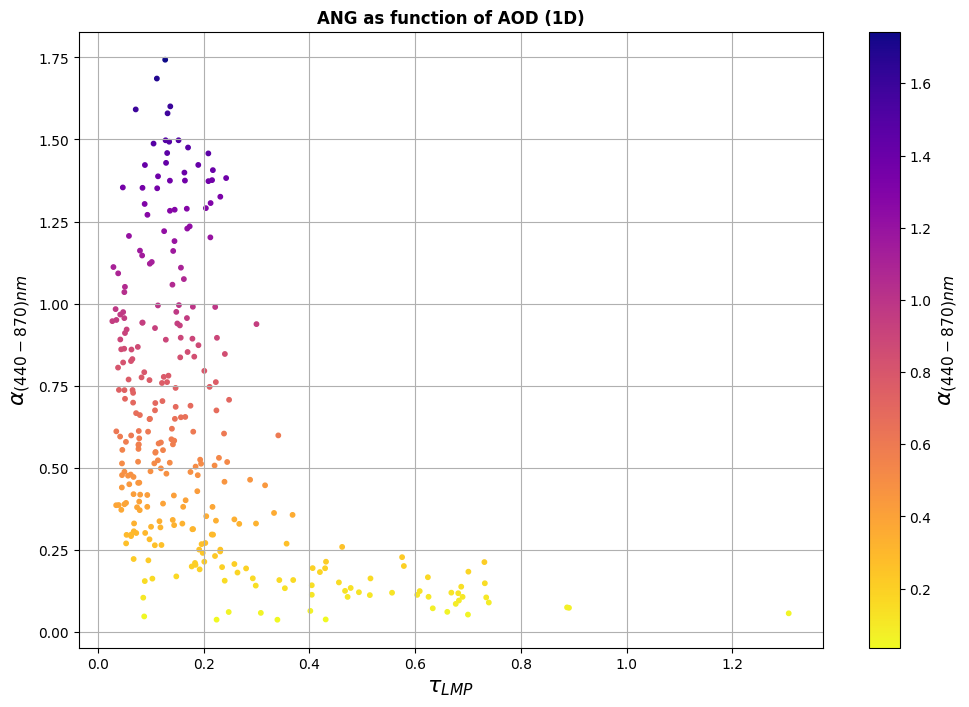

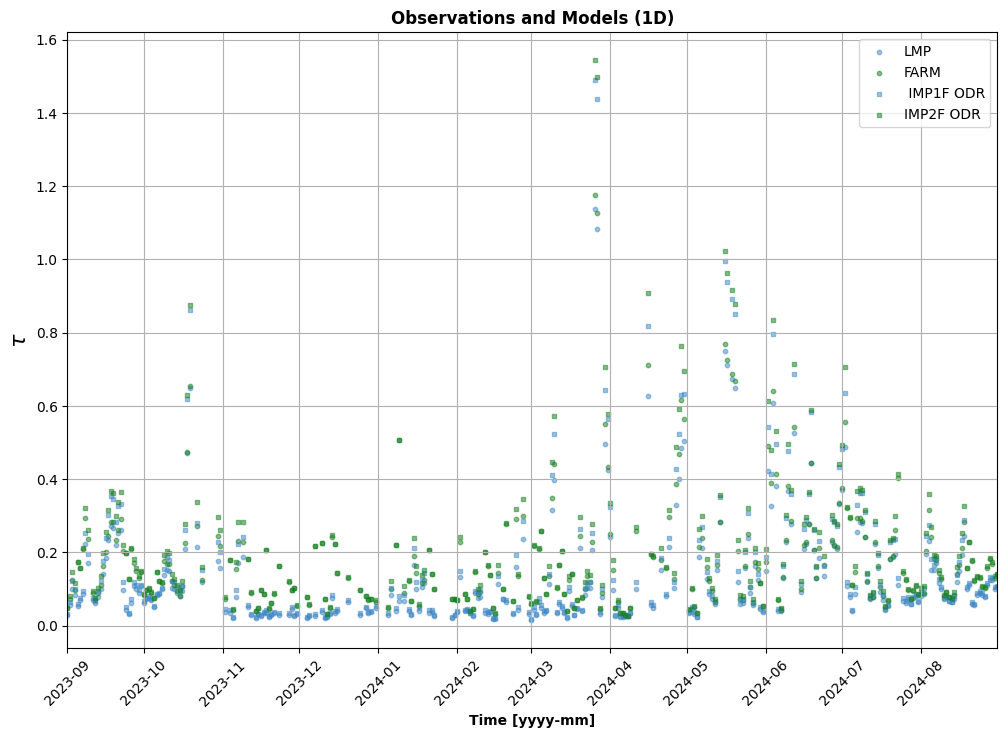

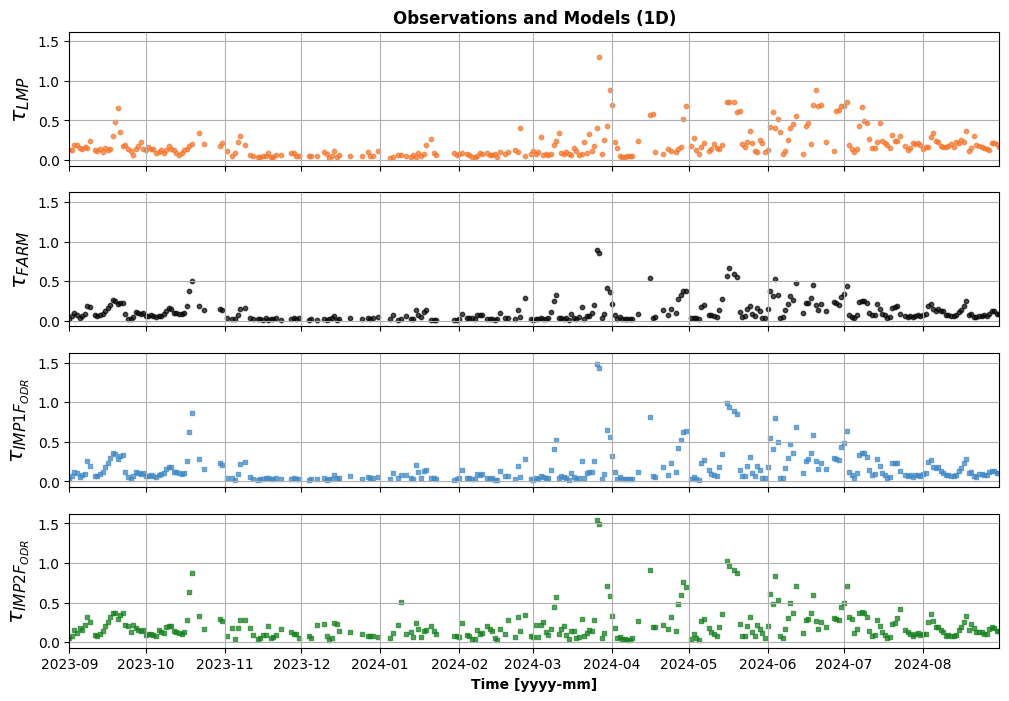

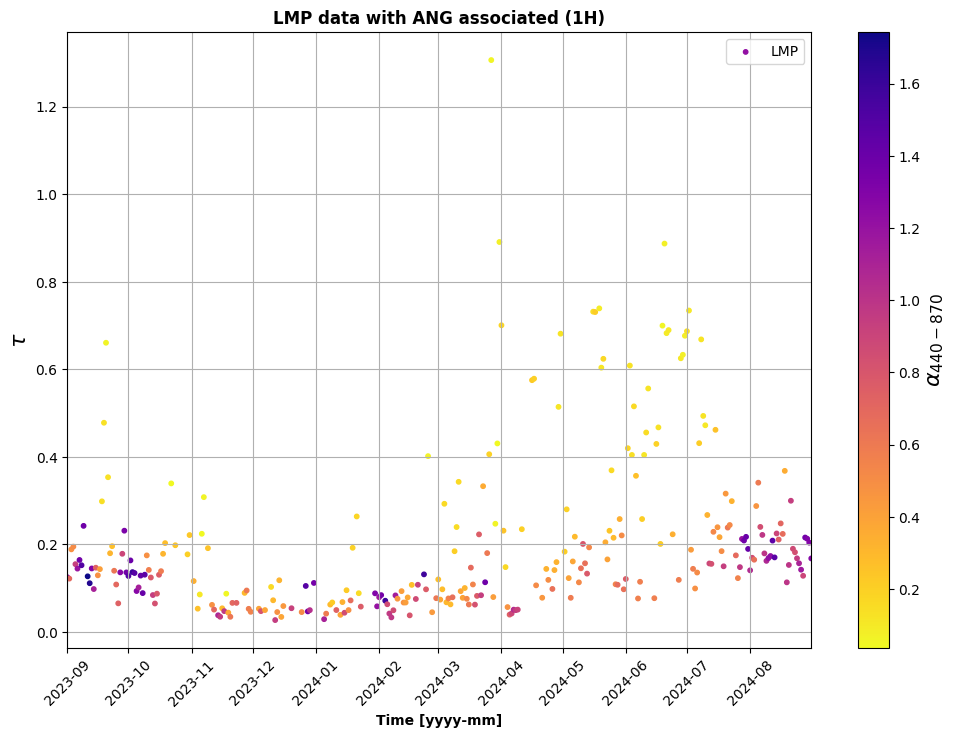

In [46]:
# #Variables
t = Data['1D']['time']
farm = Data['1D']['FARM']
imp1 = Data['1D']['IMP1F']
imp2 = Data['1D']['IMP2F']
lmp = Data['1D']['LMP']
ang = Data['1D']['ang_440_870']

# # t = Data['1H']['time']
# # farm = Data['1H']['FARM']
# # imp1 = Data['1H']['IMP1F']
# # imp2 = Data['1H']['IMP2F']
imp1_odr = Data['1D']['IMP1F_ODR']
imp2_odr = Data['1D']['IMP2F_ODR']
# # lmp = Data['1H']['LMP']
# # ang = Data['1H']['ang_440_870']

# mar = Data['1D'][(Data['1D']['time'].dt.month == 3) & (Data['1D']['time'].dt.day == 27)] 
# t_mar = mar['time']
# lmp_mar = mar['LMP']
# imp2_mar = mar['IMP2F_ODR']

plt.figure(figsize=(12, 8))

plt.scatter(lmp, ang, s=10, c=ang,  cmap="plasma_r", marker= 'o')
plt.xlabel(r"$\tau_{LMP}$", fontsize=16)
plt.ylabel(r"$\alpha_{(440-870)nm}$", fontsize=16)
plt.title("ANG as function of AOD (1D)", fontweight="bold")
plt.colorbar().set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)
plt.grid(True)
#plt.savefig("/home/andtoro/figure/ang_func_aod_D.pdf", format="pdf", bbox_inches="tight")

plt.show()

plt.figure(figsize= (12, 8))

# plt.scatter(t_mar, lmp_mar, s= 10, c= '#f3752b', marker= 'o', alpha= 0.5)
# plt.scatter(t_mar, imp2_mar, s= 10,  c= '#050505', marker= 'o', alpha= 0.4)
plt.scatter(t, imp1, s= 10,  c= '#3f88c5', marker= 'o', alpha= 0.5)
plt.scatter(t, imp2, s= 10,  c= '#157f1f', marker= 'o', alpha= 0.5)
plt.scatter(t, imp1_odr, s= 10,  c= '#3f88c5', marker= 's', alpha=0.5)
plt.scatter(t, imp2_odr, s= 10,  c= '#157f1f', marker= 's', alpha=0.5)
plt.grid(True)
plt.legend(labels= [r'LMP', r'FARM',  r' IMP1F ODR', r'IMP2F ODR'])
#plt.tight_layout()
plt.xlim(t.min(), t.max())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.title(r'Observations and Models (1D)', fontweight= 'bold')
plt.ylabel(r'$\tau$', fontsize= 16)
plt.xlabel(r'Time [yyyy-mm]', fontweight= "bold")

#plt.savefig("/home/andtoro/figure/time_FARM_LMP_IMP_D_unito_ODR.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize= (12, 8), sharex= True, sharey= True)

ax1.scatter(t, lmp,  s= 10, c= '#f3752b', marker= 'o', alpha= 0.7)
ax1.set_ylabel(r'$\tau_{LMP}$', fontsize= 16)
ax1.set_title(r'Observations and Models (1D)', fontweight= 'bold')
ax1.grid(True)
ax2.scatter(t, farm, s= 10, c=  '#050505', marker= 'o', alpha=0.7)
ax2.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
ax2.grid(True)
ax3.scatter(t, imp1_odr, s= 10, c=  '#3f88c5', marker= 's', alpha=0.7)
ax3.set_ylabel(r'$\tau_{IMP1F_{ODR}}$', fontsize= 16)
ax3.grid(True)
ax4.scatter(t, imp2_odr, s= 10, c=  '#157f1f', marker= 's', alpha=0.7)
ax4.set_ylabel(r'$\tau_{IMP2F_{ODR}}$', fontsize= 16)
ax4.grid(True)
ax4.set_xlabel(r'Time [yyyy-mm]', fontweight= "bold")
# ax5.scatter(t, imp1_odr, s= 10, c=  'red', marker= 's')
# ax5.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax5.grid(True)
# ax6.scatter(t, imp2_odr, s= 10, c=  'blue', marker= 's')
# ax6.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax6.grid(True)
# ax6.set_xlabel(r'Time [yyyy-mm]', fontsize= 16)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(t.min(), t.max())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

#plt.savefig("/home/andtoro/figure/time_FARM_LMP_IMP_D_separato_ODR.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize= (12, 8))

plt.scatter(t, lmp, s= 10, c= ang, cmap= 'plasma_r', marker= 'o')
#plt.plot(time, hmix/max(hmix), linestyle= '-.', color= 'black')
plt.grid(True)
plt.legend(labels= [r'LMP'])
plt.colorbar().set_label(r'$\alpha_{440-870}$', fontsize= 16)
#plt.tight_layout()
plt.xlim(t.min(), t.max())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.title(r'LMP data with ANG associated (1H)', fontweight= 'bold')
plt.ylabel(r'$\tau$', fontsize= 16)
plt.xlabel(r'Time [yyyy-mm]', fontweight= "bold")

#plt.savefig("/home/andtoro/project_enea/plot_final/time_LMP_FARM_ANG_3h.pdf", format="pdf")
#plt.savefig("/home/andtoro/figure/time_LMP_FARM_ANG_H.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
#Variables
t = Data['1H']['time']
farm = Data['1H']['FARM']
lmp = Data['1H']['LMP']
ang = Data['1H']['ang_440_870']

plt.figure(figsize= (10, 6))

plt.scatter(t, lmp, s= 10, c= '#f3752b', marker= 'o')
plt.scatter(t, farm, s= 10,  c= '#050505', marker= 'o')
plt.grid(True)
plt.legend(labels= [r'LMP', r'FARM'])
plt.xlim(t.min(), t.max())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.title(r'Observations and model (1D)', fontweight= 'bold')
plt.ylabel(r'$\tau$', fontsize= 16)
plt.xlabel(r'Time [yyyy-mm]', fontweight= 'bold')
#plt.savefig("/home/andtoro/figure/time_FARM_LMP_1D_unito.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10, 6), sharex= True, sharey= True)

ax1.scatter(t, lmp,  s= 10, c= '#f3752b', marker= 'o')
ax1.set_ylabel(r'$\tau_{LMP}$', fontsize= 16)
ax1.set_title(r'Observations and model (1D)', fontweight= 'bold')
ax1.grid(True)
ax2.scatter(t, farm, s= 10, c=  '#050505', marker= 'o')
ax2.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
ax2.grid(True)
ax2.set_xlabel(r'Time [yyyy-mm]', fontweight= 'bold')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(t.min(), t.max())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

#plt.savefig("/home/andtoro/figure/time_FARM_LMP_1D_separato.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize= (10, 6))

plt.scatter(t, lmp, s= 10, c= ang, cmap= 'plasma_r', marker= 'o')
#plt.plot(time, hmix/max(hmix), linestyle= '-.', color= 'black')
plt.grid(True)
plt.legend(labels= [r'LMP'])
plt.colorbar().set_label(r'$\alpha_{(440-870)}nm$', fontsize= 16)
plt.xlim(t.min(), t.max())
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.title(r'LMP data with ANG associated (1H)', fontweight= 'bold')
plt.ylabel(r'$\tau$', fontsize= 16)
plt.xlabel(r'Time [yyyy-mm]', fontweight= 'bold')
#plt.savefig("/home/andtoro/figure/time_LMP_FARM_ANG_1H.pdf", format="pdf",  bbox_inches="tight")
#plt.tight_layout()
plt.show()

In [ ]:
# plot separato
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (15, 12), sharex= True, sharey= True)

ax1.scatter(Data['1H']['time'], Data['1H']['LMP'],  s= 5, c= '#f3752b', marker= 'o', label= 'obs', alpha=0.5)
ax1.scatter(Data['1H']['time'], Data['1H']['FARM'], s= 5, c= '#050505', marker= 'o', label= 'sim', alpha=0.4)
ax1.scatter(Data['1H']['time'], Data['1H']['IMP1F'], s= 5, c= '#3f88c5', marker= 'o', label= 'imp1', alpha=0.5)
ax1.scatter(Data['1H']['time'], Data['1H']['IMP2F'], s= 5, c= '#157f1f', marker= 'o', label= 'imp2', alpha=0.4)
ax1.set_title(r'1H', fontweight= 'bold')
ax1.set_ylabel(r'$\tau$', fontsize= 16)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval= 1))
ax1.tick_params(labelsize= '7', labelrotation= 45)
ax1.grid(True)

ax2.scatter(Data['3H']['time'], Data['3H']['LMP'],  s= 5, c= '#f3752b', marker= 'o', label= 'obs', alpha=0.5)
ax2.scatter(Data['3H']['time'], Data['3H']['FARM'], s= 5, c= '#050505', marker= 'o', label= 'sim', alpha=0.4)
ax2.scatter(Data['3H']['time'], Data['3H']['IMP1F'], s= 5, c= '#3f88c5', marker= 'o', label= 'imp1', alpha=0.5)
ax2.scatter(Data['3H']['time'], Data['3H']['IMP2F'], s= 5, c= '#157f1f', marker= 'o', label= 'imp2', alpha=0.4)
ax2.set_title(r'3H', fontweight= 'bold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval= 1))
ax2.tick_params(labelsize= '7', labelrotation= 45)
ax2.grid(True)

ax3.scatter(Data['6H']['time'], Data['6H']['LMP'],  s= 5, c= '#f3752b', marker= 'o', label= 'obs', alpha=0.5)
ax3.scatter(Data['6H']['time'], Data['6H']['FARM'], s= 5, c= '#050505', marker= 'o', label= 'sim', alpha=0.4)
ax3.scatter(Data['6H']['time'], Data['6H']['IMP1F'], s= 5, c= '#3f88c5', marker= 'o', label= 'imp1', alpha=0.5)
ax3.scatter(Data['6H']['time'], Data['6H']['IMP2F'], s= 5, c= '#157f1f', marker= 'o', label= 'imp2', alpha=0.4)
ax3.set_title(r'6H', fontweight= 'bold')
ax3.set_ylabel(r'$\tau$', fontsize= 16)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval= 1))
ax3.tick_params(labelsize= '7', labelrotation= 45)
ax3.grid(True)

ax4.scatter(Data['1D']['time'], Data['1D']['LMP'],  s= 5, c= '#f3752b', marker= 'o', label= 'obs', alpha=0.5)
ax4.scatter(Data['1D']['time'], Data['1D']['FARM'], s= 5, c= '#050505', marker= 'o', label= 'sim', alpha=0.4)
ax4.scatter(Data['1D']['time'], Data['1D']['IMP1F'], s= 5, c= '#3f88c5', marker= 'o', label= 'imp1', alpha=0.5)
ax4.scatter(Data['1D']['time'], Data['1D']['IMP2F'], s= 5, c= '#157f1f', marker= 'o', label= 'imp2', alpha=0.4)
ax4.set_title(r'1D', fontweight= 'bold')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval= 1))
ax4.tick_params(labelsize= '7', labelrotation= 45)
ax4.grid(True)

#for label in ax6.get_xticklabels():
#    label.set_fontweight('bold')
#    label.set_fontfamily('sans-serif') 

ax4.grid(True)
fig.legend(loc='upper right', labels= ['LMP', 'FARM', 'IMP1F', 'IMP2F'], bbox_to_anchor=(0.55, 0.89), ncol=1, fancybox=True, shadow=True)
start_date = pd.to_datetime('2023-09-01')
end_date = pd.to_datetime('2024-09-01')
plt.xlim(start_date, end_date)
plt.xlabel(r'Time [dd/mm/yyyy]', x= -0.1, fontweight= 'bold')
#plt.tight_layout()
plt.savefig("/home/andtoro/figure/time_LMP_FARM_averages.pdf", format="pdf", bbox_inches="tight")
plt.show()

## PBL on Lampedusa 

In [ ]:
time = Data['1D']['time']
hmix = Data['1D']['HMIX']

hmix_dump = Data['1H'].resample('MS', on= 'time').mean()
time_month = hmix_dump.index.to_numpy()
hmix_month = hmix_dump['HMIX']

plt.figure(figsize=(12, 8))
plt.plot(time_month, hmix_month, linestyle= '--', color= 'black')
plt.xlabel('Time [yyyy-mm]', fontweight= 'bold')
plt.xlim(time_month.min(), time_month.max())
plt.ylabel('Altitude [m]', fontweight= 'bold')
plt.title('Boundary layer (months average)', fontweight= 'bold')
#plt.tight_layout()
plt.grid(True)
plt.savefig("/home/andtoro/figure/boundary_layer_LMP.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Errorbar LMP and differences between averages behaviour

In [ ]:
# time = data['data24h']['time']
# time_1 = data['data1h']['time']
# aod_obs = data['data24h']['LMP']
# aod_obs_1 = data['data1h']['LMP']
# #err_obs = data['data24h']['err_day']
# fluct = data['data24h']['err_day_new']
# err = data['data24h']['err_new']
# err_obs_1 = data['data1h']['err_1h_new']
# err_obs = data['data24h']['err_day_new']
# errore_relativo = (err_obs/aod_obs) * 100
# errore_relativo_1 = (err_obs_1/aod_obs_1) * 100

# plt.figure(figsize=(12, 8))
# plt.scatter(time_1, aod_obs_1, s= 5, marker= 'o', c= 'red', label= 'LMP')
# #plt.fill_between(time, aod_obs - fluct, aod_obs + fluct,  color= 'red, alpha= 0.6)
# #plt.errorbar(time, aod_obs, yerr= err, c= 'red, capsize= 5, linestyle= '')
# plt.errorbar(time_1, aod_obs_1, yerr= err_obs_1, c= 'red', capsize= 5, linestyle= '', alpha= 0.5)
# plt.scatter(time, aod_obs, s= 5, marker= 'o', c= 'blue', label= 'LMP')
# #plt.fill_between(time, aod_obs - fluct, aod_obs + fluct,  color= 'blue, alpha= 0.6)
# #plt.errorbar(time, aod_obs, yerr= err, c= 'blue, capsize= 5, linestyle= '')
# plt.errorbar(time, aod_obs, yerr= fluct, c= 'blue', capsize= 5, linestyle= '', alpha= 0.5)
# plt.title('Observations with uncertainty', fontweight= 'bold')
# plt.xlim(time.min(), time.max())
# plt.ylabel(r'$\tau$', fontsize= 16)
# plt.xlabel('Time [yyyy-mm]', fontweight= 'bold')
# plt.legend(['Hourly data', 'Daily data'])
# #date_formatter = DateFormatter('%Y/%m')
# #plt.gca().xaxis.set_major_formatter(date_formatter)
# #plt.gcf().autofmt_xdate() 
# #plt.tight_layout()
# plt.grid(True)
# plt.savefig("/home/andtoro/figure/plot_errorbar.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# plt.figure(figsize= (12, 8))

# plt.plot(Data['1H']['time'], Data['1H']['LMP'], c= 'red', linestyle= ':', label= 'LMP (1h)', alpha= 0.5)
# #plt.plot(Data['3H']['time'], Data['3H']['LMP'], c= 'red', linestyle= '-.', label= 'LMP (3h)', alpha= 0.6)
# plt.plot(Data['1D']['time'], Data['1D']['LMP'], c= 'blue',  linestyle= '-', label= 'LMP (24h)', alpha= 0.5)
# plt.xlabel('Time [yyyy-mm]', fontweight= 'bold')
# plt.ylabel(r'$\tau$', fontsize= 16)
# plt.xlim(Data['1D']['time'].min(), Data['1D']['time'].max())
# plt.legend()
# plt.title('Data averages', fontweight= 'bold')
# plt.grid(True)
# #plt.tight_layout()
# plt.savefig("/home/andtoro/figure/1H_1D_diff.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# plt.figure(figsize= (12, 8))

# plt.scatter(aod_obs_1, errore_relativo_1, c= 'red', marker= 's', alpha= 0.6)
# plt.scatter(aod_obs, errore_relativo, c= 'blue', marker= 's', alpha= 0.6)
# #plt.yscale('log')
# plt.xlabel(r'$\tau$',fontsize= 16)
# plt.ylabel(r'$\frac{\Delta\tau}{\tau}\%$', fontsize= 16)
# plt.title('Relative error percentage', fontweight= 'bold')
# plt.legend(['Hourly data', 'Daily data'])
# plt.grid(True)
# #plt.tight_layout()
# plt.savefig("/home/andtoro/figure/err_rel.pdf", format="pdf", bbox_inches="tight")
# plt.show()

## Data divided into season and associated with ANG

In [ ]:
# season = {
#     'fall': fall_24h, 
#     'winter': winter_24h, 
#     'spring': spring_24h,
#     'summer':  summer_24h
# }

# # plot separato
# fig, ax = plt.subplots(2, 2, figsize= (12, 8), sharey= True, sharex= False)
# ax = ax.ravel()

# norm = mcolors.Normalize(vmin=0., vmax=2.) 
# cmap = cm.plasma_r

# for i, season_name in enumerate(season):
#     data = season[season_name]

#     ax[i].scatter(data['time'], data['LMP'], s=10, c= data['ang_440_870'], cmap= 'plasma_r', marker= 'o')
#     #ax[i].set_ylabel(r'$\tau$')
#     #ax[i].set_xlabel(r'Time [dd-mm-yyyy]')
#     ax[i].set_title(season_name.capitalize(), fontweight= 'bold')
#     ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
#     ax[i].grid(True)
#     #ax[i].tick_params(labelsize= '7', labelrotation= 45)
#     ax[i].set_xlim(data['time'].min(), data['time'].max())

#     if i >= 2:
#         ax[i].set_xlabel('Time [mm/yy]', fontweight="bold")


# ax[0].set_ylabel(r'$\tau$', fontsize= 16)
# ax[2].set_ylabel(r'$\tau$', fontsize= 16)
# fig.legend(loc='upper right', labels= ['LMP'], bbox_to_anchor=(0.80, 0.92), ncol=1, fancybox=True, shadow=True)

# cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax= ax, orientation='vertical')
# cbar.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

# fig.suptitle(r'Season with ANG associated', fontweight= 'bold', fontsize= 16, x= 0.45, y= 0.94)
# plt.savefig("/home/andtoro/figure/time_LMP_ANG_season.pdf", format="pdf", bbox_inches="tight")
# plt.show()

## Observed data divivded into Desert Dust (DD), Biomass Burning anthropogenic or natural (BB), and Mixed (MX)

In [ ]:
# plt.figure(figsize= (12, 8))

# colors = {
#     'DD': '#f7b538',
#     'BB': '#dd0426',
#     'MX': '#798071'
# }
# markers = {
#     'DD': 'p', 
#     'BB': 'd',
#     'MX': 's'
# }

# plt.scatter(DeDu24['time'], DeDu24['LMP'], marker= 'p', c= colors['DD'], s= 15, alpha= 0.8)
# plt.scatter(BioBu24['time'], BioBu24['LMP'], marker= 'd', c= colors['BB'] , s= 15, alpha= 0.8)
# plt.scatter(Mix24['time'], Mix24['LMP'], marker= 's', c= colors['MX'], s= 15, alpha= 0.7)
# plt.xlabel('Time [yyyy-mm]', fontweight="bold")
# plt.ylabel(r'$\tau$', fontsize= 16)
# plt.xlim(data_h['m24']['time'].min(), data_h['m24']['time'].max())
# plt.title('LMP', fontweight= 'bold')

# #plt.tight_layout()
# plt.legend(labels= ['DD', 'BB', 'MX'], loc= 'best', shadow= True, fancybox= True,)
# plt.grid(True)
# plt.savefig("/home/andtoro/figure/time_LMP_DD_BB_MX.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex= True, sharey= True)

# aerosols = ['DD', 'BB', 'MX']
# data_type = ['LMP', 'FARM', 'IMP1F', 'IMP2F']

# aero_type = {
#     'DD': DeDu,
#     'BB': BioBu, 
#     'MX': Mix
# }

# aero_type24 = {
#     'DD': DeDu24,
#     'BB': BioBu24, 
#     'MX': Mix24
# }

# for i in range(4): 
#     for j in aerosols:
#         ax[i].scatter(aero_type24[j]['time'], aero_type24[j][data_type[i]], c= colors[j], label= f'{j}', marker= markers[j], s= 10, alpha= 0.8)
#         if i == 3:
#             ax[i].set_xlabel('Time [yyyy-mm]', fontweight="bold")
#         elif i == 2:
#             ax[i].set_ylabel(r'$\tau$', fontsize= 16, y=1.2)
#         ax[i].grid(True)
#         ax[i].set_title(data_type[i], fontweight= 'bold')
#     ax[i].set_xlim(data_h['m3']['time'].min(), data_h['m3']['time'].max())

# fig.legend(aerosols, loc='upper center', ncol=len(aerosols), bbox_to_anchor=(0.8, 0.90), fancybox= True, shadow= True)
# #plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Adjust layout to fit the legend
# plt.savefig("/home/andtoro/figure/time_LMP_DD_BB_MX_MODS.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)

# aerosols = ['DD', 'MX', 'BB']
# data_type = ['LMP', 'FARM', 'IMP1F', 'IMP2F']
# colors = {
#     'DD': '#f7b538',
#     'BB': '#dd0426',
#     'MX': '#798071'
# }

# aero_type = {
#     'DD': DeDu,
#     'BB': BioBu,
#     'MX': Mix
# }
# aero_type24 = {
#     'DD': DeDu24,
#     'BB': BioBu24, 
#     'MX': Mix24
# }

# for i in range(4):
#     for j in aerosols:
#         ax[i].set_title(data_type[i], fontweight= 'bold')
#         data = aero_type24[j][data_type[i]]

#         # Calculate bin width: (max - min) / sqrt(number of data points)
#         bin_width = (data.max() - data.min()) / np.sqrt(len(data))
#         bins = np.arange(data.min(), data.max() + bin_width, bin_width)
        
#         # Plot the histogram with custom bins and separation lines
#         ax[i].hist(data, bins=bins, color=colors[j], label=j, alpha=0.7, edgecolor='black')
        
#         if i == 3:  # Only set the x-axis label for the last subplot
#             ax[i].set_xlabel(r'$\tau$', fontsize= 16)
#         ax[i].grid(True)
#     ax[i].set_xlim(data_h['m24']['LMP'].min(), data_h['m24']['LMP'].max())
# ax[1].set_ylabel('Number of occurencies', fontweight= 'bold', y= -0.2, fontsize= 16)
# # Create a single legend outside the subplots
# fig.legend(aerosols, loc='upper center', ncol=len(aerosols), bbox_to_anchor=(0.8, 0.96))
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
# plt.savefig("/home/andtoro/figure/histograms_DD_BB_MX_MODS_time.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# # Define the seasonal data dictionaries
# seasonal_data_DD = {
#     'Fall': fall_24h_DD,
#     'Winter': winter_24h_DD,
#     'Spring': spring_24h_DD,
#     'Summer': summer_24h_DD
# }

# seasonal_data_BB = {
#     'Fall': fall_24h_BB,
#     'Winter': winter_24h_BB,
#     'Spring': spring_24h_BB,
#     'Summer': summer_24h_BB
# }

# seasonal_data_MX = {
#     'Fall': fall_24h_MX,
#     'Winter': winter_24h_MX,
#     'Spring': spring_24h_MX,
#     'Summer': summer_24h_MX
# }

# # Mapping for easy iteration
# seasonal_data = {
#     'DD': seasonal_data_DD,
#     'BB': seasonal_data_BB,
#     'MX': seasonal_data_MX
# }

# data_type = ['LMP', 'FARM', 'IMP1F', 'IMP2F']
# aerosols = ['DD','MX', 'BB']
# colors = {
#     'DD': '#f7b538',
#     'BB': '#dd0426',
#     'MX': '#798071'
# }

# # Loop through each subplot (season)
# for i, season in enumerate(['Fall', 'Winter', 'Spring', 'Summer']):
#     ax_i = ax.flat[i]
    
#     # Loop through each aerosol and data type for the current season
#     for aerosol in aerosols:
#         for j, data_column in enumerate(data_type):
#             # Get the data for the aerosol and the season
#             data = seasonal_data[aerosol][season][data_column]
#             if np.any(np.isnan(data)):
#                 print("Data contains NaN values.")
#                 continue
#             # Calculate bin width for histogram
#             bin_width = (data.max() - data.min()) / np.sqrt(len(data))
#             if np.any(np.isnan(bin_width)):
#                 bin_width = 0.1
#             else:
#                 bins = np.arange(data.min(), data.max() + bin_width, bin_width)
        
#             # Plot histogram for the current aerosol and data type
#         ax_i.hist(data, bins=bins, color=colors[aerosol], label=f'{aerosol} - {data_column}', alpha=0.7, edgecolor='black')
#         if (i == 2 or i == 3):
#             ax_i.set_xlabel(r'$\tau$', fontsize= 16)
#         if (i == 0 or i == 2):
#             ax_i.set_ylabel('Number of occurrences', fontweight= 'bold')
    
#     ax_i.set_title(f"{season}", fontweight= 'bold')
#     ax_i.grid(True)

# # Create a legend outside the subplots
# fig.legend(aerosols, loc='upper center', ncol=len(aerosols), bbox_to_anchor=(0.5, 0.96))
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig("/home/andtoro/figure/histograms_DD_BB_MX_MODS_tau_season.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# # Define the seasonal data dictionaries
# seasonal_data_DD = {
#     'Fall': fall_24h_DD,
#     'Winter': winter_24h_DD,
#     'Spring': spring_24h_DD,
#     'Summer': summer_24h_DD
# }

# seasonal_data_BB = {
#     'Fall': fall_24h_BB,
#     'Winter': winter_24h_BB,
#     'Spring': spring_24h_BB,
#     'Summer': summer_24h_BB
# }

# seasonal_data_MX = {
#     'Fall': fall_24h_MX,
#     'Winter': winter_24h_MX,
#     'Spring': spring_24h_MX,
#     'Summer': summer_24h_MX
# }

# # Mapping for easy iteration
# seasonal_data = {
#     'DD': seasonal_data_DD,
#     'BB': seasonal_data_BB,
#     'MX': seasonal_data_MX
# }

# data_type = ['LMP', 'FARM', 'IMP1F', 'IMP2F']
# aerosols = ['DD', 'MX', 'BB']

# # Loop through each subplot (season)
# for i, season in enumerate(['Fall', 'Winter', 'Spring', 'Summer']):
#     ax_i = ax.flat[i]
    
#     # Loop through each aerosol and data type for the current season
#     for aerosol in aerosols:
#         # Get the data for the aerosol and the season
#         data = seasonal_data[aerosol][season]['ang_440_870']
#         if np.any(np.isnan(data)):
#             print("Data contains NaN values.")
#             continue
#         # Calculate bin width for histogram
#         bin_width = (data.max() - data.min()) / np.sqrt(len(data))
#         if np.any(np.isnan(bin_width)):
#             bin_width = 0.1
#         else:
#             bins = np.arange(data.min(), data.max() + bin_width, bin_width)
        
#         # Plot histogram for the current aerosol and data type
#         ax_i.hist(data, bins=bins, color=colors[aerosol], label=f'{aerosol} - {data_column}', alpha=0.6, edgecolor='black')
#         if (i == 2 or i == 3):
#             ax_i.set_xlabel(r'$\alpha_{(440-870)nm}$', fontsize= 16)
#         if (i == 0 or i == 2):
#             ax_i.set_ylabel('Number of occurrences', fontweight= 'bold')
    
#     ax_i.set_title(f"{season}", fontweight= 'bold')
#     ax_i.grid(True)

# # Create a legend outside the subplots
# fig.legend(aerosols, loc='upper center', ncol=len(aerosols), bbox_to_anchor=(0.51, 0.96))
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig("/home/andtoro/project_enea/plot_final/histograms_DD_BB_MX_MODS_ang_season.pdf", format="pdf")
# plt.show()

# Residuals

In [ ]:
lmp_obs = Data['1D']['LMP']
pred_farm = Data['1D']['FARM']
pred_imp1f = Data['1D']['IMP1F']
pred_imp2f = Data['1D']['IMP2F']

index_obs = range(len(lmp_obs))
errors_aod = Data['1D']['err_day_new']
errors_farm = Data['1D']['errFarm_24']
errors_imp1 = Data['1D']['err_IMP1_24']
errors_imp2 = Data['1D']['err_IMP2_24']

mean_obs = np.mean(lmp_obs)

res_1 = (lmp_obs - pred_farm)
res_2 = (lmp_obs - pred_imp1f)
res_3 = (lmp_obs - pred_imp2f)

res_1_mean = np.mean(res_1)
res_2_mean = np.mean(res_2)
res_3_mean = np.mean(res_3)

def calculate_variance(residuals):
    n = len(residuals)  # Number of observations
    residuals_mean = np.mean(residuals)
    variance = np.sum((residuals - residuals_mean)**2) / n
    return variance

var_1 = calculate_variance(res_1)
var_2 = calculate_variance(res_2)
var_3 = calculate_variance(res_3)

err_1 = np.sqrt((errors_aod**2) + (errors_farm)**2)
err_2 = np.sqrt((errors_aod**2) + (errors_imp1)**2)
err_3 = np.sqrt((errors_aod**2) + (errors_imp2)**2)

sigma_1 = np.sqrt(var_1)
sigma_2 = np.sqrt(var_2)
sigma_3 = np.sqrt(var_3)

oBs = range(len(lmp_obs))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), sharex= True, sharey= True)

#ax1.scatter(lmp_obs, res_1, color='#2e4057', s=10, label= f'$\\sigma_{{FARM}}: {sigma_1:.4f}$\n$\\mu_{{LMP}}: {mean_obs:.4f}$')
ax1.errorbar(lmp_obs, res_1, yerr= err_1, color='#2e4057', marker= 'o', markersize= 3, capsize= 5, linestyle= '')
ax1.axhline(0, color='#f18f01', linestyle='--', linewidth=1.5)
#ax1.set_xlabel('LMP',fontweight="bold")
ax1.set_ylabel('Residuals', fontweight="bold")
ax1.set_title('FARM',fontweight="bold")
ax1.grid(True)

#ax2.scatter(lmp_obs, res_2, color='#2e4057', s=10, label= f'$\\sigma_{{IMP1F}}: {sigma_2:.4f}$')
ax2.errorbar(lmp_obs, res_2, yerr= err_2, color='#2e4057', marker= 'o', markersize= 3, capsize= 5, linestyle= '')
ax2.axhline(0, color='#f18f01', linestyle='--', linewidth=1.5)
ax2.set_xlabel('LMP',fontweight="bold")
#ax2.set_ylabel('Residuals')
ax2.set_title('IMP1F',fontweight="bold")
ax2.grid(True)

#ax3.scatter(lmp_obs, res_3, color='#2e4057', s=10, label= f'$\\sigma_{{IMP2F}}: {sigma_3:.4f}$')
ax3.errorbar(lmp_obs, res_3, yerr= err_3, color='#2e4057', marker= 'o', markersize= 3, capsize= 5, linestyle= '')
ax3.axhline(0, color='#f18f01', linestyle='--', linewidth=1.5)
#ax3.set_xlabel('LMP',fontweight="bold")
#ax3.set_ylabel('Residuals')
ax3.set_title('IMP2F',fontweight="bold")
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

plt.setp(ax1.get_xticklabels(), visible=True)
plt.setp(ax2.get_xticklabels(), visible=True)
plt.setp(ax3.get_xticklabels(), visible=True)

plt.setp(ax1.get_yticklabels(), visible=True)
plt.setp(ax2.get_yticklabels(), visible=True)
plt.setp(ax3.get_yticklabels(), visible=True)

#plt.savefig("/home/andtoro/figure/residuals.pdf", format="pdf", bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharex= True, sharey= True)

for i in range(1, 4):
    axes = axes.ravel()
    res = eval(f'res_{i}')
    counts, bin_edges = np.histogram(res, bins=20)
    normalized_counts = counts / np.sum(counts)

    axes[i-1].bar(bin_edges[:-1], normalized_counts, width=np.diff(bin_edges), color='#4a2545', edgecolor='black')

    if i == 1:
        axes[i-1].set_xlabel('Error Values for FARM ')
    elif i == 2: 
        axes[i-1].set_xlabel('Error Values for IMP1F')
    elif i == 3: 
        axes[i-1].set_xlabel('Error Values for IMP2F')
    
    axes[i-1].set_ylabel('Normalized Frequency')
    axes[i-1].set_title('Histogram of Errors')
    axes[i-1].grid(True)
    axes[i-1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    #axes[i-1].axis('off')

#if len(axes) > 3:
    #fig.delaxes(axes[3])
plt.setp(axes[0].get_xticklabels(), visible=True)
plt.setp(axes[1].get_xticklabels(), visible=True) 
plt.setp(axes[2].get_xticklabels(), visible=True)
plt.setp(axes[0].get_yticklabels(), visible=True)
plt.setp(axes[1].get_yticklabels(), visible=True) 
plt.setp(axes[2].get_yticklabels(), visible=True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

imp1odr = Data['1D']['IMP1F_ODR']
imp2odr = Data['1D']['IMP2F_ODR']
imp1ns = Data['1D']['IMP1F_NS']
imp2ns = Data['1D']['IMP2F_NS']

# Compute residuals
res_1 = lmp_obs - pred_farm
res_2 = lmp_obs - pred_imp1f
res_3 = lmp_obs - pred_imp2f

# Compute errors
err_1 = np.sqrt(errors_aod**2 + errors_farm**2)
err_2 = np.sqrt(errors_aod**2 + errors_imp1**2)
err_3 = np.sqrt(errors_aod**2 + errors_imp2**2)

# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)

# Define plot settings
models = ["FARM", "IMP1F", "IMP2F"]
residuals = [res_1, res_2, res_3]
errors = [err_1, err_2, err_3]
colors = ['#050505', '#3f88c5', '#157f1f']  # Blue, Orange, Green

for ax, model, res, err, color in zip(axes, models, residuals, errors, colors):
    ax.errorbar(lmp_obs, res, yerr=err, fmt='o', color=color, alpha=0.7, capsize=4)
    ax.axhline(0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    
    ax.set_title(model, fontweight="bold", fontsize=13)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Formatting
    ax.tick_params(axis='both', which='major', labelsize=11)

# Shared labels
axes[1].set_xlabel("LMP (Observed)", fontweight="bold", fontsize=12)
axes[0].set_ylabel("Residuals", fontweight="bold", fontsize=12)

plt.tight_layout()
#plt.savefig("/home/andtoro/figure/residuals.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Scatter plot between models with statistics

In [ ]:
data_obs = Data['1D']['LMP'].to_numpy()
data_farm = Data['1D']['FARM'].to_numpy()
data_imp1f = Data['1D']['IMP1F'].to_numpy()
data_imp2f = Data['1D']['IMP2F'].to_numpy()
data_imp1f_odr = Data['1D']['IMP1F_ODR'].to_numpy()
data_imp2f_odr = Data['1D']['IMP2F_ODR'].to_numpy()
data_imp1f_ns = Data['1D']['IMP1F_NS'].to_numpy()
data_imp2f_ns = Data['1D']['IMP2F_NS'].to_numpy()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Calculate NMSE
    mse = np.mean((y_true - y_pred) ** 2)
    var_y = np.var(y_true)
    #nmse = mse / var_y if var_y != 0 else np.nan  # Avoid division by zero

    # Calculate Variance
    variance = var_y
    return bias, corr, rmse, variance, mse

# Calculate metrics for each comparison
metrics_farm = calculate_metrics(data_obs, data_farm)
metrics_imp1f = calculate_metrics(data_obs, data_imp1f)
metrics_imp2f = calculate_metrics(data_obs, data_imp2f)
metrics_imp1f_odr = calculate_metrics(data_obs, data_imp1f_odr)
metrics_imp2f_odr = calculate_metrics(data_obs, data_imp2f_odr)
metrics_imp1f_ns = calculate_metrics(data_obs, data_imp1f_ns)
metrics_imp2f_ns = calculate_metrics(data_obs, data_imp2f_ns)

# Print the results
print("Metrics for AOD (FARM):")
print(f'Bias: {metrics_farm[0]}, Correlation: {metrics_farm[1]}, RMSE: {metrics_farm[2]}, Variance: {metrics_farm[3]}, N: {len(data_obs)}')

print("\nMetrics for AOD (IMP1F):")
print(f'Bias: {metrics_imp1f[0]}, Correlation: {metrics_imp1f[1]}, RMSE: {metrics_imp1f[2]}, Variance: {metrics_imp1f[3]}')

print("\nMetrics for AOD (IMP2F):")
print(f'Bias: {metrics_imp2f[0]}, Correlation: {metrics_imp2f[1]}, RMSE: {metrics_imp2f[2]}, Variance: {metrics_imp2f[3]}')

print("\nMetrics for AOD (IMP1F_ODR):")
print(f'Bias: {metrics_imp1f_odr[0]}, Correlation: {metrics_imp1f_odr[1]}, RMSE: {metrics_imp1f_odr[2]}, Variance: {metrics_imp1f_odr[3]}')

print("\nMetrics for AOD (IMP2F_ODR):")
print(f'Bias: {metrics_imp2f_odr[0]}, Correlation: {metrics_imp2f_odr[1]}, RMSE: {metrics_imp2f_odr[2]}, Variance: {metrics_imp2f_odr[3]}')

print("\nMetrics for AOD (IMP1F_NS):")
print(f'Bias: {metrics_imp1f_ns[0]}, Correlation: {metrics_imp1f_ns[1]}, RMSE: {metrics_imp1f_ns[2]}, Variance: {metrics_imp1f_ns[3]}')

print("\nMetrics for AOD (IMP2F_NS):")
print(f'Bias: {metrics_imp2f_ns[0]}, Correlation: {metrics_imp2f_ns[1]}, RMSE: {metrics_imp2f_ns[2]}, Variance: {metrics_imp2f_ns[3]}')

In [ ]:
import numpy as np
from scipy.stats import pearsonr

data_obs = Data['1D']['LMP'].to_numpy()
data_farm = Data['1D']['FARM'].to_numpy()
data_imp1f = Data['1D']['IMP1F'].to_numpy()
data_imp2f = Data['1D']['IMP2F'].to_numpy()
data_imp1f_odr = Data['1D']['IMP1F_ODR'].to_numpy()
data_imp2f_odr = Data['1D']['IMP2F_ODR'].to_numpy()
data_imp1f_ns = Data['1D']['IMP1F_NS'].to_numpy()
data_imp2f_ns = Data['1D']['IMP2F_NS'].to_numpy()

data_dd = DeDu24['LMP'].to_numpy()
data_farm_dd = DeDu24['FARM'].to_numpy()
data_imp2f_odr_dd = DeDu24['IMP2F_ODR'].to_numpy()
data_imp2f_ns_dd = DeDu24['IMP2F_NS'].to_numpy()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n, p):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Calculate Variance
    variance = np.var(y_true)

    # Calculate R² (Coefficient of Determination)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Sum of Squares (TSS)
    ss_residual = np.sum((y_true - y_pred) ** 2)  # Residual Sum of Squares (RSS)
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan  # Avoid division by zero

    # Calculate Adjusted R²
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else np.nan  # Avoid invalid adjustment

    return bias, corr, rmse, variance, r2, adjusted_r2

# Define number of observations (n) and number of parameters (p)
n = len(data_obs)  # 49 data points
p = 2  # Two parameters in the regression model

n_d = len(data_dd)

# Calculate metrics for each comparison
metrics_farm = calculate_metrics(data_obs, data_farm, n, p)
metrics_imp1f = calculate_metrics(data_obs, data_imp1f, n, p)
metrics_imp2f = calculate_metrics(data_obs, data_imp2f, n, p)
metrics_imp1f_odr = calculate_metrics(data_obs, data_imp1f_odr, n, p)
metrics_imp2f_odr = calculate_metrics(data_obs, data_imp2f_odr, n, p)
metrics_imp1f_ns = calculate_metrics(data_obs, data_imp1f_ns, n, p)
metrics_imp2f_ns = calculate_metrics(data_obs, data_imp2f_ns, n, p)

metrics_imp2fodr_dd = calculate_metrics(data_dd, data_imp2f_odr_dd, n_d, p)
metrics_imp2fns_dd = calculate_metrics(data_dd, data_imp2f_ns_dd, n_d, p)
metrics_farm_dd = calculate_metrics(data_dd, data_farm_dd, n_d, p)

# Print the results
def print_metrics(name, metrics):
    print(f"\nMetrics for AOD ({name}):")
    print(f'Bias: {metrics[0]:.4f}, Correlation: {metrics[1]:.4f}, RMSE: {metrics[2]:.4f}, '
          f'Variance: {metrics[3]:.4f}, R²: {metrics[4]:.4f}, Adjusted R²: {metrics[5]:.4f}, N: {n}')

print_metrics("FARM", metrics_farm)
print_metrics("IMP1F", metrics_imp1f)
print_metrics("IMP2F", metrics_imp2f)
print_metrics("IMP1F_ODR", metrics_imp1f_odr)
print_metrics("IMP2F_ODR", metrics_imp2f_odr)
print_metrics("IMP1F_NS", metrics_imp1f_ns)
print_metrics("IMP2F_NS", metrics_imp2f_ns)
print_metrics("asa", metrics_farm_dd)

print(len(data_obs))

In [ ]:
# plot separato
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(dato1.max(), dato2.max())
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['LMP'], Data['1D']['FARM'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'LMP', fontweight= 'bold')
ax1.set_ylabel(r'FARM', fontweight= 'bold')
bisec(ax1, Data['1D']['LMP'], Data['1D']['FARM'])
ax1.set_xlim(left= 0)
ax1.set_ylim(bottom= 0)
ax1.legend([f'LMP-FARM\nBias: {metrics_farm[0]:.3f}\nCorr: {metrics_farm[1]:.3f}\nRMSE: {metrics_farm[2]:.3f}\n R2: {metrics_farm[4]:.3f}']) 
ax1.grid(True)

ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP1F'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax2.set_xlabel(r'LMP', fontweight= 'bold')
ax2.set_ylabel(r'IMP1F', fontweight= 'bold')
bisec(ax2, Data['1D']['LMP'], Data['1D']['IMP1F'])
ax2.set_xlim(left= 0)
ax2.set_ylim(bottom= 0)
ax2.legend([f'LMP-IMP1F\nBias: {metrics_imp1f[0]:.3f}\nCorr: {metrics_imp1f[1]:.3f}\nRMSE: {metrics_imp1f[2]:.3f}\n R2: {metrics_imp1f[4]:.3f}'])
ax2.grid(True)

ax3.scatter(Data['1D']['LMP'], Data['1D']['IMP2F'], c= Data['1D']['ang_440_870'], s= 10, cmap= 'plasma_r', marker= 'o')
ax3.set_xlabel(r'LMP', fontweight= 'bold')
ax3.set_ylabel(r'IMP2F', fontweight= 'bold')
bisec(ax3, Data['1D']['LMP'], Data['1D']['IMP2F'])
ax3.set_xlim(left= 0,  right= 2.0 )
ax3.set_ylim(bottom= 0, top= 2.0)
ax3.legend([f'LMP-IMP2F\nBias: {metrics_imp2f[0]:.3f}\nCorr: {metrics_imp2f[1]:.3f}\nRMSE: {metrics_imp2f[2]:.3f}\nR2: {metrics_imp2f[4]:.3f}'])
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('/home/andtoro/figure/scatter_LMP_FARM_IMP1F_IMP2F.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Confronto tra FARM e IMPROVE

In [ ]:
# plot separato
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(dato1.max(), dato2.max())
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['FARM'], Data['1D']['IMP1F'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'FARM', fontweight= 'bold')
ax1.set_ylabel(r'IMP1F', fontweight= 'bold')
bisec(ax1, Data['1D']['FARM'], Data['1D']['IMP1F'])
ax1.set_xlim(left= 0)
ax1.set_ylim(bottom= 0)
ax1.legend([f'FARM-IMP1F']) 
ax1.grid(True)

ax2.scatter(Data['1D']['FARM'], Data['1D']['IMP2F'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax2.set_xlabel(r'FARM', fontweight= 'bold')
ax2.set_ylabel(r'IMP2F', fontweight= 'bold')
bisec(ax2, Data['1D']['FARM'], Data['1D']['IMP2F'])
ax2.set_xlim(left= 0)
ax2.set_ylim(bottom= 0)
ax2.legend([f'FARM-IMP2F'])
ax2.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('/home/andtoro/figure/scatter_FARM_IMP1F_IMP2F.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Confrontro tra FARM e IMPROVE con i nuovi coefficienti

In [ ]:
# plot separato
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(dato1.max(), dato2.max())
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['FARM'], Data['1D']['IMP1F_ODR'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'FARM', fontweight= 'bold')
ax1.set_ylabel(r'IMP1F_ODR', fontweight= 'bold')
bisec(ax1, Data['1D']['FARM'], Data['1D']['IMP1F_ODR'])
ax1.set_xlim(left= 0)
ax1.set_ylim(bottom= 0)
ax1.legend([f'FARM-IMP1F_ODR']) 
ax1.grid(True)

ax2.scatter(Data['1D']['FARM'], Data['1D']['IMP2F_ODR'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax2.set_xlabel(r'FARM', fontweight= 'bold')
ax2.set_ylabel(r'IMP2F_ODR', fontweight= 'bold')
bisec(ax2, Data['1D']['FARM'], Data['1D']['IMP2F_ODR'])
ax2.set_xlim(left= 0)
ax2.set_ylim(bottom= 0)
ax2.legend([f'FARM-IMP2F_ODR'])
ax2.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/home/andtoro/figure/scatter_FARM_IMP1F_IMP2F_ODR.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# plot separato
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(dato1.max(), dato2.max())
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['FARM'], Data['1D']['IMP1F_NS'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'FARM', fontweight= 'bold')
ax1.set_ylabel(r'IMP1F_NS', fontweight= 'bold')
bisec(ax1, Data['1D']['FARM'], Data['1D']['IMP1F_NS'])
ax1.set_xlim(left= 0)
ax1.set_ylim(bottom= 0)
ax1.legend([f'FARM-IMP1F_NS']) 
ax1.grid(True)

ax2.scatter(Data['1D']['FARM'], Data['1D']['IMP2F_NS'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax2.set_xlabel(r'FARM', fontweight= 'bold')
ax2.set_ylabel(r'IMP2F_NS', fontweight= 'bold')
bisec(ax2, Data['1D']['FARM'], Data['1D']['IMP2F_NS'])
ax2.set_xlim(left= 0)
ax2.set_ylim(bottom= 0)
ax2.legend([f'FARM-IMP2F_NS'])
ax2.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/home/andtoro/figure/scatter_FARM_IMP1F_IMP2F_NS.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# plot separato
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(max(dato1), max(dato2))
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['LMP'], Data['1D']['FARM'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'LMP', fontweight= 'bold')
ax1.set_ylabel(r'FARM', fontweight= 'bold')
bisec(ax1, Data['1D']['LMP'], Data['1D']['FARM'])
ax1.set_xlim(left= 0, right= 1.6)
ax1.set_ylim(bottom= 0, top= 1.6)
ax1.legend([f'LMP-FARM\nBias: {metrics_farm[0]:.3f}\nCorr: {metrics_farm[1]:.3f}\nRMSE: {metrics_farm[2]:.3f}\nR2: {metrics_farm[4]:.3f}'], loc= 'lower right')
ax1.grid(True)

ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP1F_ODR'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')

ax2.set_xlabel(r'LMP', fontweight= 'bold')
ax2.set_ylabel(r'IMP1F_ODR', fontweight= 'bold')
bisec(ax2, Data['1D']['LMP'], Data['1D']['IMP1F_ODR'])
ax2.set_xlim(left= 0, right= 1.6)
ax2.set_ylim(bottom= 0, top= 1.6)
ax2.legend([f'LMP-IMP1F\nBias: {metrics_imp1f_odr[0]:.3f}\nCorr: {metrics_imp1f_odr[1]:.3f}\nRMSE: {metrics_imp1f_odr[2]:.3f}\nR2: {metrics_imp1f_odr[4]:.3f}'], loc= 'lower right')
ax2.grid(True)

ax3.scatter(Data['1D']['LMP'], Data['1D']['IMP2F_ODR'], c= Data['1D']['ang_440_870'], s= 10, cmap= 'plasma_r', marker= 'o')
ax3.set_xlabel(r'LMP', fontweight= 'bold')
ax3.set_ylabel(r'IMP2F_ODR', fontweight= 'bold')
bisec(ax3, Data['1D']['LMP'], Data['1D']['IMP2F_ODR'])
ax3.set_xlim(left= 0, right= 2.0)
ax3.set_ylim(bottom= 0, top= 2.0)
ax3.legend([f'LMP-IMP2F\nBias: {metrics_imp2f_odr[0]:.3f}\nCorr: {metrics_imp2f_odr[1]:.3f}\nRMSE: {metrics_imp2f_odr[2]:.3f}\nR2: {metrics_imp2f_odr[4]:.3f}'], loc= 'lower right')
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('/home/andtoro/figure/scatter_LMP_FARM_IMP1F_IMP2F_ODR.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# plot separato
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(max(dato1), max(dato2))
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['LMP'], Data['1D']['FARM'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'LMP', fontweight= 'bold')
ax1.set_ylabel(r'FARM', fontweight= 'bold')
bisec(ax1, Data['1D']['LMP'], Data['1D']['FARM'])
ax1.set_xlim(left= 0, right= 1.6)
ax1.set_ylim(bottom= 0, top= 1.6)
ax1.legend([f'LMP-FARM\nBias: {metrics_farm[0]:.3f}\nCorr: {metrics_farm[1]:.3f}\nRMSE: {metrics_farm[2]:.3f}\nR2: {metrics_farm[4]:.3f}'], loc= 'lower right')
ax1.grid(True)

ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP1F_NS'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')

ax2.set_xlabel(r'LMP', fontweight= 'bold')
ax2.set_ylabel(r'IMP1F_NS', fontweight= 'bold')
bisec(ax2, Data['1D']['LMP'], Data['1D']['IMP1F_NS'])
ax2.set_xlim(left= 0, right= 1.6)
ax2.set_ylim(bottom= 0, top= 1.6)
ax2.legend([f'LMP-IMP1F\nBias: {metrics_imp1f_ns[0]:.3f}\nCorr: {metrics_imp1f_ns[1]:.3f}\nRMSE: {metrics_imp1f_ns[2]:.3f}\nR2: {metrics_imp1f_ns[4]:.3f}'], loc= 'lower right')
ax2.grid(True)

ax3.scatter(Data['1D']['LMP'], Data['1D']['IMP2F_NS'], c= Data['1D']['ang_440_870'], s= 10, cmap= 'plasma_r', marker= 'o')
ax3.set_xlabel(r'LMP', fontweight= 'bold')
ax3.set_ylabel(r'IMP2F_NS', fontweight= 'bold')
bisec(ax3, Data['1D']['LMP'], Data['1D']['IMP2F_NS'])
ax3.set_xlim(left= 0, right= 2.0)
ax3.set_ylim(bottom= 0, top= 2.0)
ax3.legend([f'LMP-IMP2F\nBias: {metrics_imp2f_ns[0]:.3f}\nCorr: {metrics_imp2f_ns[1]:.3f}\nRMSE: {metrics_imp2f_ns[2]:.3f}\nR2: {metrics_imp2f_ns[4]:.3f}'], loc= 'lower right')
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('/home/andtoro/figure/scatter_LMP_FARM_IMP1F_IMP2F_NS.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Residuals FARM, IMP2F_ODR, IMP2F_NS

In [ ]:
# plot separato
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(max(dato1), max(dato2))
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

ax1.scatter(Data['1D']['LMP'], Data['1D']['FARM'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'LMP', fontweight= 'bold')
ax1.set_ylabel(r'FARM', fontweight= 'bold')
bisec(ax1, Data['1D']['LMP'], Data['1D']['FARM'])
ax1.set_xlim(left= 0, right= 1.6)
ax1.set_ylim(bottom= 0, top= 1.6)
ax1.legend([f'LMP-FARM\nBias: {metrics_farm[0]:.3f}\nCorr: {metrics_farm[1]:.3f}\nRMSE: {metrics_farm[2]:.3f}\nR2: {metrics_farm[4]:.3f}'], loc= 'lower right')
ax1.grid(True)

ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP2F_ODR'], c= Data['1D']['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')

ax2.set_xlabel(r'LMP', fontweight= 'bold')
ax2.set_ylabel(r'IMP2F_ODR', fontweight= 'bold')
bisec(ax2, Data['1D']['LMP'], Data['1D']['IMP2F_ODR'])
ax2.set_xlim(left= 0, right= 1.6)
ax2.set_ylim(bottom= 0, top= 1.6)
ax2.legend([f'LMP-IMP2F\nBias: {metrics_imp2f_odr[0]:.3f}\nCorr: {metrics_imp2f_odr[1]:.3f}\nRMSE: {metrics_imp2f_odr[2]:.3f}\nR2: {metrics_imp2f_odr[4]:.3f}'], loc= 'lower right')
ax2.grid(True)

ax3.scatter(Data['1D']['LMP'], Data['1D']['IMP2F_NS'], c= Data['1D']['ang_440_870'], s= 10, cmap= 'plasma_r', marker= 'o')
ax3.set_xlabel(r'LMP', fontweight= 'bold')
ax3.set_ylabel(r'IMP2F_NS', fontweight= 'bold')
bisec(ax3, Data['1D']['LMP'], Data['1D']['IMP2F_NS'])
ax3.set_xlim(left= 0, right= 1.75)
ax3.set_ylim(bottom= 0, top= 1.75)
ax3.legend([f'LMP-IMP2F\nBias: {metrics_imp2f_ns[0]:.3f}\nCorr: {metrics_imp2f_ns[1]:.3f}\nRMSE: {metrics_imp2f_ns[2]:.3f}\nR2: {metrics_imp2f_ns[4]:.3f}'], loc= 'lower right')
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=Data['1D']['ang_440_870'].min(), vmax=Data['1D']['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/home/andtoro/figure/scatter_FARM_IMP2Fodr_IMP2Fns.pdf', format="pdf", bbox_inches="tight")
plt.show()

# Scatter plot new coefficients on DD data 

In [ ]:
DD_new_coef = pd.merge(DeDu24, df_daylight_50, on='time', how='inner')
# Filter DeDu24 based on the 'time' values in df_daylight_50
filtered_DeDu24 = DeDu24[DeDu24['time'].isin(df_daylight_50['time'])]

data_F = filtered_DeDu24['LMP']
FarmF = calculate_metrics(data_F, filtered_DeDu24['FARM'], len(data_F), 2)
Imp2fOdr = calculate_metrics(data_F, filtered_DeDu24['IMP2F_ODR'], len(data_F), 2)
Imp2fNs = calculate_metrics(data_F, filtered_DeDu24['IMP2F_NS'], len(data_F), 2)

# plot separato
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 8), sharex= True, sharey= True)

def bisec(ax, dato1, dato2):
    x_min = 0
    x_max = max(max(dato1), max(dato2))
    
    xdata = np.linspace(x_min, x_max, 100)
    ydata = xdata
    
    ax.plot(xdata, ydata, linestyle='--', color='gray')

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax3.set_aspect('equal', adjustable='box')

ax1.scatter(data_F, filtered_DeDu24['FARM'], c= filtered_DeDu24['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
ax1.set_xlabel(r'LMP', fontweight= 'bold')
ax1.set_ylabel(r'FARM', fontweight= 'bold')
bisec(ax1, data_F, farm_DD)
ax1.set_xlim(left= 0, right= 1.6)
ax1.set_ylim(bottom= 0, top= 1.6)
ax1.legend([f'LMP-FARM\nBias: {FarmF[0]:.3f}\nCorr: {FarmF[1]:.3f}\nRMSE: {FarmF[2]:.3f}\nR2: {FarmF[4]:.3f}'], loc= 'upper right')
ax1.grid(True)

ax2.scatter(data_F, filtered_DeDu24['IMP2F_ODR'], c= filtered_DeDu24['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')

ax2.set_xlabel(r'LMP', fontweight= 'bold')
ax2.set_ylabel(r'IMP2F_ODR', fontweight= 'bold')
bisec(ax2, data_F, filtered_DeDu24['IMP2F_ODR'])
ax2.set_xlim(left= 0, right= 1.6)
ax2.set_ylim(bottom= 0, top= 1.6)
ax2.legend([f'LMP-IMP2F\nBias: {Imp2fOdr[0]:.3f}\nCorr: {Imp2fOdr[1]:.3f}\nRMSE: {Imp2fOdr[2]:.3f}\nR2: {Imp2fOdr[4]:.3f}'], loc= 'upper right')
ax2.grid(True)

ax3.scatter(data_F, filtered_DeDu24['IMP2F_NS'], c= filtered_DeDu24['ang_440_870'], s= 10, cmap= 'plasma_r', marker= 'o')
ax3.set_xlabel(r'LMP', fontweight= 'bold')
ax3.set_ylabel(r'IMP2F_NS', fontweight= 'bold')
bisec(ax3, data_F, filtered_DeDu24['IMP2F_NS'])
ax3.set_xlim(left= 0, right= 1.0)
ax3.set_ylim(bottom= 0, top= 1.0)
ax3.legend([f'LMP-IMP2F\nBias: {Imp2fNs[0]:.3f}\nCorr: {Imp2fNs[1]:.3f}\nRMSE: {Imp2fNs[2]:.3f}\nR2: {Imp2fNs[4]:.3f}'], loc= 'upper right')
ax3.grid(True)

ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

#fig.delaxes(ax4)
norm_1 = mcolors.Normalize(vmin=filtered_DeDu24['ang_440_870'].min(), vmax=filtered_DeDu24['ang_440_870'].max())
cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2, ax3], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

#plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/home/andtoro/figure/scatter_FARM_IMP2Fodr_IMP2Fns_DD.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# DD_new_coef = pd.merge(DeDu24, df_daylight_50, on='time', how='inner')
# # Filter DeDu24 based on the 'time' values in df_daylight_50
# filtered_DeDu24 = DeDu24[DeDu24['time'].isin(df_daylight_50['time'])]

# data_F = filtered_DeDu24['LMP']
# FarmF = calculate_metrics(data_F, filtered_DeDu24['FARM'], len(data_F), 2)
# Imp2fOdr = calculate_metrics(data_F, filtered_DeDu24['IMP2F_ODR'], len(data_F), 2)
# Imp2fNs = calculate_metrics(data_F, filtered_DeDu24['IMP2F_NS'], len(data_F), 2)

# # plot separato
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18, 8), sharex= True, sharey= True)

# def bisec(ax, dato1, dato2):
#     x_min = 0
#     x_max = max(max(dato1), max(dato2))
    
#     xdata = np.linspace(x_min, x_max, 100)
#     ydata = xdata
    
#     ax.plot(xdata, ydata, linestyle='--', color='gray')

# ax1.set_aspect('equal', adjustable='box')
# ax2.set_aspect('equal', adjustable='box')

# ax1.scatter(filtered_DeDu24['FARM'], filtered_DeDu24['IMP1F'], c= filtered_DeDu24['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')
# ax1.set_xlabel(r'FARM', fontweight= 'bold')
# ax1.set_ylabel(r'IMP1F', fontweight= 'bold')
# bisec(ax1, farm_DD, filtered_DeDu24['IMP1F'])
# ax1.set_xlim(left= 0, right= 1.6)
# ax1.set_ylim(bottom= 0, top= 1.6)
# ax1.legend([f'FARM-IMP1F'], loc= 'upper right')
# ax1.grid(True)

# ax2.scatter(filtered_DeDu24['FARM'], filtered_DeDu24['IMP2F'], c= filtered_DeDu24['ang_440_870'],  s= 10, cmap= 'plasma_r', marker= 'o')

# ax2.set_xlabel(r'FARM', fontweight= 'bold')
# ax2.set_ylabel(r'IMP2F', fontweight= 'bold')
# bisec(ax2, farm_DD, filtered_DeDu24['IMP2F'])
# ax2.set_xlim(left= 0, right= 1.6)
# ax2.set_ylim(bottom= 0, top= 1.6)
# ax2.legend([f'FARM-IMP2F'], loc= 'upper right')
# ax2.grid(True)

# ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# #fig.delaxes(ax4)
# norm_1 = mcolors.Normalize(vmin=filtered_DeDu24['ang_440_870'].min(), vmax=filtered_DeDu24['ang_440_870'].max())
# cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='plasma_r'), ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.08, location= 'bottom')
# cbar_1.set_label(r'$\alpha_{(440-870)nm}$', fontsize= 16)

# #plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig('/home/andtoro/figure/scatter_FARM_IMP1F_IMP2F_DD.pdf', format="pdf", bbox_inches="tight")
# plt.show()

## Scatter plot for each sub-group

In [ ]:
# obs_DD = DeDu24['LMP']
# obs_BB = BioBu24['LMP']
# obs_MX = Mix24['LMP']
# farm_DD = DeDu24['FARM']
# farm_BB = BioBu24['FARM']
# farm_MX = Mix24['FARM']
# imp1_DD = DeDu24['IMP1F']
# imp1_BB = BioBu24['IMP1F']
# imp1_MX = Mix24['IMP1F']
# imp2_DD = DeDu24['IMP2F']
# imp2_BB = BioBu24['IMP2F']
# imp2_MX = Mix24['IMP2F']

# colors = {
#     'DD': '#f7b538',
#     'BB': '#8c001a',
#     'MX': '#c2c5bb'
# }

# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize= (12, 12), sharex= True, sharey= True)

# def bisec(ax, dato1, dato2):
#     x_min = 0
#     x_max = max(dato1.max(), dato2.max())
#     xdata = np.linspace(x_min, x_max, 100)
#     ydata = xdata
#     ax.plot(xdata, ydata, linestyle='--', color='gray')

# ax1.set_aspect('equal', adjustable='box')
# ax2.set_aspect('equal', adjustable='box')
# ax3.set_aspect('equal', adjustable='box')
# ax4.set_aspect('equal', adjustable='box')
# ax5.set_aspect('equal', adjustable='box')
# ax6.set_aspect('equal', adjustable='box')
# ax7.set_aspect('equal', adjustable='box')
# ax8.set_aspect('equal', adjustable='box')
# ax9.set_aspect('equal', adjustable='box')

# ax1.scatter(obs_DD, farm_DD, c=colors['DD'], s=10, marker='o', alpha= 0.7)
# ax1.grid(True)
# ax1.set_title('FARM', fontweight= 'bold')
# #ax1.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax1.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
# ax1.legend([f'Bias: {metrics_farm_DD[0]:.3f}\nCorr: {metrics_farm_DD[1]:.3f}\nRMSE: {metrics_farm_DD[2]:.3f}'], loc= 'upper right')
# bisec(ax1, obs_DD, farm_DD)

# ax2.scatter(obs_DD, imp1_DD, c=colors['DD'], s=10, marker='o', alpha= 0.7)
# ax2.grid(True)
# ax2.set_title('IMP1F', fontweight= 'bold')
# #ax2.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax2.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax2.legend([f'Bias: {metrics_imp1f_DD[0]:.3f}\nCorr: {metrics_imp1f_DD[1]:.3f}\nRMSE: {metrics_imp1f_DD[2]:.3f}'], loc= 'upper right')
# bisec(ax2, obs_DD, farm_DD)

# ax3.scatter(obs_DD, imp2_DD, c=colors['DD'], s=10, marker='o', alpha= 0.7)
# ax3.grid(True)
# ax3.set_title('IMP2F', fontweight= 'bold')
# #ax3.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax3.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax3.legend([f'Bias: {metrics_imp2f_DD[0]:.3f}\nCorr: {metrics_imp2f_DD[1]:.3f}\nRMSE: {metrics_imp2f_DD[2]:.3f}'], loc= 'upper right')
# bisec(ax3, obs_DD, farm_DD)
# ax3.text(1.05, 0.5, f'#DD={len(obs_DD)}', transform=ax3.transAxes, fontweight= 'bold', fontsize=12, color= colors['DD'], verticalalignment='center', horizontalalignment='left', rotation=90)

# ax4.scatter(obs_BB, farm_BB, c=colors['BB'], s=10, marker='o', alpha= 0.7)
# ax4.grid(True)
# #ax4.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# ax4.set_ylabel(r'$\tau_{MOD}$', fontsize= 16)
# ax4.legend([f'Bias: {metrics_farm_BB[0]:.3f}\nCorr: {metrics_farm_BB[1]:.3f}\nRMSE: {metrics_farm_BB[2]:.3f}'], loc= 'best')
# bisec(ax4, obs_BB, farm_BB)

# ax5.scatter(obs_BB, imp1_BB, c=colors['BB'], s=10, marker='o', alpha= 0.7)
# ax5.grid(True)
# #ax5.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax5.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax5.legend([f'Bias: {metrics_imp1f_BB[0]:.3f}\nCorr: {metrics_imp1f_BB[1]:.3f}\nRMSE: {metrics_imp1f_BB[2]:.3f}'], loc= 'best')
# bisec(ax5, obs_BB, imp1_BB)

# ax6.scatter(obs_BB, imp2_BB, c=colors['BB'], s=10, marker='o', alpha= 0.7)
# ax6.grid(True)
# #ax6.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax6.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax6.legend([f'Bias: {metrics_imp2f_BB[0]:.3f}\nCorr: {metrics_imp2f_BB[1]:.3f}\nRMSE: {metrics_imp2f_BB[2]:.3f}'], loc= 'best')
# bisec(ax6, obs_BB, imp2_BB)
# ax6.text(1.05, 0.5, f'#BB={len(obs_BB)}', transform=ax6.transAxes, fontweight= 'bold', fontsize=12, color= colors['BB'], verticalalignment='center', horizontalalignment='left', rotation=90)

# ax7.scatter(obs_MX, farm_MX, c=colors['MX'], s=10, marker='o', alpha= 0.7)
# ax7.grid(True)
# #ax7.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax7.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
# ax7.legend([f'Bias: {metrics_farm_MX[0]:.3f}\nCorr: {metrics_farm_MX[1]:.3f}\nRMSE: {metrics_farm_MX[2]:.3f}'], loc= 'best')
# bisec(ax7, obs_MX, farm_MX)

# ax8.scatter(obs_MX, imp1_MX, c=colors['MX'], s=10, marker='o', alpha= 0.7)
# ax8.grid(True)
# ax8.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax8.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax8.legend([f'Bias: {metrics_imp1f_MX[0]:.3f}\nCorr: {metrics_imp1f_MX[1]:.3f}\nRMSE: {metrics_imp1f_MX[2]:.3f}'], loc= 'best')
# bisec(ax8, obs_MX, farm_MX)

# ax9.scatter(obs_MX, imp2_MX, c=colors['MX'], s=10, marker='o', alpha= 0.7)
# ax9.grid(True)
# #ax9.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax9.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax9.legend([f'Bias: {metrics_imp2f_MX[0]:.3f}\nCorr: {metrics_imp2f_MX[1]:.3f}\nRMSE: {metrics_imp2f_MX[2]:.3f}'], loc= 'best')
# bisec(ax9, obs_MX, farm_MX)
# ax9.text(1.05, 0.5, f'#MX={len(obs_MX)}', transform=ax9.transAxes, fontweight= 'bold', fontsize=12, color= colors['MX'], verticalalignment='center', horizontalalignment='left', rotation=90)
# '''
# ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# norm_1 = mcolors.Normalize(vmin=data_h['m3']['ang_440_870'].min(), vmax=data_h['m3']['ang_440_870'].max())
# cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='magma'), ax=[ax1, ax2, ax3], orientation='vertical')
# cbar_1.set_label(r'$\alpha_{440-870}$')
# '''
# plt.tight_layout()
# plt.savefig("/home/andtoro/figure/scatter_LMP_MODS_DD_BB_MX.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# obs_DD = DeDu24['LMP']
# obs_BB = BioBu24['LMP']
# obs_MX = Mix24['LMP']
# farm_DD = DeDu24['FARM']
# farm_BB = BioBu24['FARM']
# farm_MX = Mix24['FARM']

# imp1_odr_DD = DeDu24['IMP1F_ODR']
# imp1_odr_BB = BioBu24['IMP1F_ODR']
# imp1_odr_MX = Mix24['IMP1F_ODR']
# imp2_odr_DD = DeDu24['IMP2F_ODR']
# imp2_odr_BB = BioBu24['IMP2F_ODR']
# imp2_odr_MX = Mix24['IMP2F_ODR']

# colors = {
#     'DD': '#f7b538',
#     'BB': '#8c001a',
#     'MX': '#c2c5bb'
# }

# fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize= (12, 12), sharex= True, sharey= True)

# def bisec(ax, dato1, dato2):
#     x_min = 0
#     x_max = max(max(dato1), max(dato2))
#     xdata = np.linspace(x_min, x_max, 100)
#     ydata = xdata
#     ax.plot(xdata, ydata, linestyle='--', color='gray')

# ax1.set_aspect('equal', adjustable='box')
# ax2.set_aspect('equal', adjustable='box')
# ax3.set_aspect('equal', adjustable='box')
# ax4.set_aspect('equal', adjustable='box')
# ax5.set_aspect('equal', adjustable='box')
# ax6.set_aspect('equal', adjustable='box')
# ax7.set_aspect('equal', adjustable='box')
# ax8.set_aspect('equal', adjustable='box')
# ax9.set_aspect('equal', adjustable='box')

# ax1.scatter(obs_DD, farm_DD, c=colors['DD'], s=10, marker='o', alpha= 0.7)
# ax1.grid(True)
# ax1.set_title('FARM', fontweight= 'bold')
# #ax1.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax1.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
# ax1.legend([f'Bias: {metrics_farm_DD[0]:.3f}\nCorr: {metrics_farm_DD[1]:.3f}\nRMSE: {metrics_farm_DD[2]:.3f}\nVar: {metrics_farm_DD[4]:.3f}'], loc= 'upper right')
# bisec(ax1, obs_DD, farm_DD)

# ax2.scatter(obs_DD, imp1_odr_DD, c=colors['DD'], s=10, marker='s', alpha= 0.7)
# ax2.grid(True)
# ax2.set_title('IMP1F_ODR', fontweight= 'bold')
# #ax2.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax2.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax2.legend([f'Bias: {metrics_imp1f_odr_DD[0]:.3f}\nCorr: {metrics_imp1f_odr_DD[1]:.3f}\nRMSE: {metrics_imp1f_odr_DD[2]:.3f}\nVar: {metrics_imp1f_odr_DD[4]:.3f}'], loc= 'upper right')
# bisec(ax2, obs_DD, imp1_odr_DD)

# ax3.scatter(obs_DD, imp2_odr_DD, c=colors['DD'], s=10, marker='s', alpha= 0.7)
# ax3.grid(True)
# ax3.set_title('IMP2F_ODR', fontweight= 'bold')
# #ax3.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax3.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax3.legend([f'Bias: {metrics_imp2f_odr_DD[0]:.3f}\nCorr: {metrics_imp2f_odr_DD[1]:.3f}\nRMSE: {metrics_imp2f_odr_DD[2]:.3f}\nVar: {metrics_imp2f_odr_DD[4]:.3f}'], loc= 'upper right')
# bisec(ax3, obs_DD, imp2_odr_DD)
# ax3.text(1.05, 0.5, f'#DD={len(obs_DD)}', transform=ax3.transAxes, fontweight= 'bold', fontsize=12, color= colors['DD'], verticalalignment='center', horizontalalignment='left', rotation=90)

# ax4.scatter(obs_BB, farm_BB, c=colors['BB'], s=10, marker='o', alpha= 0.7)
# ax4.grid(True)
# #ax4.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# ax4.set_ylabel(r'$\tau_{MOD}$', fontsize= 16)
# ax4.legend([f'Bias: {metrics_farm_BB[0]:.3f}\nCorr: {metrics_farm_BB[1]:.3f}\nRMSE: {metrics_farm_BB[2]:.3f}\nVar: {metrics_farm_BB[4]:.3f}'], loc= 'best')
# bisec(ax4, obs_BB, farm_BB)

# ax5.scatter(obs_BB, imp1_odr_BB, c=colors['BB'], s=10, marker='s', alpha= 0.7)
# ax5.grid(True)
# #ax5.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax5.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax5.legend([f'Bias: {metrics_imp1f_odr_BB[0]:.3f}\nCorr: {metrics_imp1f_odr_BB[1]:.3f}\nRMSE: {metrics_imp1f_odr_BB[2]:.3f}\nVar: {metrics_imp1f_odr_BB[4]:.3f}'], loc= 'best')
# bisec(ax5, obs_BB, imp1_odr_BB)

# ax6.scatter(obs_BB, imp2_odr_BB, c=colors['BB'], s=10, marker='s', alpha= 0.7)
# ax6.grid(True)
# #ax6.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax6.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax6.legend([f'Bias: {metrics_imp2f_odr_BB[0]:.3f}\nCorr: {metrics_imp2f_odr_BB[1]:.3f}\nRMSE: {metrics_imp2f_odr_BB[2]:.3f}\nVar: {metrics_imp2f_odr_BB[4]:.3f}'], loc= 'best')
# bisec(ax6, obs_BB, imp2_odr_BB)
# ax6.text(1.05, 0.5, f'#BB={len(obs_BB)}', transform=ax6.transAxes, fontweight= 'bold', fontsize=12, color= colors['BB'], verticalalignment='center', horizontalalignment='left', rotation=90)

# ax7.scatter(obs_MX, farm_MX, c=colors['MX'], s=10, marker='o', alpha= 0.7)
# ax7.grid(True)
# #ax7.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax7.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
# ax7.legend([f'Bias: {metrics_farm_MX[0]:.3f}\nCorr: {metrics_farm_MX[1]:.3f}\nRMSE: {metrics_farm_MX[2]:.3f}\nVar: {metrics_farm_MX[4]:.3f}'], loc= 'best')
# bisec(ax7, obs_MX, farm_MX)

# ax8.scatter(obs_MX, imp1_odr_MX, c=colors['MX'], s=10, marker='s', alpha= 0.7)
# ax8.grid(True)
# ax8.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax8.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# ax8.legend([f'Bias: {metrics_imp1f_odr_MX[0]:.3f}\nCorr: {metrics_imp1f_odr_MX[1]:.3f}\nRMSE: {metrics_imp1f_odr_MX[2]:.3f}\nVar: {metrics_imp1f_odr_MX[4]:.3f}'], loc= 'best')
# bisec(ax8, obs_MX, imp1_odr_MX)

# ax9.scatter(obs_MX, imp2_odr_MX, c=colors['MX'], s=10, marker='s', alpha= 0.7)
# ax9.grid(True)
# #ax9.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# #ax9.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# ax9.legend([f'Bias: {metrics_imp2f_odr_MX[0]:.3f}\nCorr: {metrics_imp2f_odr_MX[1]:.3f}\nRMSE: {metrics_imp2f_odr_MX[2]:.3f}\nVar: {metrics_imp2f_odr_MX[4]:.3f}'], loc= 'best')
# bisec(ax9, obs_MX, imp2_odr_MX)
# ax9.text(1.05, 0.5, f'#MX={len(obs_MX)}', transform=ax9.transAxes, fontweight= 'bold', fontsize=12, color= colors['MX'], verticalalignment='center', horizontalalignment='left', rotation=90)
# '''
# ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# norm_1 = mcolors.Normalize(vmin=data_h['m3']['ang_440_870'].min(), vmax=data_h['m3']['ang_440_870'].max())
# cbar_1 = fig.colorbar(cm.ScalarMappable(norm=norm_1, cmap='magma'), ax=[ax1, ax2, ax3], orientation='vertical')
# cbar_1.set_label(r'$\alpha_{440-870}$')
# '''
# plt.tight_layout()
# plt.savefig("/home/andtoro/figure/scatter_LMP_MODS_DD_BB_MX_ODR.pdf", format="pdf")
# plt.show()

## Scatter plot divided by season for each sub-group

In [ ]:
# fall_obs_DD = fall_24h_DD['LMP']
# fall_obs_BB = fall_24h_BB['LMP']
# fall_obs_MX = fall_24h_MX['LMP']
# fall_farm_DD = fall_24h_DD['FARM']
# fall_farm_BB = fall_24h_BB['FARM']
# fall_farm_MX = fall_24h_MX['FARM']
# fall_imp1_DD = fall_24h_DD['IMP1F']
# fall_imp1_BB = fall_24h_BB['IMP1F']
# fall_imp1_MX = fall_24h_MX['IMP1F']
# fall_imp2_DD = fall_24h_DD['IMP2F']
# fall_imp2_BB = fall_24h_BB['IMP2F']
# fall_imp2_MX = fall_24h_MX['IMP2F']

# winter_obs_DD = winter_24h_DD['LMP']
# winter_obs_BB = winter_24h_BB['LMP']
# winter_obs_MX = winter_24h_MX['LMP']
# winter_farm_DD = winter_24h_DD['FARM']
# winter_farm_BB = winter_24h_BB['FARM']
# winter_farm_MX = winter_24h_MX['FARM']
# winter_imp1_DD = winter_24h_DD['IMP1F']
# winter_imp1_BB = winter_24h_BB['IMP1F']
# winter_imp1_MX = winter_24h_MX['IMP1F']
# winter_imp2_DD = winter_24h_DD['IMP2F']
# winter_imp2_BB = winter_24h_BB['IMP2F']
# winter_imp2_MX = winter_24h_MX['IMP2F']

# spring_obs_DD = spring_24h_DD['LMP']
# spring_obs_BB = spring_24h_BB['LMP']
# spring_obs_MX = spring_24h_MX['LMP']
# spring_farm_DD = spring_24h_DD['FARM']
# spring_farm_BB = spring_24h_BB['FARM']
# spring_farm_MX = spring_24h_MX['FARM']
# spring_imp1_DD = spring_24h_DD['IMP1F']
# spring_imp1_BB = spring_24h_BB['IMP1F']
# spring_imp1_MX = spring_24h_MX['IMP1F']
# spring_imp2_DD = spring_24h_DD['IMP2F']
# spring_imp2_BB = spring_24h_BB['IMP2F']
# spring_imp2_MX = spring_24h_MX['IMP2F']

# summer_obs_DD = summer_24h_DD['LMP']
# summer_obs_BB = summer_24h_BB['LMP']
# summer_obs_MX = summer_24h_MX['LMP']
# summer_farm_DD = summer_24h_DD['FARM']
# summer_farm_BB = summer_24h_BB['FARM']
# summer_farm_MX = summer_24h_MX['FARM']
# summer_imp1_DD = summer_24h_DD['IMP1F']
# summer_imp1_BB = summer_24h_BB['IMP1F']
# summer_imp1_MX = summer_24h_MX['IMP1F']
# summer_imp2_DD = summer_24h_DD['IMP2F']
# summer_imp2_BB = summer_24h_BB['IMP2F']
# summer_imp2_MX = summer_24h_MX['IMP2F']

# colors = {
#     'DD': '#f7b538',
#     'BB': '#8c001a',
#     'MX': '#c2c5bb'
# }

# fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize= (12, 8), sharex= True, sharey= True)

# def bisec(ax, dato1, dato2):
#     x_min = 0
#     x_max = max(max(dato1), max(dato2))
#     xdata = np.linspace(x_min, x_max, 100)
#     ydata = xdata
#     ax.plot(xdata, ydata, linestyle='--', color='gray')

# ax1.set_title('FALL', fontweight= 'bold')
# ax1.scatter(fall_obs_DD, fall_farm_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax1.scatter(fall_obs_MX, fall_farm_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax1.scatter(fall_obs_BB, fall_farm_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax1.grid(True)
# ax1.set_ylabel(r'$\tau_{FARM}$', fontsize= 16)
# #legend_text = ()
# # Aggiunta della legenda
# #leg = ax1.legend([legend_text], fancybox= True, shadow= True, bbox_to_anchor= [0.6, 0.7], ncol=3, frameon= True)
# #leg.set_title("Fall", prop={'size': 12, 'weight': 'bold'})
# #plt.tight_layout(rect=[0, 0, 0.85, 1])
# bisec(ax1, obs_DD, farm_DD)

# ax2.set_title('WINTER', fontweight= 'bold')
# ax2.scatter(winter_obs_DD, winter_farm_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax2.scatter(winter_obs_MX, winter_farm_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax2.scatter(winter_obs_BB, winter_farm_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax2.grid(True)
# bisec(ax2, obs_DD, farm_DD)

# ax3.set_title('SPRING', fontweight= 'bold')
# ax3.scatter(spring_obs_DD, spring_farm_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax3.scatter(spring_obs_MX, spring_farm_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax3.scatter(spring_obs_BB, spring_farm_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax3.grid(True)
# bisec(ax3, obs_DD, farm_DD)

# ax4.set_title('SUMMER', fontweight= 'bold')
# ax4.scatter(summer_obs_DD, summer_farm_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax4.scatter(summer_obs_MX, summer_farm_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax4.scatter(summer_obs_BB, summer_farm_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax4.grid(True)
# bisec(ax4, obs_DD, farm_DD)

# ax5.scatter(fall_obs_DD, fall_imp1_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax5.scatter(fall_obs_MX, fall_imp1_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax5.scatter(fall_obs_BB, fall_imp1_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax5.grid(True)
# ax5.set_ylabel(r'$\tau_{IMP1F}$', fontsize= 16)
# bisec(ax5, obs_DD, imp1_DD)

# ax6.scatter(winter_obs_DD, winter_imp1_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax6.scatter(winter_obs_MX, winter_imp1_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax6.scatter(winter_obs_BB, winter_imp1_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax6.grid(True)
# bisec(ax6, obs_DD, imp1_DD)

# ax7.scatter(spring_obs_DD, spring_imp1_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax7.scatter(spring_obs_MX, spring_imp1_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax7.scatter(spring_obs_BB, spring_imp1_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax7.grid(True)
# bisec(ax7, obs_DD, imp1_DD)

# ax8.scatter(summer_obs_DD, summer_imp1_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax8.scatter(summer_obs_MX, summer_imp1_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax8.scatter(summer_obs_BB, summer_imp1_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax8.grid(True)
# bisec(ax8, obs_DD, imp1_DD)

# ax9.scatter(fall_obs_DD, fall_imp2_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax9.scatter(fall_obs_MX, fall_imp2_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax9.scatter(fall_obs_BB, fall_imp2_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax9.grid(True)
# #ax9.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# ax9.set_ylabel(r'$\tau_{IMP2F}$', fontsize= 16)
# bisec(ax9, obs_DD, imp2_DD)

# ax10.scatter(winter_obs_DD, winter_imp2_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax10.scatter(winter_obs_MX, winter_imp2_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax10.scatter(winter_obs_BB, winter_imp2_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax10.grid(True)
# ax10.set_xlabel(r'$\tau_{LMP}$', fontsize= 16, x=1.0)
# bisec(ax10, obs_DD, imp2_DD)

# ax11.scatter(spring_obs_DD, spring_imp2_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax11.scatter(spring_obs_MX, spring_imp2_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax11.scatter(spring_obs_BB, spring_imp2_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax11.grid(True)
# #ax11.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# bisec(ax11, obs_DD, imp2_DD)

# ax12.scatter(summer_obs_DD, summer_imp2_DD, c=colors['DD'], s=10, marker='o', label= 'DD', alpha= 0.7)
# ax12.scatter(summer_obs_MX, summer_imp2_MX, c=colors['MX'], s=10, marker='o', label= 'MX', alpha= 0.7)
# ax12.scatter(summer_obs_BB, summer_imp2_BB, c=colors['BB'], s=10, marker='o', label= 'BB', alpha= 0.7)
# ax12.grid(True)
# #ax12.set_xlabel(r'$\tau_{LMP}$', fontsize= 16)
# bisec(ax12, obs_DD, imp2_DD)

# fig.legend(['DD', 'MX', 'BB'] , bbox_to_anchor= [0.57, 0.95], fancybox= True, shadow= True)
# plt.tight_layout()
# plt.savefig("/home/andtoro/figure/scatter_LMP_MODS_DD_BB_MX_seasons.pdf", format="pdf", bbox_inches="tight")
# plt.show()

## Tables with metrics

In [ ]:
# categories = ['DD', 'BB', 'MX']
# table_metrics = {
#      'DD': metrics_df_DD,
#      'BB': metrics_df_BB,
#      'MX': metrics_df_MX
# }
# colors_table = {
#     'DD': '#d0cd94',
#     'BB': '#e08e45',
#     'MX': '#acbdba'
# }
# def create_table(ax, data, title, color):
#     ax.axis("off")  # Rimuove gli assi
#     table = Table(ax, bbox=[0, 0, 1, 1])  # Crea la tabella

#     # Intestazione delle colonne
#     for col_idx, col_name in enumerate(data.columns):
#         table.add_cell(0, col_idx, width=0.2, height=0.1, text=col_name, loc="center", facecolor="lightgreen")

#     # Righe con i dati
#     for row_idx, row in enumerate(data.itertuples(index=False), start=1):
#         for col_idx, value in enumerate(row):
#         # Controllo del tipo di dato
#             if isinstance(value, float):
#                 text = f"{value:.2f}"  # Formatta i numeri con due cifre decimali
#             else:
#                 text = str(value)  # Converti altri tipi in stringa
#             table.add_cell(row_idx, col_idx, width=0.2, height=0.1, text=text, loc="center", facecolor=color)

#     # Aggiungi la tabella e il titolo
#     ax.set_title(title, fontweight="bold")
#     ax.add_table(table)

# # Creazione delle subplot
# fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# fig.subplots_adjust(hspace=0.5, wspace=0.4)

# # Creazione delle tabelle
# titles = ["DD", "BB", "MX"]
# for i, cat in enumerate(categories):
#     data = table_metrics[cat]  # Ottieni il DataFrame corrispondente
#     create_table(ax[i], data, titles[i], colors_table[cat])

# plt.tight_layout()
# plt.savefig("/home/andtoro/figure/tables_metrics_LMP_MODS_DD_BB_MX.pdf", format="pdf")
# plt.show()

# Identification of DD events

In [ ]:
# plt.figure(figsize= (12, 8))

# DD_m9 = DeDu24[(DeDu24['time'].dt.year == 2023) & (DeDu24['time'].dt.month == 9)]
# BB_m9 = BioBu24[(BioBu24['time'].dt.year == 2023) & (BioBu24['time'].dt.month == 9)]

# plt.scatter(september23D['time'], september23D['LMP'], marker= 'o', s= 20, c= '#8cbcb9')
# plt.scatter(BB_m9['time'], BB_m9['LMP'], c= '#dea54b', marker= '*', s= 50)
# plt.grid(True)
# plt.legend(labels= ['LMP', 'BB events'], loc= 'best', fancybox= True, shadow= True)
# plt.xlabel('Time [days]', fontweight= 'bold')
# plt.ylabel(r'$\tau_{LMP}$', fontweight= 'bold', fontsize= 15)
# plt.title('Biomass Burning events, September 2023', fontweight= 'bold')
# ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
# plt.xlim(september23D['time'].min(), september23D['time'].max())

# for _, row in BB_m9.iterrows():
#     plt.annotate(
#         f"{row['time'].date()}",  # Display the date
#         (row['time'], row['LMP']),
#         textcoords="offset points",
#         xytext=(5, 10),  # Offset text above the point
#         bbox=dict(boxstyle="round, pad=0.2", edgecolor="black", facecolor="orange"),
#         ha='right',
#         arrowprops=dict(arrowstyle="->", color='black')  # Optional: Add an arrow
#     )

# plt.savefig(f"/home/andtoro/figure/BB_ev_sep23.pdf", format="pdf", bbox_inches="tight")

# fig, ax = plt.subplots(4, 1, figsize=(12, 8),sharex= True, sharey= True)

# mod= ['LMP', 'AOD', 'IMP1F', 'IMP2F']

# for i in range(4):
#     ax[i].scatter(september23D['time'], september23D[mod[i]], marker= 'o', s= 20, c= '#2f4858')
#     ax[i].grid(True)
#     ax[i].legend(labels= [mod[i]], loc= 'best', fancybox= True, shadow= True)
#     ax[i].set_xlim(september23D['time'].min(), september23D['time'].max())

# ax[1].set_ylabel(r'$\tau$', fontweight= 'bold', fontsize= 18, y= 0.0)
# ax[-1].set_xlabel('Time [days]', fontweight='bold')
# ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
# ax[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
# fig.suptitle('Biomass Burning event, September 2023: models comparison', fontweight='bold')
# #plt.tight_layout()
# plt.savefig(f"/home/andtoro/figure/BB_ev_sep23_comparison.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(3, 1, figsize=(12, 8),sharex= True, sharey= True)

# mod= ['FARM', 'IMP1F', 'IMP2F']

# for i in range(3):

#     ax[i].scatter(september23D['time'], (september23D['LMP'] - september23D[mod[i]]), marker= 'o', s= 20, c= '#2f4858')
#     ax[i].grid(True)
#     ax[i].legend(labels= [mod[i]], loc= 'best', fancybox= True, shadow= True)
#     ax[i].set_xlim(september23D['time'].min(), september23D['time'].max())
#     ax[i].axhline(y=0, color='#f26419', linestyle='-', linewidth=1) 

# ax[1].set_ylabel(r'$\tau_{LMP}$', fontweight= 'bold', fontsize= 18)
# ax[-1].set_xlabel('Time [days]', fontweight='bold')
# ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
# ax[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
# fig.suptitle('Biomass Burning event, September 2023: bias (obs - mod)', fontweight='bold')
# #plt.tight_layout()
# plt.savefig(f"/home/andtoro/figure/BB_ev_bias.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [ ]:
# DD_m9 = DeDu24[(DeDu24['time'].dt.year == 2023) & (DeDu24['time'].dt.month == 9)]
# DD_m10 = DeDu24[(DeDu24['time'].dt.year == 2023) & (DeDu24['time'].dt.month == 10)]
# DD_m11 = DeDu24[(DeDu24['time'].dt.year == 2023) & (DeDu24['time'].dt.month == 11)]
# DD_m12 = DeDu24[(DeDu24['time'].dt.year == 2023) & (DeDu24['time'].dt.month == 12)]
# DD_m1 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 1)]
# DD_m2 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 2)]
# DD_m3 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 3)]
# DD_m4 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 4)]
# DD_m5 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 5)]
# DD_m6 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 6)]
# DD_m7 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 7)]
# DD_m8 = DeDu24[(DeDu24['time'].dt.year == 2024) & (DeDu24['time'].dt.month == 8)]

# # Function to create scatter plots for a single metric
# def plot_events(month_data, events_data, month_name, year_file, metric='LMP'):
#     plt.figure(figsize=(12, 8))
#     plt.scatter(month_data['time'], month_data[metric], marker='o', s=20, c='#8cbcb9', label=f'{metric}')
#     plt.scatter(events_data['time'], events_data[metric], c='#dea54b', marker='*', s=50, label='DD events')
#     plt.grid(True)
#     plt.legend(loc='lower right', fancybox=True, shadow=True)
#     plt.xlabel('Time [days]', fontweight='bold')
#     plt.ylabel(r'$\tau$', fontsize=16)
#     plt.title(f'{month_name} {year_file}', fontweight='bold')
#     ax = plt.gca()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
#     plt.xlim(month_data['time'].min(), month_data['time'].max())

#     for _, row in events_data.iterrows():
#         plt.annotate(
#             f"{row['time'].date()}",
#             (row['time'], row[metric]),
#             textcoords="offset points",
#             xytext=(5, 10),
#             bbox=dict(boxstyle="round, pad=0.2", edgecolor="black", facecolor="lightyellow"),
#             ha='right',
#             arrowprops=dict(arrowstyle="->", color='black')
#         )
#     plt.savefig(f"/home/andtoro/figure/DD_ev_{month_name}_{year_file}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

# # Function to compare multiple metrics
# def compare_metrics(month_data, month_name, year_file, metrics):
#     fig, ax = plt.subplots(len(metrics), 1, figsize=(12, 8), sharex=True, sharey=True)
#     for i, metric in enumerate(metrics):
#         ax[i].scatter(month_data['time'], month_data[metric], marker='o', s=20, c='#2f4858')
#         ax[i].grid(True)
#         ax[i].legend(labels=[metric], loc='best', fancybox=True, shadow=True)
#         ax[i].set_xlim(month_data['time'].min(), month_data['time'].max())

#     ax[len(metrics) // 2].set_ylabel(r'$\tau$', fontsize=16, y=1.0)
#     ax[-1].set_xlabel('Time [days]', fontweight='bold')
#     ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#     ax[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
#     fig.suptitle(f'{month_name} {year_file}', fontweight='bold')
#     plt.tight_layout()
#     plt.savefig(f"/home/andtoro/figure/DD_compare_{month_name}_{year_file}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

# # Function for bias analysis
# def bias_analysis(month_data, month_name, year_file, metrics, reference_metric='LMP'):
#     fig, ax = plt.subplots(len(metrics), 1, figsize=(12, 8), sharex=True, sharey=True)
#     for i, metric in enumerate(metrics):
#         ax[i].scatter(month_data['time'], (month_data[reference_metric] - month_data[metric]),
#                       marker='o', s=20, c='#2f4858')
#         ax[i].grid(True)
#         ax[i].legend(labels=[metric], loc='best', fancybox=True, shadow=True)
#         ax[i].set_xlim(month_data['time'].min(), month_data['time'].max())
#         ax[i].axhline(y=0, color='#f26419', linestyle='-', linewidth=1)

#     ax[len(metrics) // 2].set_ylabel(r'$\tau$', fontsize=16)
#     ax[-1].set_xlabel('Time [days]', fontweight='bold')
#     ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#     ax[-1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
#     fig.suptitle(f'{month_name} {year_file}', fontweight='bold')
#     plt.tight_layout()
#     plt.savefig(f"/home/andtoro/figure/DD_bias_{month_name}_{year_file}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

# # Example usage for October

# plot_events(september23D, DD_m9, "September", 2023)
# compare_metrics(september23D, "September", 2023, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(september23D, "September", 2023, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(october23D, DD_m10, "October", 2023)
# compare_metrics(october23D, "October", 2023, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(october23D, "October", 2023, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(november23D, DD_m11, "November", 2023)
# compare_metrics(november23D, "November", 2023, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(november23D, "November", 2023, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(december23D, DD_m12, "December", 2023)
# compare_metrics(december23D, "December", 2023, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(december23D, "December", 2023, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(january24D, DD_m1, "January", 2024)
# compare_metrics(january24D, "January", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(january24D, "January", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(february24D, DD_m2, "February", 2024)
# compare_metrics(february24D, "February", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(february24D, "February", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(march24D, DD_m3, "March", 2024)
# compare_metrics(march24D, "March", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(march24D, "March", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(april24D, DD_m4, "April", 2024)
# compare_metrics(april24D, "April", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(april24D, "April", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(may24D, DD_m5, "May", 2024)
# compare_metrics(may24D, "May", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(may24D, "May", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(june24D, DD_m6, "June", 2024)
# compare_metrics(june24D, "June", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(june24D, "June", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(july24D, DD_m7, "July", 2024)
# compare_metrics(july24D, "July", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(july24D, "July", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])

# plot_events(august24D, DD_m8, "August", 2024)
# compare_metrics(august24D, "August", 2024, metrics=['LMP', 'FARM', 'IMP1F', 'IMP2F'])
# bias_analysis(august24D, "August", 2024, metrics=['FARM', 'IMP1F', 'IMP2F'])


In [ ]:
# fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex= False, sharey= True)
# ax = axes.ravel()
# fig.suptitle("Desert Dust events", fontsize=16, fontweight= 'bold', y=0.95)

# Month12 = ['Sep23', 'Oct23', 'Nov23', 'Dec23', 'Jan24', 'Feb24', 'Mar24', 'Apr24', 'May24', 'Jun24', 'Jul24', 'Aug24']
# DDD_ev = {
#     'Sep23': DD_m9,
#     'Oct23': DD_m10,
#     'Nov23': DD_m11,
#     'Dec23': DD_m12,
#     'Jan24': DD_m1,
#     'Feb24': DD_m2,
#     'Mar24': DD_m3,
#     'Apr24': DD_m4,
#     'May24': DD_m5,
#     'Jun24': DD_m6,
#     'Jul24': DD_m7,
#     'Aug24': DD_m8
# }
# # Plot data for each month in the grid
# months = {
#     'Sep23': september23D,
#     'Oct23': october23D,
#     'Nov23': november23D,
#     'Dec23': december23D,
#     'Jan24': january24D,
#     'Feb24': february24D,
#     'Mar24': march24D,
#     'Apr24': april24D,
#     'May24': may24D,
#     'Jun24': june24D,
#     'Jul24': july24D,
#     'Aug24': august24D
#     }

# for i, month in enumerate(Month12):

#     ax[i].scatter(months[month]['time'], months[month]['LMP'], marker= 'o', s= 10, color= '#035e7b')

#     for _, row in DDD_ev[month].iterrows():
#         ax[i].annotate(
#             "DD",
#             (row['time'], row['LMP']),
#             textcoords="offset points",
#             fontsize= 10,
#             xytext=(5, 10),
#             bbox=dict(boxstyle="round, pad=0.2", edgecolor="black", facecolor="lightyellow"),
#             ha='right',
#             arrowprops=dict(arrowstyle="->", color='black')
#         )
#     ax[i].set_title(Month12[i], fontweight= 'bold')
#     ax[i].grid(True)
#     ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#     ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=2))
# '''
# magnified_months = [0, 4, 11]  # Indices of the months to magnify
# fig2, mag_axes = plt.subplots(1, len(magnified_months), figsize=(12, 4))
# fig2.suptitle("Events of interest", fontsize=16, fontweight= 'bold')

# for i, ax in zip(magnified_months, mag_axes):
#     ax.plot(x, data[i])
#     ax.set_title(months[i], fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=10)
# '''
# # Adjust layout and show
# fig.text(0.5, 0.03, 'Time [days]', ha='center', fontsize=18, fontweight='bold')
# fig.text(0.08, 0.5, r'$\tau$', va='center', rotation='vertical', fontsize=18)
# #plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(f"/home/andtoro/figure/DD_events_months.pdf", format="pdf", bbox_inches="tight")
# plt.show()

## $b_{ext}$ for each layer

In [ ]:
# z = ['40', '50', '70', '100', '130', '180', '240', '330', '440', '600', '800', '1090', '1470', '1500']
# colors_name = {
#     'ASO4': '#b20d30',
#     'ANO3': '#8d9f87',
#     'ASOIL': '#c17817',
#     'ASEAS': '#3f84e5',
#     'OTHER': '#3f784c',
#     'AEC': '#d90368'
# }
# species_bext = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
# # plots by species for each leayer
# time = df_BEXT_IMP1['M24']['time']

# alt = ['(0-40)m', '(40-90)m', '(90-160)m', '(160-260)m', '(260-390)m', '(390-570)m', '(570-810)m', '(810-1140)m', '(1140-1580)m', 
#         '(1580-2180)m', '(2180-2980)m', '(2980-4070)m', '(4070-5540)m', '(5540-7040)m']
# #subplots
# for i in species_bext:
#     fig, ax = plt.subplots(3, 5, figsize=(18, 11), sharex= True, sharey= True)
#     ax = ax.ravel() 
#     for h, j in enumerate(z):
#         if h < 14: 
#             ax[h].plot(time, df_BEXT_IMP2['M24'][f's_{i}_l_{h}'], color= colors_name[f'{i}'], linestyle= '-.', label= alt[h])
#             ax[h].legend(loc= 'upper right')
#             ax[h].grid(True)
#             ax[h].set_ylim(0, 0.00035)
#             #ax[h].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#         if h >= 9: 
#             ax[h].tick_params(axis='x', rotation=45)
#             ax[h].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
#             ax[h].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#             #ax[h].set_xlim(0, None)
#         #tick_positions = list(range(len(time)))  # Positions for each data point
#         #tick_labels = [t.strftime('%b') for t in time]  # Short month names
#         #ax[9].set_xticks(tick_positions[::30])  # Show every 30th tick
#         #ax[9].set_xticklabels(tick_labels[::30], fontsize=8)
#     for h in range(len(z), len(ax)):
#         ax[h].set_axis_off()
#         fig.delaxes(ax[h])
    
#     if i == "ASOIL":
#         fig.suptitle('Extinction Coefficient for DUST', fontweight='bold', y= 0.9)
#     else:
#         fig.suptitle(f'Extinction Coefficient for {i}', fontweight='bold', y= 0.9)
#     fig.text(0.05, 0.52, r'$b_{ext} [m^{-1}]$', va='center', rotation='vertical', fontsize=12)
#     #plt.setp(ax, ylim=(0, 0.00025), xlim= (0, None))
#     #plt.savefig(f"/home/andtoro/figure/bext_subplot_24h_{i}_IMP2.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

# ACORS and contributions of ACORS, ASOIL, ASEAS

In [ ]:
spec_concentration_1 = {
    "ASOIL": (df_SPEC_IMP1['M24']['ASOIL_C']/df_SPEC_IMP1['M24']['COARSE']) * 100, 
    "ASEAS": (df_SPEC_IMP1['M24']['ASEAS_C']/df_SPEC_IMP1['M24']['COARSE']) * 100,
    "ACORS": (df_SPEC_IMP1['M24']['ACORS_C']/df_SPEC_IMP1['M24']['COARSE']) * 100
}

spec_concentration_2 = {
    "ASOIL": (df_SPEC_IMP2['M24']['ASOIL_C']/df_SPEC_IMP2['M24']['COARSE']) * 100, 
    "ASEAS": (df_SPEC_IMP2['M24']['ASEAS_C']/df_SPEC_IMP2['M24']['COARSE']) * 100,
    "ACORS": (df_SPEC_IMP2['M24']['ACORS_C']/df_SPEC_IMP2['M24']['COARSE']) * 100
}

label_color = {
    'ASOIL': '#ce8147', 
    'ASEAS': '#6a8eae', 
    'ACORS': '#0a0f0d'
}

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))  # Create a single figure and axis

x = range(len(spec_concentration_1))  # X positions for bars
width = 4  # Bar width

for i, j in enumerate(label_color):
    ax.bar(df_SPEC_IMP1['M24']['time'], spec_concentration_1[f'{j}'], width=width, edgecolor="white", 
           linewidth=0.5, color=label_color[j], label=j, alpha= 0.8)
    
ax.set_ylabel("Concentration (%)", fontsize=16, fontweight='bold')
ax.set_xlabel("Time [yyyy-mm]", fontsize=16, fontweight='bold')
ax.set_title("Species Contribution to the COARSE MASS", fontsize=16, fontweight='bold')
ax.grid(False)
ax.legend()

#plt.savefig("/home/andtoro/figure/ACORS_concentrations.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# label_color = {
#     'ASOIL': '#ff9999', 
#     'ASEAS': '#66b3ff', 
#     'ACORS': '#99ff99'
# }
# for i, j in enumerate(label_color):
#     print(i, j, label_color[f'{j}'])

## Heatmap for species (ASOIL, ASO4, ANO3, ASEAS, OTHER, AEC)

In [ ]:
# df_heat = df_LAY_IMP2['M24'][(df_LAY_IMP2['M24']['time'].dt.year == 2024) & (df_LAY_IMP2['M24']['time'].dt.month == 3 )]
# #df_heat = df_LAY_IMP2['M30']
# year_heat = df_LAY_IMP2['M30']['time'].dt.year
# month_heat = df_LAY_IMP2['M30']['time'].dt.month
# day_heat = df_LAY_IMP2['M30']['time'].dt.day

# alt = ['(0-40)m', '(40-90)m', '(90-160)m', '(160-260)m', '(260-390)m', '(390-570)m', '(570-810)m', '(810-1140)m', '(1140-1580)m', 
#         '(1580-2180)m', '(2180-2980)m', '(2980-4070)m', '(4070-5540)m', '(5540-7040)m']

# year_heat = df_LAY_IMP2['M30']['time'].dt.year.to_numpy()
# month_heat = df_LAY_IMP2['M30']['time'].dt.month.to_numpy()
# day_heat = df_LAY_IMP2['M24'][(df_LAY_IMP2['M24']['time'].dt.year == 2024) & (df_LAY_IMP2['M24']['time'].dt.month == 3 )]['time'].dt.day.to_numpy()

# df_map = df_heat.drop(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',
#        'err_550', '440nm', 'pw', 'ang_440_870', 'ang_440_675', 'ang_500_870',
#        'year', 'month', 'day', 'h', 'm', 's', 'n', 'IMP1F', 'IMP2F',], axis = 1)

# def select_type_and_concat(df, type):
#     columns = [f'{type}_layer_{i}' for i in range(13, -1, -1)]
#     return pd.concat([df[col] for col in columns], axis=1)

# dzT = np.array(dz)[::-1]
# dza = np.array(alt)[::-1]
# h = np.array(alt)

# fig = plt.figure(figsize= (18, 11))
# df_ASOIL = select_type_and_concat(df_map, 'ASOIL')
# fig = sns.heatmap(df_ASOIL.T, vmin= 0, vmax= 0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('ASOIL-Aug24')
# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/ASOIL_0824.pdf', format= 'pdf')

# fig = plt.figure(figsize= (18, 11))
# df_AEC = select_type_and_concat(df_map, 'AEC')
# fig = sns.heatmap(df_ASOIL.T, vmin= 0, vmax= 0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('AEC-Sep23')
# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/AEC_0923.pdf', format= 'pdf')

# fig = plt.figure(figsize= (18, 11))
# df_ASEAS = select_type_and_concat(df_map, 'ASEAS')
# fig = sns.heatmap(df_ASEAS.T, vmin= 0, vmax= 0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('ASEAS-September')
# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/ASEAS_0923.pdf', format= 'pdf')

# fig = plt.figure(figsize= (18, 11))
# df_ASO4 = select_type_and_concat(df_map, 'ASO4')
# fig = sns.heatmap(df_ASO4.T, vmin= 0, vmax= 0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('ASO4-September')
# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/ASO4_0923.pdf', format= 'pdf')

# fig = plt.figure(figsize= (18, 11))
# df_ANO3 = select_type_and_concat(df_map, 'ANO3')
# fig = sns.heatmap(df_ANO3.T, vmin= 0, vmax= 0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('ANO3-September')

# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/ANO3_0923.pdf', format= 'pdf')

# fig = plt.figure(figsize= (18, 11))
# df_OTHER = select_type_and_concat(df_map, 'OTHER')
# fig = sns.heatmap(df_OTHER.T, vmin= 0, vmax=0.0538157813064139, cmap= 'Oranges', annot= False, xticklabels= day_heat, yticklabels= dza, linecolor= 'white', linewidth= 0.5)
# plt.title('OTHER-September')
# plt.savefig('/home/andtoro/project_enea/heatmaps/sep23/OTHER_0923.pdf', format= 'pdf')

In [ ]:
'''
def select_type_and_concat(df, layer_type):
    columns = [f'{layer_type}_layer_{i}' for i in range(13, -1, -1)]
    return pd.concat([df[col] for col in columns], axis=1)

# Reverse altitude data for plotting
dzT = np.array(dz)[::-1]
dza = np.array(alt)[::-1]
h = np.array(alt)

# Create a grid of 5x12 subplots
fig, axes = plt.subplots(5, 12, figsize=(25, 15), constrained_layout=True, sharex= True, sharey= True)
layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER']
vmin, vmax = 0, 0.0538157813064139
cmap = plt.cm.Oranges

# Loop through each layer type and each month
for i, layer_type in enumerate(layer_types):
    for month in range(1, 13):

        if (9 <= month <= 12):
            df_heat = df_LAY['M24'][(df_LAY['M24']['time'].dt.month == month) & (df_LAY['M24']['time'].dt.year == 2023)]
            day_heat = df_LAY['M24'][(df_LAY['M24']['time'].dt.month == month) & (df_LAY['M24']['time'].dt.year == 2023)]['time'].dt.day.to_numpy()
        else: 
            df_heat = df_LAY['M24'][(df_LAY['M24']['time'].dt.month == month) & (df_LAY['M24']['time'].dt.year == 2024)]
            day_heat = df_LAY['M24'][(df_LAY['M24']['time'].dt.month == month) & (df_LAY['M24']['time'].dt.year == 2024)]['time'].dt.day.to_numpy()
        
        df_map = df_heat.drop(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',\
                               'err_550', '440nm', 'pw', 'ang_440_870', 'ang_440_675', 'ang_500_870',\
                               'year', 'month', 'day', 'h', 'm', 's', 'n', 'IMP1F', 'IMP2F'], axis=1)
        df_layer = select_type_and_concat(df_map, layer_type)
        
        # Create heatmap in the corresponding subplot
        ax = axes[i, month - 1]
        sns.heatmap(df_layer.T, ax=ax, vmin=vmin, vmax=vmax, cmap='Oranges', annot=False, xticklabels=day_heat, yticklabels=dza if (month == 1) else [], cbar=False, \
                    linecolor='white', linewidth=0.5)
        
        if i == 4:  # Last row (i = 4)
            ax.set_xlabel('Day', fontsize=8, orientation= 'vertical')
        #if month == 1:  # First column (month == 1)
        #    ax.set_ylabel('Altitude', fontsize=8)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16)
#fig.tight_layout(pad= 2.0)
fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
#plt.savefig('/home/andtoro/project_enea/heatmaps/layer_months_grid.pdf', format='pdf')
plt.show()
'''

In [ ]:
# import calendar 
# def select_type_and_concat(df, layer_type):
#     columns = [f'{layer_type}_layer_{i}' for i in range(13, -1, -1)]
#     return pd.concat([df[col] for col in columns], axis=1)

# # Reverse altitude data for plotting
# dzT = np.array(dz)[::-1]
# dza = np.array(alt)[::-1]
# h = np.array(alt)

# #custom_month_order = list(range(9, 13)) + list(range(1, 9))  # [9, 10, 11, 12, 1, 2, ..., 8]
# #custom_month_labels = [calendar.month_abbr[m] for m in custom_month_order]
# custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# # Create a grid of 5x12 subplots
# fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex= True, sharey= True)
# layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
# vmin, vmax = 0, 0.0538157813064139
# cmap = plt.cm.Oranges

# # Loop through each layer type and each month
# for i, layer_type in enumerate(layer_types):
#     df_heat = df_LAY_IMP2['M24']
#     day_heat = df_LAY_IMP2['M24']['time'].dt.day.to_numpy()
#     df_map = df_heat.drop(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',\
#             'err_550', '440nm', 'pw', 'ang_440_870', 'ang_440_675', 'ang_500_870',\
#             'year', 'month', 'day', 'h', 'm', 's', 'n', 'IMP1F', 'IMP2F'], axis=1)
#     df_layer = select_type_and_concat(df_map, layer_type)
#     ax = axes[i]
#     sns.heatmap(df_layer.T, ax=ax, vmin=vmin, vmax=vmax, cmap='Oranges', annot=False, xticklabels= day_heat, yticklabels=dza, cbar=False, \
#         linecolor=None, linewidth=0.5)
#     if layer_type == "ASOIL": 
#          ax.set_ylabel("DUST", fontsize= 16, fontweight= 'bold')
#     else:
#          ax.set_ylabel(f'{layer_type}', fontsize= 16, fontweight= 'bold')
#         #ax.set_xticklabels([])
#     if i == 5:  # Last row (i = 4)
#         #for k, month in enumerate(custom_labels):
#             num_days = len(df_LAY_IMP2['M24']['time'].dt.day.to_numpy())
#             tick_positions = list(range(1, num_days, 25))
#             #tick_labels = [custom_labels[k] for _ in tick_positions]
#             ax.set_xticks(tick_positions)
#             ax.set_xticklabels(custom_labels, fontsize=12, fontweight="bold")
#     else:
#         ax.tick_params(labelbottom=False)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight="bold")
# #fig.tight_layout(pad= 2.0)
# fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label= 'AOD of the species linked to the layer')
# #cbar.set_label('AOD of the species linked to the layer')
# #fig.text(0.05, 0.52, 'Layers', va='center', rotation='vertical', fontsize=16, fontweight= 'bold')
# fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight= 'bold')
# #plt.savefig('/home/andtoro/figure/heatmap_layer_months_grid_IMP2.pdf', format='pdf', bbox_inches="tight")
# plt.show()

In [ ]:
# import calendar 
# from matplotlib.colors import ListedColormap, BoundaryNorm

# def select_type_and_concat(df, layer_type, norm):
#     columns = [f's_{layer_type}_l_{i}' for i in range(3, -1, -1)]
#     df_new = pd.DataFrame()
#     for col in columns:
#         df_new[col]= (df[col]/norm)
#     return df_new

# # Reverse altitude data for plotting
# alt = ['(0-40)m', '(40-90)m', '(90-160)m', '(160-260)m', '(260-390)m', '(390-570)m', '(570-810)m', '(810-1140)m', '(1140-1580)m', 
#          '(1580-2180)m', '(2180-2980)m', '(2980-4070)m', '(4070-5540)m', '(5540-7040)m']
# dzT = np.array(dz)[::-1]
# dza = np.array(alt)[::-1]
# h = np.array(alt)
# dz_new = np.array(['(0-390)m', '(390-1140)m', '(1140-2980)m', '(2980-7040)m'])[::-1]
# #custom_month_order = list(range(9, 13)) + list(range(1, 9))  # [9, 10, 11, 12, 1, 2, ..., 8]
# #custom_month_labels = [calendar.month_abbr[m] for m in custom_month_order]
# custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# # Create a grid of 5x12 subplots
# fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex= True, sharey= True)
# layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
# vmin, vmax = 0, 1
# colors = ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#91cf60", "#1a9850"]
# cmap = ListedColormap(colors)

# # Define the boundaries for the discrete bins
# bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
# norm = BoundaryNorm(bounds, cmap.N)

# #cmap = LinearSegmentedColormap.from_list("my_pal", color_palette)
# # bounds = np.linspace(0, 1, len(color_palette) + 1)  # Adjust as needed
# # norm = BoundaryNorm(boundaries=bounds, ncolors=len(color_palette))
# #cmap = sns.color_palette(palette="tab10", n_colors=10, desat=None, as_cmap=True)# reverse palette by adding _r
# #cmap = sns.cubehelix_palette(start=.5, rot=-.75, dark=0, light=.95, reverse=False, as_cmap=True)
# #cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
# #cmap = sns.light_palette("seagreen_r", reverse=True, as_cmap=True)

# # Loop through each layer type and each month
# for i, layer_type in enumerate(layer_types):
#     df_heat = df_LAY_IMP2['1D']
#     day_heat = df_LAY_IMP2['1D']['time'].dt.day.to_numpy()
#     df_map = df_heat.drop(['time', 'REL_x', 'HMIX_x', 'AOD_x', 'FARM_x', '675nm_x', '500nm_x',
#        'LMP_x', 'err_550_x', '440nm_x', 'pw_x', 'ang_440_870_x',
#        'ang_440_675_x', 'ang_500_870_x', 'year_x', 'month_x', 'day_x', 'h_x',
#        'm_x', 's_x', 'n_x', 'IMP1F_x', 'IMP2F_x', 'err_1h_x', 'REL_y',
#        'HMIX_y', 'AOD_y', 'FARM_y', '675nm_y', '500nm_y', 'LMP_y', 'err_550_y',
#        '440nm_y', 'pw_y', 'ang_440_870_y', 'ang_440_675_y', 'ang_500_870_y',
#        'year_y', 'month_y', 'day_y', 'h_y', 'm_y', 's_y', 'n_y', 'IMP1F_y',
#        'IMP2F_y', 'err_1h_y'], axis=1)
#     df_layer = select_type_and_concat(df_map, layer_type, df_LAY_IMP2['1D']['IMP2F_x'])
#     ax = axes[i]
#     sns.heatmap(df_layer.T,
#                 ax=ax,
#                 vmin=vmin,
#                 vmax=vmax,
#                 cmap=cmap,
#                 norm=norm,
#                 annot=False,
#                 xticklabels=day_heat,
#                 yticklabels=dz_new,
#                 cbar=False,
#                 #cbar_kws={'ticks': range(10)},
#                 linecolor=None,
#                 linewidth=0.5
#                 )
#     if layer_type == "ASOIL":
#         ax.set_ylabel("DUST", fontsize= 16, fontweight= 'bold')
#     else:
#         ax.set_ylabel(f'{layer_type}', fontsize= 16, fontweight= 'bold')
#         #ax.set_xticklabels([])
#     if i == 5:  # Last row (i = 4)
#         #for k, month in enumerate(custom_labels):
#             num_days = len(df_LAY_IMP2['1D']['time'].dt.day.to_numpy())
#             tick_positions = list(range(1, num_days, 25))
#             #tick_labels = [custom_labels[k] for _ in tick_positions]
#             ax.set_xticks(tick_positions)
#             ax.set_xticklabels(custom_labels, fontsize=16)
#     else:
#         ax.tick_params(labelbottom=False)


# fig, ax = plt.gcf(), plt.gca()
# cbar = fig.colorbar(
#     # plt.cm.ScalarMappable(norm=norm, cmap=cmap),
#     ax=ax,
#     boundaries=bounds,
#     ticks=bounds[:-1]  # Show tick marks only for the bins
# )
# cbar.ax.set_ylabel('Value', rotation=270, labelpad=25, fontsize=16, fontweight= 'bold')
# fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight= 'bold')
# fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight= 'bold')
# plt.savefig('/home/andtoro/project_enea/heatmaps/layer_months_grid.pdf', format='pdf')
# plt.show()

In [ ]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

def select_type_and_concat(df, layer_type, norm):
    """
    Normalize and concatenate columns for a specific layer type.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        layer_type (str): Layer type to select (e.g., 'ASOIL', 'ASEAS').
        norm (float): Normalization factor.
    
    Returns:
        pd.DataFrame: Normalized DataFrame for the specified layer type.
    """
    columns = [f's_{layer_type}_l_{i}' for i in range(3, -1, -1)]
    df_new = pd.DataFrame()
    for col in columns:
        df_new[col] = df[col] / norm
    return df_new

alt = ['(0-40)m', '(40-90)m', '(90-160)m', '(160-260)m', '(260-390)m', '(390-570)m', '(570-810)m', '(810-1140)m', '(1140-1580)m', 
         '(1580-2180)m', '(2180-2980)m', '(2980-4070)m', '(4070-5540)m', '(5540-7040)m']
# Reverse altitude data for plotting
dzT = np.array(dz)[::-1]
dza = np.array(alt)[::-1]
h = np.array(alt)
dz_new = np.array(['(0-390)m', '(390-1140)m', '(1140-2980)m', '(2980-7040)m'])[::-1]
custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# Create a grid of 6x1 subplots
fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex=True, sharey=True)
layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
vmin, vmax = 0, 1
colors = ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#91cf60", "#1a9850"]
cmap = ListedColormap(colors)
bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
norm = BoundaryNorm(bounds, cmap.N)

# Loop through each layer type and plot heatmaps
for i, layer_type in enumerate(layer_types):
    df_heat = df_LAY_IMP2['1D']
    day_heat = df_heat['time'].dt.day.to_numpy()
    df_map = df_heat.drop(['time', 'REL_x', 'HMIX_x', 'AOD_x', 'FARM_x', '675nm_x', '500nm_x',
                           'LMP_x', 'err_550_x', '440nm_x', 'pw_x', 'ang_440_870_x',
                           'ang_440_675_x', 'ang_500_870_x', 'year_x', 'month_x', 'day_x', 'h_x',
                           'm_x', 's_x', 'n_x', 'IMP1F_x', 'IMP2F_x', 'err_1h_x', 'REL_y',
                           'HMIX_y', 'AOD_y', 'FARM_y', '675nm_y', '500nm_y', 'LMP_y', 'err_550_y',
                           '440nm_y', 'pw_y', 'ang_440_870_y', 'ang_440_675_y', 'ang_500_870_y',
                           'year_y', 'month_y', 'day_y', 'h_y', 'm_y', 's_y', 'n_y', 'IMP1F_y',
                           'IMP2F_y', 'err_1h_y'], axis=1)
    df_layer = select_type_and_concat(df_map, layer_type, df_heat['IMP2F_x'])
    ax = axes[i]
    sns.heatmap(df_layer.T,
                ax=ax,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                norm=norm,
                annot=False,
                xticklabels=day_heat,
                yticklabels=dz_new,
                cbar=False,
                linecolor=None,
                linewidth=0.5)
    if layer_type == "ASOIL":
        ax.set_ylabel("DUST", fontsize=16, fontweight='bold')
    else: 
        ax.set_ylabel(f'{layer_type}', fontsize=16, fontweight='bold')
    
    # Add month labels to the last row
    if i == 5:
        num_days = len(day_heat)
        tick_positions = list(range(1, num_days, 25))
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(custom_labels, fontsize=16)
    else:
        ax.tick_params(labelbottom=False)

# Add a shared colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    boundaries=bounds,
    ticks=bounds[:-1]
)
cbar.ax.set_ylabel('Value', rotation=270, labelpad=25, fontsize=16, fontweight='bold')

# Add titles and labels
fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight='bold')
fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight='bold')
#plt.savefig('/home/andtoro/figure/heatmap_layer_new_grid.pdf', format='pdf', bbox_inches="tight")

plt.show()

In [ ]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define a grid of subplots
fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex=True, sharey=True)

def select_type_and_concat(df, layer_type, norm):
    """
    Normalize and concatenate columns for a specific layer type.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        layer_type (str): Layer type to select (e.g., 'ASOIL', 'ASEAS').
        norm (float): Normalization factor.
    
    Returns:
        pd.DataFrame: Normalized DataFrame for the specified layer type.
    """
    columns = [f's_{layer_type}_l_{i}' for i in range(3, -1, -1)]
    df_new = pd.DataFrame()
    for col in columns:
        df_new[col] = df[col] / norm
    return df_new

colors = [
    "#FFFFFF",  # White
    "#FF0000",  # Red
    "#FF7F00",  # Orange
    "#FFFF00",  # Yellow
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#4B0082",  # Indigo
    "#9400D3",  # Violet
    "#800080",  # Purple
    "#4B0082"   # Darker Indigo
]
layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
cmap = ListedColormap(colors)
bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
norm = BoundaryNorm(bounds, cmap.N)

dz_new = np.array(['(0-390)m', '(390-1140)m', '(1140-2980)m', '(2980-7040)m'])[::-1]
custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# Heatmap plotting loop
for i, layer_type in enumerate(layer_types):
    df_layer = select_type_and_concat(df_LAY_IMP2['1D'], layer_type, df_LAY_IMP2['1D']['IMP2F_x'])
    ax = axes[i]
    sns.heatmap(
        df_layer.T,
        ax=ax,
        vmin=0, vmax=1, cmap=cmap, norm=norm,
        annot=False, xticklabels=day_heat, yticklabels=dz_new,
        cbar=False, linewidth=0.01, linecolor="gray"
    )
    if layer_type == "ASOIL":
        ax.set_ylabel("DUST", fontsize=16, fontweight='bold')
    else:
        ax.set_ylabel(layer_type, fontsize=16, fontweight='bold')
    if i == 5:  # Last row for month labels
        tick_positions = list(range(1, 295, 25))
        #tick_positions = np.linspace(1, len(day_heat), len(custom_labels), dtype=int)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(custom_labels, fontsize=16)
    else:
        ax.tick_params(labelbottom=False)

# Add colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes, orientation='vertical', fraction=0.02, pad=0.04
)
cbar.set_label(r'$\frac{\tau_{LAYER}}{\tau_{COLUMN}}$', rotation=270, labelpad=15, fontsize=12)

# Add title and axis labels
fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight="bold")
fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight='bold')
#plt.savefig('/home/andtoro/figure/heatmap_layer_new_color_grid_IMP1.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

sep_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 9) & (df_LAY_IMP1['1D']['time'].dt.year == 2023)].count()
oct_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 10) & (df_LAY_IMP1['1D']['time'].dt.year == 2023)].count()
nov_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 11) & (df_LAY_IMP1['1D']['time'].dt.year == 2023)].count()
dec_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 12) & (df_LAY_IMP1['1D']['time'].dt.year == 2023)].count()
jan_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 1) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
feb_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 2) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
mar_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 3) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
apr_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 4) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
may_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 5) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
jun_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 6) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
jul_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 7) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()
aug_d = df_LAY_IMP1['1D'][(df_LAY_IMP1['1D']['time'].dt.month == 8) & (df_LAY_IMP1['1D']['time'].dt.year == 2024)].count()

# Define a grid of subplots
fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex=True, sharey=True)

def select_type_and_concat(df, layer_type, norm):
    """
    Normalize and concatenate columns for a specific layer type.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        layer_type (str): Layer type to select (e.g., 'ASOIL', 'ASEAS').
        norm (float): Normalization factor.
    
    Returns:
        pd.DataFrame: Normalized DataFrame for the specified layer type.
    """
    columns = [f's_{layer_type}_l_{i}' for i in range(3, -1, -1)]
    df_new = pd.DataFrame()
    for col in columns:
        df_new[col] = df[col] / norm
    return df_new

colors = [
    "#FFFFFF",  # White
    "#FF0000",  # Red
    "#FF7F00",  # Orange
    "#FFFF00",  # Yellow
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#4B0082",  # Indigo
    "#9400D3",  # Violet
    "#800080",  # Purple
    "#4B0082"   # Darker Indigo
]
layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
cmap = ListedColormap(colors)
bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
norm = BoundaryNorm(bounds, cmap.N)

dz_new = np.array(['(0-390)m', '(390-1140)m', '(1140-2980)m', '(2980-7040)m'])[::-1]
custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# Heatmap plotting loop
for i, layer_type in enumerate(layer_types):
    df_layer = select_type_and_concat(df_LAY_IMP1['1D'], layer_type, df_LAY_IMP1['1D']['IMP1F_x'])
    ax = axes[i]
    sns.heatmap(
        df_layer.T,
        ax=ax,
        vmin=0, vmax=1, cmap=cmap, norm=norm,
        annot=False, xticklabels=day_heat, yticklabels=dz_new,
        cbar=False, linewidth=0.01, linecolor="gray"
    )
    if layer_type == "ASOIL":
        ax.set_ylabel("DUST", fontsize=16, fontweight='bold')
    else:
        ax.set_ylabel(layer_type, fontsize=16, fontweight='bold')
    if i == 5:  # Last row for month labels
        # Calculate midpoints for each month's data
        month_lengths = [sep_d['time'], oct_d['time'], nov_d['time'], dec_d['time'],
                        jan_d['time'], feb_d['time'], mar_d['time'], apr_d['time'], may_d['time'], jun_d['time'],
                        jul_d['time'], aug_d['time']]
        start = 0
        midpoints = []
        endpoints = []
        for m_len in month_lengths:
            end = start + m_len - 1
            mid = (start + end) / 2
            midpoints.append(mid)
            endpoints.append(end)
            start += m_len
        ax.set_xticks(endpoints)
        ax.set_xticklabels(custom_labels, fontsize=16)
    else:
        ax.tick_params(labelbottom=False)

# Add colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes, orientation='vertical', fraction=0.02, pad=0.04
)
cbar.set_label(r'$\frac{\tau_{LAYER}}{\tau_{COLUMN}}$', rotation=360, labelpad=15, fontsize=18)

# Add title and axis labels
fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight="bold")
fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight='bold')
#plt.savefig('/home/andtoro/figure/heatmap_layer_new_color_grid_IMP1.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
# import calendar 
# def select_type_and_concat(df, layer_type):
#     columns = [f'{layer_type}_layer_{i}' for i in range(13, -1, -1)]
#     return pd.concat([df[col] for col in columns], axis=1)

# # Reverse altitude data for plotting
# alt = np.array(['(0-390)m', '(390-1140)m', '(1140-2980)m', '(2980-7040)m'])[::-1]
# dzT = np.array(dz)[::-1]
# dza = np.array(alt)[::-1]
# h = np.array(alt)

# #custom_month_order = list(range(9, 13)) + list(range(1, 9))  # [9, 10, 11, 12, 1, 2, ..., 8]
# #custom_month_labels = [calendar.month_abbr[m] for m in custom_month_order]
# custom_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

# # Create a grid of 5x12 subplots
# fig, axes = plt.subplots(6, 1, figsize=(20, 10), constrained_layout=True, sharex= True, sharey= True)
# layer_types = ['ASOIL', 'ASEAS', 'ASO4', 'ANO3', 'OTHER', 'AEC']
# vmin, vmax = 0, 0.0538157813064139
# cmap = plt.cm.Oranges

# # Loop through each layer type and each month
# for i, layer_type in enumerate(layer_types):
#     df_heat = df_LAY_IMP2['M24']
#     day_heat = df_LAY_IMP2['M24']['time'].dt.day.to_numpy()
#     df_map = df_heat.drop(['time', 'REL', 'HMIX', 'AOD', 'FARM', '675nm', '500nm', 'LMP',\
#             'err_550', '440nm', 'pw', 'ang_440_870', 'ang_440_675', 'ang_500_870',\
#             'year', 'month', 'day', 'h', 'm', 's', 'n', 'IMP1F', 'IMP2F'], axis=1)
#     df_layer = select_type_and_concat(df_map, layer_type)
#     ax = axes[i]
#     sns.heatmap(df_layer.T, ax=ax, vmin=vmin, vmax=vmax, cmap='Oranges', annot=False, xticklabels= day_heat, yticklabels=dza, cbar=False, \
#         linecolor=None, linewidth=0.5)
#     if layer_type == "ASOIL": 
#          ax.set_ylabel("DUST", fontsize= 16, fontweight= 'bold')
#     else:
#          ax.set_ylabel(f'{layer_type}', fontsize= 16, fontweight= 'bold')
#         #ax.set_xticklabels([])
#     if i == 5:  # Last row for month labels
#         # Calculate midpoints for each month's data
#         month_lengths = [sep_d['time'], oct_d['time'], nov_d['time'], dec_d['time'],
#                         jan_d['time'], feb_d['time'], mar_d['time'], apr_d['time'], may_d['time'], jun_d['time'],
#                         jul_d['time'], aug_d['time']]
#         start = 0
#         midpoints = []
#         endpoints = []
#         for m_len in month_lengths:
#             end = start + m_len - 1
#             mid = (start + end) / 2
#             midpoints.append(mid)
#             endpoints.append(end)
#             start += m_len
#         ax.set_xticks(endpoints)
#         ax.set_xticklabels(custom_labels, fontsize=16)
#     else:
#         ax.tick_params(labelbottom=False)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# fig.suptitle('Heatmaps for Different Layers Across Months', fontsize=16, fontweight="bold")
# #fig.tight_layout(pad= 2.0)
# fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label= 'AOD of the species linked to the layer')
# #cbar.set_label('AOD of the species linked to the layer')
# #fig.text(0.05, 0.52, 'Layers', va='center', rotation='vertical', fontsize=16, fontweight= 'bold')
# fig.text(0.5, -0.03, 'Months', ha='center', fontsize=16, fontweight= 'bold')
# #plt.savefig('/home/andtoro/figure/heatmap_layer_months_grid_IMP2.pdf', format='pdf', bbox_inches="tight")
# plt.show()

# Linear regression (ODR):
### Estimate a coefficient to improve the IMPROVE algorithm, doing so on the ASOIL component that is independent on relative humidity and then run again the algorithm to see if there is a better prediction

In [ ]:
import numpy as np
from scipy.odr import ODR, Model, RealData

DeDu24_f_outliers= DeDu24_f.drop([39, 40], axis= 0)
#DD_fit_clean = DeDu24_f_outliers[(DeDu24_f_outliers['err_IMP1_24'] > 1e-2) & (DeDu24_f_outliers['err_IMP2_24'] > 1e-2)]

# data_obs = DD_fit_clean['LMP']
# data_farm = DD_fit_clean['FARM']
# data_imp1 = DD_fit_clean['IMP1F']
# data_imp2 = DD_fit_clean['IMP2F']
# errObs = DD_fit_clean['err_day_new']
# errImp1 = DD_fit_clean['err_IMP1_24']
# errImp2 = DD_fit_clean['err_IMP2_24']


# dataObs = DeDu['LMP']
# dataFarm = DeDu['FARM']
# dataImp1 = DeDu['IMP1F']
# dataImp2 = DeDu['IMP2F']
# err_Obs = DeDu['err_new']
# err_Imp1 = DeDu['err_IMP1']
# err_Imp2 = DeDu['err_IMP2']

# dataObs = DeDu24_f_outliers['LMP']
# dataFarm = DeDu24_f_outliers['FARM']
# dataImp1 = DeDu24_f_outliers['IMP1F']
# dataImp2 = DeDu24_f_outliers['IMP2F']
# err_Obs = DeDu24_f_outliers['err_day_new']
# err_Imp1 = DeDu24_f_outliers['err_IMP1_24']
# err_Imp2 = DeDu24_f_outliers['err_IMP2_24']

# dataObs = DeDu24_f['LMP']
# dataFarm = DeDu24_f['FARM']
# dataImp1 = DeDu24_f['IMP1F']
# dataImp2 = DeDu24_f['IMP2F']
# err_Obs = DeDu24_f['err_day_new']
# err_Imp1 = DeDu24_f['err_IMP1_24']
# err_Imp2 = DeDu24_f['err_IMP2_24']

DD_no_zero = DeDu24[(DeDu24['err_day_new'] != 0.0) & (DeDu24['err_IMP1_24'] != 0.0) & (DeDu24['err_IMP2_24'] != 0.0)]

dataObs = DD_no_zero['LMP']
dataFarm = DD_no_zero['FARM']
dataImp1 = DD_no_zero['IMP1F']
dataImp2 = DD_no_zero['IMP2F']
err_Obs = DD_no_zero['err_day_new']
err_Imp1 = DD_no_zero['err_IMP1_24']
err_Imp2 = DD_no_zero['err_IMP2_24']

#np.savetxt("data_obs.txt", np.column_stack((data_obs, dataImp1, dataImp2, err_Obs, err_Imp1, err_Imp2)))

def linear_model(B, x):
    m, c = B
    return m * x + c

model = Model(linear_model)

x_obs = np.array(dataObs)*2
y_imp1 = np.array(dataImp1)*2
y_imp2 = np.array(dataImp2)*2
x_err_obs = np.array(err_Obs)
y_err_imp1 = np.array(err_Imp1)
y_err_imp2 = np.array(err_Imp2) 

data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)

odr1 = ODR(data1, model, beta0=[1.0, 0.0])
odr2 = ODR(data2, model, beta0=[1.0, 0.0])
output_1 = odr1.run()
output_2 = odr2.run()

params_1 = output_1.beta
param_errors_1 = output_1.sd_beta 
params_2 = output_2.beta
param_errors_2 = output_2.sd_beta 

print("Fitted parameters IMP1:", params_1)
print("Parameter errors IMP1:", param_errors_1)
print("Chi2 IMP1:", output_1.sum_square)
print("Chi2 IMP2:", output_2.sum_square)
print("Fitted parameters IMP2:", params_2)
print("Parameter errors IMP2:", param_errors_2)
print("dof:", len(dataObs))

x_fit_1 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_1 = linear_model(params_1, x_fit_1)
x_fit_2 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_2 = linear_model(params_2, x_fit_2)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='.', label='Data')
plt.plot(x_fit_1, y_fit_1, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP1F', fontweight="bold")
plt.title('DD events fit IMP1F', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='.', label='Data')
plt.plot(x_fit_2, y_fit_2, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP2F', fontweight="bold")
plt.title('DD events fit IMP2F', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

# residuals 
res_1 = y_imp1 - linear_model(params_1, x_obs)
res_2 = y_imp2 - linear_model(params_2, x_obs)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='.', label='Residuals IMP1')
plt.plot(x_fit_1, np.zeros(len(x_fit_1)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP1', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='.', label='Residuals IMP2')
plt.plot(x_fit_2, np.zeros(len(x_fit_2)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP2', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# import numpy as np 
# from scipy.optimize import curve_fit

# # dataObs = DeDu24_f['LMP']
# # dataFarm = DeDu24_f['FARM']
# # dataImp1 = DeDu24_f['IMP1F']
# # dataImp2 = DeDu24_f['IMP2F']
# # err_Obs = DeDu24_f['err_day_new']
# # err_Imp1 = DeDu24_f['err_IMP1_24']
# # err_Imp2 = DeDu24_f['err_IMP2_24']

# def model_eff(x, m, q): 
#     return x * m + q 

# xdata = DeDu24_f['LMP']*2
# y1data = DeDu24_f['IMP1F']*2
# y2data = DeDu24_f['IMP2F']*2
# xerr_data = DeDu24_f['err_day_new']
# y1err = DeDu24_f['err_IMP1_24']
# y2err = DeDu24_f['err_IMP2_24']

# popt, pcov = curve_fit(model_eff, xdata, y1data, sigma=y1err)

# for i in range(100): 
#     err_eff = np.sqrt(xerr_data**2.0 + (popt[0]*xerr_data)**2.0)
#     popt, pcov = curve_fit(model_eff, xdata, y1data, sigma=err_eff)
#     chisq = (((y1data - model_eff(xdata, *popt))/(err_eff))**2.0).sum()
#     print(f"Step {i} ...")
#     print(popt, np.sqrt(pcov.diagonal()))
#     print(f"Chi2={chisq:.2f}")

# ymod = model_eff(xdata, popt[0], popt[1])

# plt.figure(figsize=(12, 8))
# plt.errorbar(xdata, y1data, xerr=xerr_data, yerr=y1err, fmt=".", label="data")
# plt.plot(xdata, ymod, label='Fit', color='red')
# plt.xlabel('LMP', fontweight="bold")
# plt.ylabel('IMP1F', fontweight="bold")
# plt.title('DD events fit IMP1F', fontweight="bold")
# plt.grid(True)
# plt.legend()
# #plt.savefig('/home/andtoro/figure/ODR_fit_IMP1_outliers.pdf', format='pdf', bbox_inches="tight")
# plt.show()

In [ ]:
import numpy as np
from scipy.odr import ODR, Model, RealData
from scipy.stats import t

DeDu24_f_outliers= DeDu24_f.drop([39, 40], axis= 0)
#DD_fit_clean = DeDu24_f_outliers[(DeDu24_f_outliers['err_IMP1_24'] > 1e-2) & (DeDu24_f_outliers['err_IMP2_24'] > 1e-2)]

# data_obs = DD_fit_clean['LMP']
# data_farm = DD_fit_clean['FARM']
# data_imp1 = DD_fit_clean['IMP1F']
# data_imp2 = DD_fit_clean['IMP2F']
# errObs = DD_fit_clean['err_day_new']
# errImp1 = DD_fit_clean['err_IMP1_24']
# errImp2 = DD_fit_clean['err_IMP2_24']

data_fit = pd.DataFrame({
    'data_x': DeDu24_f_outliers['LMP']*2,
    'sigma_x': DeDu24_f_outliers['err_day_new'],
    'data_y_1': DeDu24_f_outliers['IMP1F']*2,
    'sigma_y_1': DeDu24_f_outliers['err_IMP1_24'],
    'data_y_2': DeDu24_f_outliers['IMP2F']*2,
    'sigma_y_2': DeDu24_f_outliers['err_IMP2_24']
})

#data_fit_DD.to_csv("/home/andtoro/project_enea/enea_2/dati_DD.txt", index=False, sep='\t')
#data_fit.to_csv("/home/andtoro/project_enea/enea_2/dati_fit.txt", index=False, sep='\t')


# dataObs = DeDu['LMP']
# dataFarm = DeDu['FARM']
# dataImp1 = DeDu['IMP1F']
# dataImp2 = DeDu['IMP2F']
# err_Obs = DeDu['err_new']
# err_Imp1 = DeDu['err_IMP1']
# err_Imp2 = DeDu['err_IMP2']

dataObs = DeDu24_f_outliers['LMP']
dataFarm = DeDu24_f_outliers['FARM']
dataImp1 = DeDu24_f_outliers['IMP1F']
dataImp2 = DeDu24_f_outliers['IMP2F']
err_Obs = DeDu24_f_outliers['err_day_new']
err_Imp1 = DeDu24_f_outliers['err_IMP1_24']
err_Imp2 = DeDu24_f_outliers['err_IMP2_24']

# dataObs = DeDu24_f['LMP']
# dataFarm = DeDu24_f['FARM']
# dataImp1 = DeDu24_f['IMP1F']
# dataImp2 = DeDu24_f['IMP2F']
# err_Obs = DeDu24_f['err_day_new']
# err_Imp1 = DeDu24_f['err_IMP1_24']
# err_Imp2 = DeDu24_f['err_IMP2_24']

#DD_no_zero = DeDu24_f[(DeDu24_f['err_day_new'] != 0.0) & (DeDu24_f['err_IMP1_24'] != 0.0) & (DeDu24_f['err_IMP2_24'] != 0.0)]

# dataObs = DD_no_zero['LMP']
# dataFarm = DD_no_zero['FARM']
# dataImp1 = DD_no_zero['IMP1F']
# dataImp2 = DD_no_zero['IMP2F']
# err_Obs = DD_no_zero['err_day_new']
# err_Imp1 = DD_no_zero['err_IMP1_24']
# err_Imp2 = DD_no_zero['err_IMP2_24']

#np.savetxt("data_obs.txt", np.column_stack((data_obs, dataImp1, dataImp2, err_Obs, err_Imp1, err_Imp2)))

def linear_model(B, x):
    m, n, c = B
    return m * x + n * x + c

model = Model(linear_model)

x_obs = np.array(dataObs)
y_imp1 = np.array(dataImp1)
y_imp2 = np.array(dataImp2)
x_err_obs = np.array(err_Obs)
y_err_imp1 = np.array(err_Imp1)
y_err_imp2 = np.array(err_Imp2) 

data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)

odr1 = ODR(data1, model, beta0=[1.0, 0.6, 0.0])
odr2 = ODR(data2, model, beta0=[1.0, 0.6, 0.0])
output_1 = odr1.run()
output_1.pprint()
output_2 = odr2.run()
output_2.pprint()

params_1 = output_1.beta
param_errors_1 = output_1.sd_beta 
params_2 = output_2.beta
param_errors_2 = output_2.sd_beta 

# print("Fitted parameters IMP1:", params_1)
# print("Parameter errors IMP1:", param_errors_1)
# print("Chi2 IMP1:", output_1.sum_square)
# print("Chi2 IMP2:", output_2.sum_square)
# print("Fitted parameters IMP2:", params_2)
# print("Parameter errors IMP2:", param_errors_2)
# print("dof:", len(dataObs))

x_fit_1 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_1 = linear_model(params_1, x_fit_1)
x_fit_2 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_2 = linear_model(params_2, x_fit_2)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='.', label='Data')
plt.plot(x_fit_1, y_fit_1, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP1F', fontweight="bold")
plt.title('DD events fit IMP1F', fontweight="bold")
plt.grid(True)
plt.legend()
#plt.savefig('/home/andtoro/figure/ODR_fit_IMP1_outliers.pdf', format='pdf', bbox_inches="tight")
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='.', label='Data')
plt.plot(x_fit_2, y_fit_2, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP2F', fontweight="bold")
plt.title('DD events fit IMP2F', fontweight="bold")
plt.grid(True)
plt.legend()
#plt.savefig('/home/andtoro/figure/ODR_fit_IMP2_outliers.pdf', format='pdf', bbox_inches="tight")
plt.show()

# residuals 
res_1 = y_imp1 - linear_model(params_1, x_obs)
res_2 = y_imp2 - linear_model(params_2, x_obs)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='.', label='Residuals IMP1')
plt.plot(x_fit_1, np.zeros(len(x_fit_1)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP1', fontweight="bold")
plt.grid(True)
plt.legend()
#plt.savefig('/home/andtoro/figure/ODR_res_IMP1_outliers.pdf', format='pdf', bbox_inches="tight")
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='.', label='Residuals IMP2')
plt.plot(x_fit_2, np.zeros(len(x_fit_2)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP2', fontweight="bold")
plt.grid(True)
plt.legend()
#plt.savefig('/home/andtoro/figure/ODR_res_IMP2_outliers.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.odr import ODR, Model, RealData, Data
# from scipy.stats import t

# # --- Data Preparation ---
# # Remove outliers from your DataFrame DeDu24_f (assumed to be defined)
# DeDu24_f_outliers = DeDu24_f.drop([39, 40], axis=0)

# # Build and save the fitting DataFrame
# data_fit = pd.DataFrame({
#     'data_x': DeDu24_f_outliers['LMP'],
#     'sigma_x': DeDu24_f_outliers['err_day_new'],
#     'data_y_1': DeDu24_f_outliers['IMP1F'],
#     'sigma_y_1': DeDu24_f_outliers['err_IMP1_24'],
#     'data_y_2': DeDu24_f_outliers['IMP2F'],
#     'sigma_y_2': DeDu24_f_outliers['err_IMP2_24']
# })
# #data_fit.to_csv("/home/andtoro/project_enea/enea_2/dati_fit.txt", index=False, sep='\t')

# # Extract series for ODR fitting
# dataObs = DeDu24_f_outliers['LMP']
# dataImp1 = DeDu24_f_outliers['IMP1F']
# dataImp2 = DeDu24_f_outliers['IMP2F']
# dataImp1odr = DeDu24_f_outliers['IMP2F']
# err_Obs  = DeDu24_f_outliers['err_day_new']
# err_Imp1 = DeDu24_f_outliers['err_IMP1_24']
# err_Imp2 = DeDu24_f_outliers['err_IMP2_24']

# # --- ODR Fitting ---
# def linear_model(B, x):
#     m, c = B
#     return m * x + c

# model = Model(linear_model)

# x_obs = np.array(dataObs)
# y_imp1 = np.array(dataImp1)
# y_imp2 = np.array(dataImp2)
# x_err_obs = np.array(err_Obs)
# y_err_imp1 = np.array(err_Imp1)
# y_err_imp2 = np.array(err_Imp2) 

# data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
# data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)

# # data1 = Data(x_obs, y_imp1, wd=1./np.power(x_err_obs, 2), we=1./np.power(y_err_imp1, 2))
# # data2 = Data(x_obs, y_imp2, wd=1./np.power(x_err_obs, 2), we=1./np.power(y_err_imp2, 2))

# odr1 = ODR(data1, model, beta0=[1.0, 0.0])
# odr2 = ODR(data2, model, beta0=[1.0, 0.0])
# output_1 = odr1.run()
# output_1.pprint()
# output_2 = odr2.run()
# output_2.pprint()

# params_1 = output_1.beta       # [slope, intercept] for IMP1F
# param_errors_1 = output_1.sd_beta 
# params_2 = output_2.beta       # [slope, intercept] for IMP2F
# param_errors_2 = output_2.sd_beta 

# # --- Interval Estimation using t-distribution ---
# # Compute degrees of freedom: n - p (here p = 2)
# dof = len(x_obs) - 2
# alpha = 0.05  # for 95% confidence interval
# t_crit = t.ppf(1 - alpha/2, dof)
# print("Degrees of freedom:", dof)
# print("Critical t-value:", t_crit)

# # Compute half-widths of confidence intervals for each parameter
# ci_half_1 = t_crit * param_errors_1  # for IMP1F: [slope half-width, intercept half-width]
# ci_half_2 = t_crit * param_errors_2  # for IMP2F

# # Compute lower and upper bounds for each fit
# ci_1_lower = params_1 - ci_half_1
# ci_1_upper = params_1 + ci_half_1
# ci_2_lower = params_2 - ci_half_2
# ci_2_upper = params_2 + ci_half_2

# print("IMP1F parameters:")
# print("  Slope: {:.5f} [{:.5f}, {:.5f}]".format(params_1[0], ci_1_lower[0], ci_1_upper[0]))
# print("  Intercept: {:.5f} [{:.5f}, {:.5f}]".format(params_1[1], ci_1_lower[1], ci_1_upper[1]))
# print("IMP2F parameters:")
# print("  Slope: {:.5f} [{:.5f}, {:.5f}]".format(params_2[0], ci_2_lower[0], ci_2_upper[0]))
# print("  Intercept: {:.5f} [{:.5f}, {:.5f}]".format(params_2[1], ci_2_lower[1], ci_2_upper[1]))

# # --- Plotting ODR Fits ---
# x_fit_1 = np.linspace(x_obs.min(), x_obs.max(), 1000)
# y_fit_1 = linear_model(params_1, x_fit_1)
# x_fit_2 = np.linspace(x_obs.min(), x_obs.max(), 1000)
# y_fit_2 = linear_model(params_2, x_fit_2)

# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='.', label='Data IMP1F')
# plt.plot(x_fit_1, y_fit_1, label='ODR Fit IMP1F', color='red')
# plt.xlabel('LMP', fontweight="bold")
# plt.ylabel('IMP1F', fontweight="bold")
# plt.title('DD events fit IMP1F', fontweight="bold")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='.', label='Data IMP2F')
# plt.plot(x_fit_2, y_fit_2, label='ODR Fit IMP2F', color='red')
# plt.xlabel('LMP', fontweight="bold")
# plt.ylabel('IMP2F', fontweight="bold")
# plt.title('DD events fit IMP2F', fontweight="bold")
# plt.grid(True)
# plt.legend()
# plt.show()

# # --- Residual Plots ---
# res_1 = y_imp1 - linear_model(params_1, x_obs)
# res_2 = y_imp2 - linear_model(params_2, x_obs)

# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='.', label='Residuals IMP1F')
# plt.plot(x_fit_1, np.zeros(len(x_fit_1)), label='Zero line', color='orange')
# plt.xlabel('Observed LMP', fontweight="bold")
# plt.ylabel('Residuals IMP1F', fontweight="bold")
# plt.grid(True)
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='.', label='Residuals IMP2F')
# plt.plot(x_fit_2, np.zeros(len(x_fit_2)), label='Zero line', color='orange')
# plt.xlabel('Observed LMP', fontweight="bold")
# plt.ylabel('Residuals IMP2F', fontweight="bold")
# plt.grid(True)
# plt.legend()
# plt.show()

# # --- Plotting Parameter Estimates with Confidence Intervals ---
# # Combine parameters and their errors for a single plot.
# # We will plot IMP1F and IMP2F parameters side by side.
# # For each fit, we have two parameters: slope and intercept.

# # x positions for our four points:
# x_positions = np.arange(4)
# # Parameter estimates: first two for IMP1F, next two for IMP2F.
# param_values = np.concatenate((params_1, params_2))
# # Confidence half-widths:
# error_half = np.concatenate((ci_half_1, ci_half_2))
# # Labels for the x-axis:
# labels = ["IMP1 Slope", "IMP1 Intercept", "IMP2 Slope", "IMP2 Intercept"]

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.errorbar(x_positions, param_values, yerr=error_half, fmt='o', capsize=5,
#             color='blue', ecolor='red', elinewidth=2, capthick=2,
#             label='Estimate ± 95% CI')
# ax.set_xticks(x_positions)
# ax.set_xticklabels(labels, rotation=45, fontsize=12)
# ax.set_ylabel('Parameter Value', fontsize=12)
# ax.set_title('Parameter Estimates with 95% Confidence Intervals', fontsize=14)
# ax.grid(True)
# ax.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Residuals plot for IMP1F
axes[0].errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP1F', color='royalblue')
axes[0].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
axes[0].set_ylabel('Residuals IMP1F', fontweight="bold", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend()

# Residuals plot for IMP2F
axes[1].errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP2F', color='firebrick')
axes[1].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
axes[1].set_xlabel('Observed LMP', fontweight="bold", fontsize=12)
axes[1].set_ylabel('Residuals IMP2F', fontweight="bold", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend()

plt.tight_layout()
#plt.savefig('/home/andtoro/figure/ODR_res_imp1_imp2_residuals.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.odr import ODR, Model, RealData
# from scipy.stats import t

# def linear_model(B, x):
#     """Linear model: y = m*x + n*x + c"""
#     m, n, c = B
#     return m * x + n * x + c

# def compute_confidence_intervals(output, x_fit, confidence=0.95):
#     """Compute confidence intervals using Student's t-distribution."""
#     params = output.beta
#     param_errors = output.sd_beta
#     dof = len(x_obs) - len(params)  # Degrees of freedom
#     t_value = t.ppf((1 + confidence) / 2, dof)  # Critical t value
    
#     # Compute standard error of prediction (approximation)
#     y_fit = linear_model(params, x_fit)
#     se_fit = np.sqrt(sum((param_errors)**2))  # Approximate standard error
    
#     conf_interval = t_value * se_fit
#     return y_fit, y_fit - conf_interval, y_fit + conf_interval

# # Load data (assuming DeDu24_f_outliers is a pre-defined DataFrame)
# data_fit = pd.DataFrame({
#     'data_x': DeDu24_f_outliers['LMP'],
#     'sigma_x': DeDu24_f_outliers['err_day_new'],
#     'data_y_1': DeDu24_f_outliers['IMP1F'],
#     'sigma_y_1': DeDu24_f_outliers['err_IMP1_24'],
#     'data_y_2': DeDu24_f_outliers['IMP2F'],
#     'sigma_y_2': DeDu24_f_outliers['err_IMP2_24']
# })

# # Prepare variables
# x_obs = np.array(data_fit['data_x'])
# y_data = [np.array(data_fit['data_y_1']), np.array(data_fit['data_y_2'])]
# y_err = [np.array(data_fit['sigma_y_1']), np.array(data_fit['sigma_y_2'])]
# labels = ['IMP1F', 'IMP2F']
# colors = ['red', 'blue']

# # Fit models and plot results
# plt.figure(figsize=(12, 8))
# model = Model(linear_model)

# for i in range(2):
#     data = RealData(x_obs, y_data[i], sx=data_fit['sigma_x'], sy=y_err[i])
#     odr = ODR(data, model, beta0=[1.0, 0.6, 0.0])
#     output = odr.run()
#     params = output.beta
#     output.pprint()
    
#     # Compute fit and confidence intervals
#     x_fit = np.linspace(x_obs.min(), x_obs.max(), 1000)
#     y_fit, y_lower, y_upper = compute_confidence_intervals(output, x_fit)
    
#     # Plot data points with error bars
#     plt.errorbar(x_obs, y_data[i], xerr=data_fit['sigma_x'], yerr=y_err[i], fmt='.', label=f'Data {labels[i]}', alpha=0.6)
    
#     # Plot best fit line
#     plt.plot(x_fit, y_fit, label=f'Fit {labels[i]}', color=colors[i])
    
#     # Plot confidence bands
#     plt.fill_between(x_fit, y_lower, y_upper, color=colors[i], alpha=0.2, label=f'Confidence {labels[i]}')

# plt.xlabel('LMP', fontweight='bold')
# plt.ylabel('IMP', fontweight='bold')
# plt.title('ODR Fit with Confidence Bands', fontweight='bold')
# plt.grid(True)
# plt.legend()
# plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
from scipy.stats import t

# --- Data Preparation ---
# (Assumes your DataFrame DeDu24_f is already defined)
DeDu24_f_outliers = DeDu24_f.drop([39, 40], axis=0)

# Save the fitting data (optional)
data_fit = pd.DataFrame({
    'data_x': DeDu24_f_outliers['LMP'],
    'sigma_x': DeDu24_f_outliers['err_day_new'],
    'data_y_1': DeDu24_f_outliers['IMP1F'],
    'sigma_y_1': DeDu24_f_outliers['err_IMP1_24'],
    'data_y_2': DeDu24_f_outliers['IMP2F'],
    'sigma_y_2': DeDu24_f_outliers['err_IMP2_24']
})
#data_fit.to_csv("/home/andtoro/project_enea/enea_2/dati_fit.txt", index=False, sep='\t')

# Extract observed data and uncertainties for both fits
dataObs = DeDu24_f_outliers['LMP']
dataImp1 = DeDu24_f_outliers['IMP1F']
dataImp2 = DeDu24_f_outliers['IMP2F']
err_Obs  = DeDu24_f_outliers['err_day_new']
err_Imp1 = DeDu24_f_outliers['err_IMP1_24']
err_Imp2 = DeDu24_f_outliers['err_IMP2_24']

# Convert to numpy arrays
x_obs = np.array(dataObs)
y_imp1 = np.array(dataImp1)
y_imp2 = np.array(dataImp2)
x_err_obs = np.array(err_Obs)
y_err_imp1 = np.array(err_Imp1)
y_err_imp2 = np.array(err_Imp2)

# --- Define the Linear Model for ODR ---
def linear_model(B, x):
    m, c = B
    return m * x + c

model = Model(linear_model)

# --- ODR Fitting for IMP1F ---
data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
odr1 = ODR(data1, model, beta0=[1.0, 0.0])
output_1 = odr1.run()
output_1.pprint()

params_1 = output_1.beta       # [slope, intercept] for IMP1F
param_errors_1 = output_1.sd_beta
cov_1 = output_1.cov_beta      # Covariance matrix

# --- ODR Fitting for IMP2F ---
data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)
odr2 = ODR(data2, model, beta0=[1.0, 0.0])
output_2 = odr2.run()
output_2.pprint()

params_2 = output_2.beta       # [slope, intercept] for IMP2F
param_errors_2 = output_2.sd_beta
cov_2 = output_2.cov_beta      # Covariance matrix

# --- Confidence Band Calculation Parameters ---
dof = len(x_obs) - 2  # degrees of freedom (n - p, with p=2)
alpha = 0.05        # for 95% confidence interval
t_crit = t.ppf(1 - alpha/2, dof)
print("Degrees of freedom:", dof)
print("Critical t-value:", t_crit)

# Create a fine grid for predictions
x_fit = np.linspace(x_obs.min(), x_obs.max(), 1000)

# --- Compute Confidence Band for IMP1F ---
y_fit_1 = linear_model(params_1, x_fit)
# For y = m*x + c, variance: Var(y) = x^2 * Var(m) + Var(c) + 2*x*Cov(m,c)
sigma_m1 = param_errors_1[0]
sigma_c1 = param_errors_1[1]
cov_mc1  = cov_1[0, 1]

pred_var_1 = (x_fit**2) * (sigma_m1**2) + (sigma_c1**2) + 2 * x_fit * cov_mc1
pred_se_1 = np.sqrt(pred_var_1)
ci_half_width_1 = t_crit * pred_se_1

y_lower_1 = y_fit_1 - ci_half_width_1
y_upper_1 = y_fit_1 + ci_half_width_1

# --- Compute Confidence Band for IMP2F ---
y_fit_2 = linear_model(params_2, x_fit)
sigma_m2 = param_errors_2[0]
sigma_c2 = param_errors_2[1]
cov_mc2  = cov_2[0, 1]

pred_var_2 = (x_fit**2) * (sigma_m2**2) + (sigma_c2**2) + 2 * x_fit * cov_mc2
pred_se_2 = np.sqrt(pred_var_2)
ci_half_width_2 = t_crit * pred_se_2

y_lower_2 = y_fit_2 - ci_half_width_2
y_upper_2 = y_fit_2 + ci_half_width_2

# --- Plotting the Fit with Confidence Bands ---

# Plot for IMP1F
plt.figure(figsize=(12, 8))
plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='o',
             color='blue', ecolor='lightblue', elinewidth=2, capsize=4,
             label='Data IMP1F')
plt.plot(x_fit, y_fit_1, color='red', lw=2, label='Best-fit IMP1F')
# plt.fill_between(x_fit, y_lower_1, y_upper_1, color='gray', alpha=0.3,
#                  label='95% Confidence Band')
plt.xlabel('LMP', fontweight="bold", fontsize=14)
plt.ylabel('IMP1F', fontweight="bold", fontsize=14)
plt.title('ODR Fit for IMP1F', fontweight="bold", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.savefig('/home/andtoro/figure/ODR_fit_IMP1.pdf', format='pdf', bbox_inches="tight")
plt.show()

# Plot for IMP2F
plt.figure(figsize=(12, 8))
plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='o',
             color='blue', ecolor='lightblue', elinewidth=2, capsize=4,
             label='Data IMP2F')
plt.plot(x_fit, y_fit_2, color='red', lw=2, label='Best-fit IMP2F')
# plt.fill_between(x_fit, y_lower_2, y_upper_2, color='gray', alpha=0.3,
#                  label='95% Confidence Band')
plt.xlabel('LMP', fontweight="bold", fontsize=14)
plt.ylabel('IMP2F', fontweight="bold", fontsize=14)
plt.title('ODR Fit for IMP2F', fontweight="bold", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.savefig('/home/andtoro/figure/ODR_fit_IMP2.pdf', format='pdf', bbox_inches="tight")
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.odr import ODR, Model, RealData
# from scipy.stats import t

# # Extract observed data and uncertainties for both fits
# dataObs = DeDu24_f['LMP']
# dataFarm = DeDu24_f['FARM']
# dataImp1 = DeDu24_f['IMP1F']
# dataImp2 = DeDu24_f['IMP2F']
# err_Obs = DeDu24_f['err_day_new']
# err_Imp1 = DeDu24_f['err_IMP1_24']
# err_Imp2 = DeDu24_f['err_IMP2_24']

# # Convert to numpy arrays
# x_obs = np.array(dataObs)
# y_imp1 = np.array(dataImp1)
# y_imp2 = np.array(dataImp2)
# x_err_obs = np.array(err_Obs)
# y_err_imp1 = np.array(err_Imp1)
# y_err_imp2 = np.array(err_Imp2)

# # --- Define the Linear Model for ODR ---
# def linear_model(B, x):
#     m, c = B
#     return m * x + c

# model = Model(linear_model)

# # --- ODR Fitting for IMP1F ---
# data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
# odr1 = ODR(data1, model, beta0=[1.0, 0.0])
# output_1 = odr1.run()
# output_1.pprint()

# params_1 = output_1.beta       # [slope, intercept] for IMP1F
# param_errors_1 = output_1.sd_beta
# cov_1 = output_1.cov_beta      # Covariance matrix

# # --- ODR Fitting for IMP2F ---
# data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)
# odr2 = ODR(data2, model, beta0=[1.0, 0.0])
# output_2 = odr2.run()
# output_2.pprint()

# params_2 = output_2.beta       # [slope, intercept] for IMP2F
# param_errors_2 = output_2.sd_beta
# cov_2 = output_2.cov_beta      # Covariance matrix

# # --- Confidence Band Calculation Parameters ---
# dof = len(x_obs) - 2  # degrees of freedom (n - p, with p=2)
# alpha = 0.05        # for 95% confidence interval
# t_crit = t.ppf(1 - alpha/2, dof)
# print("Degrees of freedom:", dof)
# print("Critical t-value:", t_crit)

# # Create a fine grid for predictions
# x_fit = np.linspace(x_obs.min(), x_obs.max(), 1000)

# # --- Compute Confidence Band for IMP1F ---
# y_fit_1 = linear_model(params_1, x_fit)
# # For y = m*x + c, variance: Var(y) = x^2 * Var(m) + Var(c) + 2*x*Cov(m,c)
# sigma_m1 = param_errors_1[0]
# sigma_c1 = param_errors_1[1]
# cov_mc1  = cov_1[0, 1]

# pred_var_1 = (x_fit**2) * (sigma_m1**2) + (sigma_c1**2) + 2 * x_fit * cov_mc1
# pred_se_1 = np.sqrt(pred_var_1)
# ci_half_width_1 = t_crit * pred_se_1

# y_lower_1 = y_fit_1 - ci_half_width_1
# y_upper_1 = y_fit_1 + ci_half_width_1

# # --- Compute Confidence Band for IMP2F ---
# y_fit_2 = linear_model(params_2, x_fit)
# sigma_m2 = param_errors_2[0]
# sigma_c2 = param_errors_2[1]
# cov_mc2  = cov_2[0, 1]

# pred_var_2 = (x_fit**2) * (sigma_m2**2) + (sigma_c2**2) + 2 * x_fit * cov_mc2
# pred_se_2 = np.sqrt(pred_var_2)
# ci_half_width_2 = t_crit * pred_se_2

# y_lower_2 = y_fit_2 - ci_half_width_2
# y_upper_2 = y_fit_2 + ci_half_width_2

# # --- Plotting the Fit with Confidence Bands ---

# # Plot for IMP1F
# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='o',
#              color='blue', ecolor='lightblue', elinewidth=2, capsize=4,
#              label='Data IMP1F')
# plt.plot(x_fit, y_fit_1, color='red', lw=2, label='Best-fit IMP1F')
# # plt.fill_between(x_fit, y_lower_1, y_upper_1, color='gray', alpha=0.3,
# #                  label='95% Confidence Band')
# plt.xlabel('LMP', fontweight="bold", fontsize=14)
# plt.ylabel('IMP1F', fontweight="bold", fontsize=14)
# plt.title('ODR Fit for IMP1F', fontweight="bold", fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ODR_fit_IMP1_no_out.pdf', format='pdf', bbox_inches="tight")
# plt.show()

# # Plot for IMP2F
# plt.figure(figsize=(12, 8))
# plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='o',
#              color='blue', ecolor='lightblue', elinewidth=2, capsize=4,
#              label='Data IMP2F')
# plt.plot(x_fit, y_fit_2, color='red', lw=2, label='Best-fit IMP2F')
# #plt.fill_between(x_fit, y_lower_2, y_upper_2, color='gray', alpha=0.3,
#                  #label='95% Confidence Band')
# plt.xlabel('LMP', fontweight="bold", fontsize=14)
# plt.ylabel('IMP2F', fontweight="bold", fontsize=14)
# plt.title('ODR Fit for IMP2F', fontweight="bold", fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ODR_fit_IMP2_no_out.pdf', format='pdf', bbox_inches="tight")
# plt.show()


# import matplotlib.pyplot as plt
# import seaborn as sns

# res_1 = Data['1D']['IMP1F_ODR'] - linear_model(params_1, x_obs)
# res_2 = Data['1D']{} - linear_model(params_2, x_obs)

# # Set Seaborn style for better aesthetics
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# # Residuals plot for IMP1F
# axes[0].errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP1F', color='royalblue')
# axes[0].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
# axes[0].set_ylabel('Residuals IMP1F', fontweight="bold", fontsize=12)
# axes[0].grid(True, linestyle="--", alpha=0.6)
# axes[0].legend()

# # Residuals plot for IMP2F
# axes[1].errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP2F', color='firebrick')
# axes[1].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
# axes[1].set_xlabel('Observed LMP', fontweight="bold", fontsize=12)
# axes[1].set_ylabel('Residuals IMP2F', fontweight="bold", fontsize=12)
# axes[1].grid(True, linestyle="--", alpha=0.6)
# axes[1].legend()

# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ODR_res_imp1_imp2_residuals_no_out.pdf', format='pdf', bbox_inches="tight")
# plt.show()

# import matplotlib.pyplot as plt
# import seaborn as sns

# res_1 = y_imp1 - linear_model(params_1, x_obs)
# res_2 = y_imp2 - linear_model(params_2, x_obs)

# # Set Seaborn style for better aesthetics
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# # Residuals plot for IMP1F
# axes[0].errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP1F', color='royalblue')
# axes[0].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
# axes[0].set_ylabel('Residuals IMP1F', fontweight="bold", fontsize=12)
# axes[0].grid(True, linestyle="--", alpha=0.6)
# axes[0].legend()

# # Residuals plot for IMP2F
# axes[1].errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='o', markersize=6, alpha=0.7, label='Residuals IMP2F', color='firebrick')
# axes[1].hlines(0, min(x_obs), max(x_obs), color='orange', linestyles='dashed', label='Zero Line')
# axes[1].set_xlabel('Observed LMP', fontweight="bold", fontsize=12)
# axes[1].set_ylabel('Residuals IMP2F', fontweight="bold", fontsize=12)
# axes[1].grid(True, linestyle="--", alpha=0.6)
# axes[1].legend()

# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ODR_res_imp1_imp2_residuals_no_out.pdf', format='pdf', bbox_inches="tight")
# plt.show()

In [ ]:
import numpy as np
from scipy.odr import ODR, Model, RealData

DeDu24_f_outliers= DeDu24_f.drop([39, 40], axis= 0)
#DD_fit_clean = DeDu24_f_outliers[(DeDu24_f_outliers['err_IMP1_24'] > 1e-2) & (DeDu24_f_outliers['err_IMP2_24'] > 1e-2)]

# data_obs = DD_fit_clean['LMP']
# data_farm = DD_fit_clean['FARM']
# data_imp1 = DD_fit_clean['IMP1F']
# data_imp2 = DD_fit_clean['IMP2F']
# errObs = DD_fit_clean['err_day_new']
# errImp1 = DD_fit_clean['err_IMP1_24']
# errImp2 = DD_fit_clean['err_IMP2_24']


# dataObs = DeDu['LMP']
# dataFarm = DeDu['FARM']
# dataImp1 = DeDu['IMP1F']
# dataImp2 = DeDu['IMP2F']
# err_Obs = DeDu['err_new']
# err_Imp1 = DeDu['err_IMP1']
# err_Imp2 = DeDu['err_IMP2']

# dataObs = DeDu24_f_outliers['LMP']
# dataFarm = DeDu24_f_outliers['FARM']
# dataImp1 = DeDu24_f_outliers['IMP1F']
# dataImp2 = DeDu24_f_outliers['IMP2F']
# err_Obs = DeDu24_f_outliers['err_day_new']
# err_Imp1 = DeDu24_f_outliers['err_IMP1_24']
# err_Imp2 = DeDu24_f_outliers['err_IMP2_24']

dataObs = DeDu24_f['LMP']
dataFarm = DeDu24_f['FARM']
dataImp1 = DeDu24_f['IMP1F']
dataImp2 = DeDu24_f['IMP2F']
err_Obs = DeDu24_f['err_day_new']
err_Imp1 = DeDu24_f['err_IMP1_24']
err_Imp2 = DeDu24_f['err_IMP2_24']

# DD_no_zero = DeDu24[(DeDu24['err_day_new'] != 0.0) & (DeDu24['err_IMP1_24'] != 0.0) & (DeDu24['err_IMP2_24'] != 0.0)]

# dataObs = DD_no_zero['LMP']
# dataFarm = DD_no_zero['FARM']
# dataImp1 = DD_no_zero['IMP1F']
# dataImp2 = DD_no_zero['IMP2F']
# err_Obs = DD_no_zero['err_day_new']
# err_Imp1 = DD_no_zero['err_IMP1_24']
# err_Imp2 = DD_no_zero['err_IMP2_24']

#np.savetxt("data_obs.txt", np.column_stack((data_obs, dataImp1, dataImp2, err_Obs, err_Imp1, err_Imp2)))

def linear_model(B, x):
    m, c = B
    return m * x + c

model = Model(linear_model)

x_obs = np.array(dataObs)
y_imp1 = np.array(dataImp1)
y_imp2 = np.array(dataImp2)
x_err_obs = np.array(err_Obs)
y_err_imp1 = np.array(err_Imp1)
y_err_imp2 = np.array(err_Imp2) 

data1 = RealData(x_obs, y_imp1, sx=x_err_obs, sy=y_err_imp1)
data2 = RealData(x_obs, y_imp2, sx=x_err_obs, sy=y_err_imp2)

odr1 = ODR(data1, model, beta0=[1.0, 0.0])
odr2 = ODR(data2, model, beta0=[1.0, 0.0])
output_1 = odr1.run()
output_2 = odr2.run()

params_1 = output_1.beta
param_errors_1 = output_1.sd_beta 
params_2 = output_2.beta
param_errors_2 = output_2.sd_beta 

print("Fitted parameters IMP1:", params_1)
print("Parameter errors IMP1:", param_errors_1)
print("Chi2 IMP1:", output_1.sum_square)
print("Chi2 IMP2:", output_2.sum_square)
print("Fitted parameters IMP2:", params_2)
print("Parameter errors IMP2:", param_errors_2)

x_fit_1 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_1 = linear_model(params_1, x_fit_1)
x_fit_2 = np.linspace(x_obs.min(), x_obs.max(), 1000)
y_fit_2 = linear_model(params_2, x_fit_2)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp1, xerr=x_err_obs, yerr=y_err_imp1, fmt='.', label='Data')
plt.plot(x_fit_1, y_fit_1, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP1F', fontweight="bold")
plt.title('DD events fit IMP1F', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, y_imp2, xerr=x_err_obs, yerr=y_err_imp2, fmt='.', label='Data')
plt.plot(x_fit_2, y_fit_2, label='Fit', color='red')
plt.xlabel('LMP', fontweight="bold")
plt.ylabel('IMP2F', fontweight="bold")
plt.title('DD events fit IMP2F', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

# residuals 
res_1 = y_imp1 - linear_model(params_1, x_obs)
res_2 = y_imp2 - linear_model(params_2, x_obs)

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_1, yerr=y_err_imp1, fmt='.', label='Residuals IMP1')
plt.plot(x_fit_1, np.zeros(len(x_fit_1)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP1', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize= (12, 8))
plt.errorbar(x_obs, res_2, yerr=y_err_imp2, fmt='.', label='Residuals IMP2')
plt.plot(x_fit_2, np.zeros(len(x_fit_2)), label='Zero line', color='orange')
plt.xlabel('Observed LMP', fontweight="bold")
plt.ylabel('Residuals IMP2', fontweight="bold")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(plt.style.available)

In [ ]:
# df = pd.DataFrame()
# df['zeri'] = np.isclose(errObs, 0.0, atol=1e-9)
# print(df['zeri'])

In [ ]:
# np.savetxt("data_obs.txt", np.column_stack((data_obs, data_imp1, data_imp2, errObs, errImp1, errImp2)))

In [ ]:
# plt.figure(figsize= (12, 8))
# plt.scatter(DeDu24_f['time'], DeDu24_f['LMP'])
# plt.scatter(DeDu24_f['time'], DeDu24_f['FARM'])
# plt.scatter(DeDu24_f['time'], DeDu24_f['IMP1F'])
# plt.scatter(DeDu24_f['time'], DeDu24_f['IMP2F'])

# Concentration for each day in order to relax filter on ANG and AOD

In [ ]:
dz = [40, 50, 70, 100, 130, 180, 240, 330, 440, 600, 800, 1090, 1470, 1500]
N = len(dz)

df_ug_m3 = pd.DataFrame({'time': dt_f})

concentrations = ['c_ASO4J', 'c_ASO4I', 'c_ANO3J', 'c_ANO3I', 'c_ANH4J', 'c_ANH4I', 'c_AORAJ', 'c_AORAI', 'c_AORPAJ', 'c_AORPAI',
                  'c_AORBJ', 'c_AORBI', 'c_AECJ', 'c_AECI', 'c_A25J', 'c_A25I',  'c_ACORS', 'c_ASEASJ', 'c_ASEAS', 
                  'c_ASOILJ', 'c_ASOIL']

conc_data = {conc_name: df_f_dump.variables[conc_name][:, :N] for conc_name in concentrations}

for conc_name, conc_array in conc_data.items():
    conc_columns = {f'l_{i}_{conc_name}': conc_array[:, i] for i in range(N)}
    df_ug_m3 = pd.concat([df_ug_m3, pd.DataFrame(conc_columns)], axis= 1)

C_aso4 = 0
C_ano3 = 0
C_anh4 = 0
C_aorg = 0
C_abio = 0
C_aec = 0
C_atc = 0
C_apant = 0
C_apnat = 0 
C_pmcoa = 0 
C_pm25 = 0 
C_pm10 = 0
C_asoil = 0
C_tot = 0

for idx, thick in enumerate(dz):
    
    c_aso4 = df_ug_m3[f'l_{idx}_c_ASO4I'] + df_ug_m3[f'l_{idx}_c_ASO4J']

    c_ano3 = df_ug_m3[f'l_{idx}_c_ANO3I'] + df_ug_m3[f'l_{idx}_c_ANO3J']

    c_anh4 = df_ug_m3[f'l_{idx}_c_ANH4I'] + df_ug_m3[f'l_{idx}_c_ANH4J']

    c_aorg = df_ug_m3[f'l_{idx}_c_AORAI'] + df_ug_m3[f'l_{idx}_c_AORAJ'] + \
        df_ug_m3[f'l_{idx}_c_AORPAI'] + df_ug_m3[f'l_{idx}_c_AORPAJ'] + \
        df_ug_m3[f'l_{idx}_c_AORBI'] + df_ug_m3[f'l_{idx}_c_AORBJ']
    
    c_abio = df_ug_m3[f'l_{idx}_c_AORBJ'] + df_ug_m3[f'l_{idx}_c_AORBI']

    c_aec = df_ug_m3[f'l_{idx}_c_AECJ'] + df_ug_m3[f'l_{idx}_c_AECI']

    c_atc = df_ug_m3[f'l_{idx}_c_AORAJ'] + df_ug_m3[f'l_{idx}_c_AORAI'] + \
        df_ug_m3[f'l_{idx}_c_AORBJ'] + df_ug_m3[f'l_{idx}_c_AORBI'] + \
        df_ug_m3[f'l_{idx}_c_AORPAJ'] + df_ug_m3[f'l_{idx}_c_AORPAI'] + \
        df_ug_m3[f'l_{idx}_c_AECJ'] + df_ug_m3[f'l_{idx}_c_AECI']
    
    c_apant = df_ug_m3[f'l_{idx}_c_A25J'] + df_ug_m3[f'l_{idx}_c_A25I'] + df_ug_m3[f'l_{idx}_c_ACORS']

    c_apnat = df_ug_m3[f'l_{idx}_c_ASEASJ'] + df_ug_m3[f'l_{idx}_c_ASEAS'] + \
        df_ug_m3[f'l_{idx}_c_ASOILJ'] + df_ug_m3[f'l_{idx}_c_ASOIL']
    
    c_pmcoa = df_ug_m3[f'l_{idx}_c_ASEAS'] + df_ug_m3[f'l_{idx}_c_ASOIL'] + df_ug_m3[f'l_{idx}_c_ACORS']

    c_pm25 = df_ug_m3[f'l_{idx}_c_ASO4J'] + df_ug_m3[f'l_{idx}_c_ASO4I'] + df_ug_m3[f'l_{idx}_c_ANH4J'] + \
        df_ug_m3[f'l_{idx}_c_ANH4I'] + df_ug_m3[f'l_{idx}_c_ANO3J'] + df_ug_m3[f'l_{idx}_c_ANO3I'] + df_ug_m3[f'l_{idx}_c_AORAJ'] + \
        df_ug_m3[f'l_{idx}_c_AORAI'] + df_ug_m3[f'l_{idx}_c_AORPAJ'] + df_ug_m3[f'l_{idx}_c_AORPAI'] + df_ug_m3[f'l_{idx}_c_AORBJ'] + \
        df_ug_m3[f'l_{idx}_c_AORBI']+ df_ug_m3[f'l_{idx}_c_AECJ'] + df_ug_m3[f'l_{idx}_c_AECI'] + df_ug_m3[f'l_{idx}_c_A25J'] + \
        df_ug_m3[f'l_{idx}_c_A25I'] + df_ug_m3[f'l_{idx}_c_ASEASJ'] + df_ug_m3[f'l_{idx}_c_ASOILJ']
    
    c_pm10 =  df_ug_m3[f'l_{idx}_c_ASO4J'] + df_ug_m3[f'l_{idx}_c_ASO4I'] + df_ug_m3[f'l_{idx}_c_ANH4J'] + df_ug_m3[f'l_{idx}_c_ANH4I'] + \
        df_ug_m3[f'l_{idx}_c_ANO3J'] + df_ug_m3[f'l_{idx}_c_ANO3I'] + df_ug_m3[f'l_{idx}_c_AORAJ'] + df_ug_m3[f'l_{idx}_c_AORAI'] + \
        df_ug_m3[f'l_{idx}_c_AORPAJ'] + df_ug_m3[f'l_{idx}_c_AORPAI'] + df_ug_m3[f'l_{idx}_c_AORBJ'] + df_ug_m3[f'l_{idx}_c_AORBI'] + \
        df_ug_m3[f'l_{idx}_c_AECJ'] + df_ug_m3[f'l_{idx}_c_AECI'] + df_ug_m3[f'l_{idx}_c_A25J'] + df_ug_m3[f'l_{idx}_c_A25I'] + df_ug_m3[f'l_{idx}_c_ACORS'] + \
        df_ug_m3[f'l_{idx}_c_ASEAS'] + df_ug_m3[f'l_{idx}_c_ASOIL'] + df_ug_m3[f'l_{idx}_c_ASEASJ'] + df_ug_m3[f'l_{idx}_c_ASOILJ']
    
    c_asoil =  df_ug_m3[f'l_{idx}_c_ASOIL'] + df_ug_m3[f'l_{idx}_c_ASOILJ'] 

    # concentration over the geometric thickness

    C_aso4 += c_aso4 * dz[idx:idx+1]
    C_ano3 += c_ano3 * dz[idx:idx+1]
    C_anh4 += c_anh4 * dz[idx:idx+1]
    C_aorg += c_aorg * dz[idx:idx+1]
    C_abio += c_abio * dz[idx:idx+1]
    C_aec += c_aec * dz[idx:idx+1]
    C_atc += c_atc * dz[idx:idx+1]
    C_apant += c_apant * dz[idx:idx+1]
    C_apnat += c_apnat * dz[idx:idx+1]
    C_pmcoa += c_pmcoa * dz[idx:idx+1]
    C_pm25 += c_pm25 * dz[idx:idx+1]
    C_pm10 += c_pm10 * dz[idx:idx+1]

    C_tot = C_aso4 + C_ano3 + C_anh4 + C_aorg + C_abio + C_aec + C_atc + C_apant + C_apnat + C_pmcoa + C_pm25 + C_pm10

    C_asoil += c_asoil * dz[idx:idx+1]

df_ug_m3_tot = pd.DataFrame({'time': dt_f, 'C_tot': C_tot, 'C_asoil': C_asoil, 'asoil/tot': C_asoil/C_tot})
df_ug_m3_tot_day = df_ug_m3_tot.resample('D', on= 'time').mean().dropna().reset_index()
df_ugm3_err = df_ug_m3_tot.resample('D', on= 'time').std().dropna().reset_index().rename(columns={'C_tot': 'C_tot_err', 'C_asoil': 'C_asoil_err', 'asoil/tot': 'asoil/tot_err'})
df_ug_m3_tot_day_merge_obs = pd.merge(pd.merge(df_ug_m3_tot_day, df_ugm3_err, on= 'time', how= 'inner'), Data['1D'], on= 'time', how= 'inner')

In [ ]:
#print(df_ug_m3_tot_day_merge_obs.head())

## Plot of the percentage of ASOIL ($\frac{\mu g}{m^{3}}$) on total concentration

In [ ]:
# asoil_percentage = df_ug_m3_tot_day_merge_obs['C_asoil']/df_ug_m3_tot_day_merge_obs['C_tot']
# Time = df_ug_m3_tot_day_merge_obs['time']

# # filter on DD events
# events_DD = df_ug_m3_tot_day_merge_obs[(df_ug_m3_tot_day_merge_obs['LMP'] >= 0.15) & (df_ug_m3_tot_day_merge_obs['ang_440_870'] <= 0.5)]
# angMax = df_ug_m3_tot_day_merge_obs['ang_440_870'].max()
# ang = df_ug_m3_tot_day_merge_obs['ang_440_870']
# angDD = events_DD['ang_440_870']
# plt.figure(figsize= (12, 8))

# cmap = plt.colormaps["viridis"]
# norm = Normalize(vmin=0, vmax= asoil_percentage.max()*100)
# norm_ang = Normalize(vmin=0, vmax=angMax)

# f = plt.scatter(Time, df_ug_m3_tot_day_merge_obs['LMP'], c=ang , cmap= cmap, marker= 'o')
# #plt.stem(events_DD['time'], events_DD['LMP'], markerfmt= 'd', linefmt= '#e2c2c6', basefmt= 'black', label= 'DD events filtered')
# #plt.plot(events_DD['time'], events_DD['LMP'], c= '#a4bef3', label= 'DD events filtered', linestyle= '-.')
# plt.xlabel('Time [YYYY-MM]', fontsize= 12, fontweight= 'bold')
# plt.ylabel(r'$\tau$', fontsize= 16)
# plt.xlim(Time.min(), Time.max())
# plt.ylim(0, None)
# plt.grid(True)
# plt.legend(labels= ['LMP', 'DD events filtered'])
# plt.title('Observations with ASOIL percentage associated', fontweight= 'bold')
# plt.colorbar(f, label="ASOIL percetntage on total aerosol concentrations [%]")
# plt.colorbar()
# cbar.set_label("ASOIL percentage on total aerosol concentrations", fontsize=16)
# plt.tight_layout()
# plt.show()

# type_data = ['LMP', 'IMP1F', 'IMP2F']
# cmap = plt.colormaps["viridis"]
# norm = Normalize(vmin=0, vmax= ((events_DD['C_asoil'])/(events_DD['C_tot'])).max()*100)


# f, ax = plt.subplots(3, 1, figsize=(15, 12), sharex= True, sharey= True)

# for idx, name in enumerate(type_data):
#     if name == 'LMP':
#         sc_ang = ax[idx].scatter(events_DD['time'], events_DD[f'{name}'], c=angDD, cmap=cmap, norm=norm_ang, label=f'{name}', marker='p', s=45)
#         cbar2 = f.colorbar(ax=ax[idx], mappable=sc_ang, orientation='vertical', pad=0.05, cmap=cmap, norm=norm_ang )
#         ax[idx].grid(True)
#     #sc= ax[idx].scatter(Time, df_ug_m3_tot_day_merge_obs[f'{name}'], c= asoil_percentage*100, cmap= cmap, norm= norm, marker= 'o', label= f'{name}')
#     else:
#         sc= ax[idx].scatter(events_DD['time'], events_DD[f'{name}'], c= ((events_DD['C_asoil'])/(events_DD['C_tot']))*100, cmap= cmap, norm= norm, label= f"DD events filtered of {name}", marker= 'p', s= 45)
#         ax[idx].set_xlim(Time.min(), Time.max())
#         ax[idx].set_ylabel(r'$\tau$', fontsize= 16)
#         ax[idx].legend(loc= 'best')
#         ax[idx].grid(True)
#         if idx == 2:
#             ax[idx].set_xlabel('Time [YYYY-MM]', fontsize= 12, fontweight= 'bold')
#         else: 
#             ax[idx].set_xlabel(None)
#         cbar = f.colorbar(ax=ax[idx], mappable= sc, orientation='vertical', pad=0.05, cmap=cmap, norm=norm)

# f.suptitle('Observations and modelled data with ASOIL percentage associated', fontsize= 16, fontweight= 'bold', y= 0.92)
# #cbar.set_label("ASOIL percentage on total aerosol concentrations [%]", fontsize=16)
# #cbar2.set_label("ANG associated with observations", fontsize=16)
# #plt.tight_layout(rect= [0, 0, 1, 0.96])
# plt.show()

In [ ]:
# asoil_percentage = df_ug_m3_tot_day_merge_obs['C_asoil']/df_ug_m3_tot_day_merge_obs['C_tot']
# Time = df_ug_m3_tot_day_merge_obs['time']
# events_DD = df_ug_m3_tot_day_merge_obs[(df_ug_m3_tot_day_merge_obs['LMP'] >= 0.15) & (df_ug_m3_tot_day_merge_obs['ang_440_870'] <= 0.5)]
# angMax = events_DD['ang_440_870'].max()
# ang = events_DD['ang_440_870']

# cmap = plt.colormaps["viridis"]
# cmap_r = plt.colormaps["viridis_r"]
# norm_ang = Normalize(vmin=0, vmax=angMax)
# type_data = ['LMP', 'IMP1F', 'IMP2F']
# norm_asoil = Normalize(vmin=0, vmax= ((events_DD['C_asoil'])/(events_DD['C_tot'])).max()*100)

# f, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# for idx, name in enumerate(type_data):
#     if name == 'LMP':
#         # Scatter plot per ANG
#         sc_ang = ax[idx].scatter(
#             events_DD['time'],
#             events_DD[f'{name}'],
#             c=ang,
#             cmap=cmap_r,
#             norm=norm_ang,
#             label=f'{name}',
#             marker='p',
#             s=45,
#         )
#         # Colorbar per ANG
#         cbar_ang = f.colorbar(
#             sc_ang,
#             ax=ax[idx],
#             orientation='vertical',
#             pad=0.05,
#             fraction=0.02,
#         )
#         cbar_ang.set_label(r"$\alpha$ associated", fontsize=12)
#         ax[idx].set_ylabel(r'$\tau$', fontsize=16)
#         ax[idx].legend(loc='best')
#         ax[idx].grid(True)
#     else:
#         # Scatter plot per ASOIL
#         sc = ax[idx].scatter(
#             events_DD['time'],
#             events_DD[f'{name}'],
#             c=((events_DD['C_asoil']) / (events_DD['C_tot'])) * 100,
#             cmap=cmap,
#             norm=norm_asoil,
#             label=f"DD events filtered of {name}",
#             marker='p',
#             s=45,
#         )
#         # Colorbar per ASOIL
#         cbar_asoil = f.colorbar(
#             sc,
#             ax=ax[idx],
#             orientation='vertical',
#             pad=0.05,
#             fraction=0.02,
#         )
#         cbar_asoil.set_label("DUST concentrations [%]", fontsize=12)
#         ax[idx].set_ylabel(r'$\tau$', fontsize=16)
#         ax[idx].legend(loc='best')
#         ax[idx].grid(True)

#     if idx == 2:
#         ax[idx].set_xlabel('Time [YYYY-MM]', fontsize=12, fontweight='bold')
#     else:
#         ax[idx].set_xlabel(None)

# # Titolo globale
# f.suptitle('Observations and modelled data with DUST percentage associated', fontsize=16, fontweight='bold', y=0.92)
# #plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/home/andtoro/figure/ang_concentration.pdf', format='pdf', bbox_inches="tight")
# plt.show()

## Plot of $\frac{ASOIL}{AOD_{tot}}$ 

In [ ]:
# events_DD_aod_1 = df_SPEC_IMP1['M24'][(df_SPEC_IMP1['M24']['LMP'] >= 0.15) & (df_SPEC_IMP1['M24']['ang_440_870'] <= 0.5)]
# events_DD_aod_2 = df_SPEC_IMP2['M24'][(df_SPEC_IMP2['M24']['LMP'] >= 0.15) & (df_SPEC_IMP2['M24']['ang_440_870'] <= 0.5)]
# frac_1= ((events_DD_aod_1['ASOIL'])/(events_DD_aod_1['IMP1F']))
# frac_2= ((events_DD_aod_2['ASOIL'])/(events_DD_aod_2['IMP2F']))
# Time1= events_DD_aod_1['time']
# Time2= events_DD_aod_2['time']
# cmap = plt.colormaps["plasma"]

# fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex= True, sharey= True)

# norm1 = Normalize(vmin=0, vmax= frac_1.max()*100)

# sc1= ax1.scatter(Time, events_DD_aod['LMP'], cmap= cmap, norm= norm1, c= frac_1*100)
# ax1.grid(True)
# ax1.set_xlim(Time.min(), Time.max())
# ax1.set_ylabel(r'$\tau$', fontsize= 16)
# ax1.legend(labels= ['LMP'])

# sc2= ax2.scatter(Time, events_DD_aod['IMP1F'], cmap= cmap, norm= norm1, c= frac_1*100)
# ax2.grid(True)
# ax2.set_xlim(Time.min(), Time.max())
# ax2.set_ylabel(r'$\tau$', fontsize= 16)
# ax2.set_xlabel('Time [YYYY-MM]', fontweight= 'bold')
# ax2.legend(labels= ['IMP1F'])

# fig1.suptitle('Observation and modelled data with ASOIL percentage associated on total AOD', fontsize= 16, fontweight= 'bold', y= 0.94)
# cbar = fig1.colorbar(ax=(ax1, ax2), mappable= sc2, orientation='vertical', pad=0.05, cmap= cmap, norm= norm)
# cbar.set_label("ASOIL percentage on total aerosol concentrations [%]", fontsize=16)
# plt.show()

# fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 8), sharex= True, sharey= True)

# norm2 = Normalize(vmin=0, vmax= frac_2.max()*100)
# sc3= ax3.scatter(Time, events_DD_aod['LMP'], cmap= cmap, norm= norm2, c= frac_2*100)
# ax3.grid(True)
# ax3.set_xlim(Time.min(), Time.max())
# ax3.set_ylabel(r'$\tau$', fontsize= 16)
# ax3.legend(labels=['LMP'])

# sc4= ax4.scatter(Time, events_DD_aod['IMP2F'], cmap= cmap, norm= norm2, c= frac_2*100)
# ax4.grid(True)
# ax4.set_xlim(Time.min(), Time.max())
# ax4.set_xlabel('Time [YYYY-MM]', fontweight= 'bold')
# ax4.set_ylabel(r'$\tau$', fontsize= 16)
# ax4.legend(labels= ['IMP2F'])

# fig2.suptitle('Observation and modelled data with ASOIL percentage associated on total AOD', fontsize= 16, fontweight= 'bold', y= 0.94)
# cbar = fig2.colorbar(ax=(ax3, ax4), mappable= sc4, orientation='vertical', pad=0.05, cmap= cmap, norm= norm)
# cbar.set_label("ASOIL percentage on total aerosol concentrations [%]", fontsize=16)
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle

# events_DD_aod_1 = df_SPEC_IMP1['M24'][(df_SPEC_IMP1['M24']['LMP'] >= 0.15) & (df_SPEC_IMP1['M24']['ang_440_870'] <= 0.5)]
# events_DD_aod_2 = df_SPEC_IMP2['M24'][(df_SPEC_IMP2['M24']['LMP'] >= 0.15) & (df_SPEC_IMP2['M24']['ang_440_870'] <= 0.5)]
# events_DD_aod_1.reset_index(inplace=True, drop=True)
# events_DD_aod_2.reset_index(inplace=True, drop=True)
# frac_1= ((events_DD_aod_1['ASOIL'])/(events_DD_aod_1['IMP1F']))
# frac_2= ((events_DD_aod_2['ASOIL'])/(events_DD_aod_2['IMP2F']))

# ang1 = events_DD_aod_1['ang_440_870']
# ang2 = events_DD_aod_2['ang_440_870']

# Time1= events_DD_aod_1['time']
# Time2= events_DD_aod_2['time']
# cmap = plt.colormaps["plasma"]
# cmap_r = plt.colormaps["plasma_r"]

# # Figure 1: Fraction 1 (ASOIL/IMP1F)
# fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

# norm1 = Normalize(vmin=0, vmax=frac_1.max() * 100)
# norm_ang_1 = Normalize(vmin=0, vmax=ang1.max())

# idx_1, idx_2 = 25, 26  # Change this to select a different point
# x_1 = events_DD_aod_1['LMP'].iloc[idx_1]
# y_1 = events_DD_aod_1['IMP1F'].iloc[idx_1]
# x_2 = events_DD_aod_1['LMP'].iloc[idx_2]
# y_2 = events_DD_aod_1['IMP1F'].iloc[idx_2]

# x_3 = events_DD_aod_2['LMP'].iloc[idx_1]
# y_3 = events_DD_aod_2['IMP2F'].iloc[idx_1]
# x_4 = events_DD_aod_2['LMP'].iloc[idx_2]
# y_4 = events_DD_aod_2['IMP2F'].iloc[idx_2]

# # First subplot with colorbar for LMP
# sc1 = ax1.scatter(Time1, events_DD_aod_1['LMP'], cmap=cmap_r, norm=norm_ang_1, c=ang1)
# ax1.scatter(x_1,  y_1, facecolors='none', edgecolors='blue', s=200, linewidths=2)
# ax1.scatter(x_1,  y_1, c= 'red', s=30)
# ax1.scatter(x_1, y_1, facecolors='none', edgecolors='blue', s=200, linewidths=2)
# ax1.grid(True)
# ax1.set_xlim(Time1.min(), Time1.max())
# ax1.set_ylabel(r'$\tau$', fontsize=16)
# ax1.legend(labels=['LMP'])
# # circle_1 = Circle((x_label_1, y_label_1), radius=1.0, color='blue', fill=True, linewidth=0.5)
# # ax1.add_patch(circle_1) 
# # circle_2 = Circle((x_label_2, y_label_2), radius=1.0, color='blue', fill=False, linewidth=0.5)
# # ax1.add_patch(circle_2)
# cbar1 = fig1.colorbar(sc1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.02)
# cbar1.set_label(r"$\alpha_{(440-870)nm}$ associated", fontsize=12)
 

# # Second subplot with colorbar for IMP1F
# sc2 = ax2.scatter(Time1, events_DD_aod_1['IMP1F'], cmap=cmap, norm=norm1, c=frac_1 * 100)
# ax2.scatter(x_1,  y_1, facecolors='none', edgecolors='blue', s=200, linewidths=2)
# ax2.scatter(x_1, y_1, facecolors='none', edgecolors='blue', s=200, linewidths=2)
# ax2.grid(True)
# ax2.set_xlim(Time1.min(), Time1.max())
# ax2.set_ylabel(r'$\tau$', fontsize=16)
# ax2.set_xlabel('Time [YYYY-MM]', fontweight='bold')
# ax2.legend(labels=['IMP1F'])
# # circle_1 = Circle((x_label_1, y_label_1), radius=0.5, color='blue', fill=False, linewidth=0.5)
# # ax2.add_patch(circle_1) 
# # circle_2 = Circle((x_label_2, y_label_2), radius=0.5, color='blue', fill=False, linewidth=0.5)
# # ax2.add_patch(circle_2) 
# cbar2 = fig1.colorbar(sc2, ax=ax2, orientation='vertical', pad=0.05, fraction=0.02)
# cbar2.set_label("DUST concentrations [%]", fontsize=12)


# fig1.suptitle('Observations and modeled data with DUST percentage associated on total AOD (IMP1F)', 
#               fontsize=16, fontweight='bold', y=0.94)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/home/andtoro/figure/ang_AOSIL_percent_IMP1.pdf', format='pdf', bbox_inches="tight")
# plt.show()

# # Figure 2: Fraction 2 (ASOIL/IMP2F)
# fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

# norm2 = Normalize(vmin=0, vmax=frac_2.max() * 100)
# norm_ang_2 = Normalize(vmin=0, vmax=ang2.max())

# # First subplot with colorbar for LMP
# sc3 = ax3.scatter(Time2, events_DD_aod_2['LMP'], cmap=cmap_r, norm=norm_ang_2, c=ang2)
# ax3.grid(True)
# ax3.set_xlim(Time2.min(), Time2.max())
# ax3.set_ylabel(r'$\tau$', fontsize=16)
# ax3.legend(labels=['LMP'])
# cbar3 = fig2.colorbar(sc3, ax=ax3, orientation='vertical', pad=0.05, fraction=0.02)
# cbar3.set_label(r"$\alpha_{(440-870)nm}$ associated", fontsize=12)
# # circle_3 = Circle((x_label_3, y_label_3), radius=0.02, color='blue', fill=False, linewidth=2)
# # ax3.add_patch(circle_3) 
# # circle_4 = Circle((x_label_4, y_label_4), radius=0.02, color='blue', fill=False, linewidth=2)
# # ax3.add_patch(circle_4)
# # Second subplot with colorbar for IMP2F
# sc4 = ax4.scatter(Time2, events_DD_aod_2['IMP2F'], cmap=cmap, norm=norm2, c=frac_2 * 100)
# ax4.grid(True)
# ax4.set_xlim(Time2.min(), Time2.max())
# ax4.set_xlabel('Time [YYYY-MM]', fontweight='bold')
# ax4.set_ylabel(r'$\tau$', fontsize=16)
# ax4.legend(labels=['IMP2F'])
# cbar4 = fig2.colorbar(sc4, ax=ax4, orientation='vertical', pad=0.05, fraction=0.02)
# cbar4.set_label("DUST concentrations [%]", fontsize=12)
# # circle_3 = Circle((x_label_3, y_label_3), radius=0.02, color='blue', fill=False, linewidth=2)
# # ax4.add_patch(circle_3) 
# # circle_4 = Circle((x_label_4, y_label_4), radius=0.02, color='blue', fill=False, linewidth=2)
# # ax4.add_patch(circle_4)
# fig2.suptitle('Observations and modeled data with DUST percentage associated on total AOD (IMP2F)', 
#               fontsize=16, fontweight='bold', y=0.94)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/home/andtoro/figure/ang_AOSIL_percent_IMP2.pdf', format='pdf', bbox_inches="tight")
# plt.show()

In [ ]:
# norm1 = Normalize(vmin=0, vmax= frac_1.max()*100)
# norm2 = Normalize(vmin=0, vmax= frac_2.max()*100)
# cmap = plt.colormaps["plasma"]

# fig3 = plt.figure(figsize= (10, 6))

# sc5= plt.scatter(events_DD_aod_1['LMP'], events_DD_aod_1['IMP1F'], c= frac_1*100, cmap= cmap, norm= norm1)
# plt.xlim(left= 0.15)
# plt.ylim(bottom= 0)
# plt.grid(True)
# plt.title('Scatter plot with ASOIL percentage associated', fontweight= 'bold')
# plt.xlabel('LMP', fontsize= 16)
# plt.ylabel('IMP1F', fontsize= 16)
# plt.colorbar(sc5, label="ASOIL percetntage on total aerosol concentrations [%]")
# cbar.set_label("ASOIL percentage on total aerosol concentrations", fontsize=16)

# plt.tight_layout()
# plt.show()

# fig4 = plt.figure(figsize= (10, 6))

# sc6= plt.scatter(events_DD_aod_2['LMP'], events_DD_aod_2['IMP2F'], c= frac_2*100, cmap= cmap, norm= norm2)
# plt.xlim(left= 0.15)
# plt.ylim(bottom= 0)
# plt.grid(True)
# plt.title('Scatter plot with ASOIL percentage associated', fontweight= 'bold')
# plt.xlabel('LMP', fontsize= 16)
# plt.ylabel('IMP2F', fontsize= 16)
# plt.colorbar(sc6, label="ASOIL percetntage on total aerosol concentrations [%]")
# cbar.set_label("ASOIL percentage on total aerosol concentrations", fontsize=16)

# plt.tight_layout()
# plt.show()

In [ ]:
obs_DD_out = DeDu24['LMP'].to_numpy()
imp1_odr_DD = DeDu24['IMP1F_ODR'].to_numpy()
imp1_odr_DD = DeDu24['IMP2F_ODR'].to_numpy()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Calculate Bias
    bias = np.mean(y_true - y_pred)

    # Calculate Correlation
    corr, _ = pearsonr(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt((np.mean((y_true - y_pred) ** 2 )))
    
    # Calculate NMSE
    mse = np.mean((y_true - y_pred) ** 2)
    var_y = np.var(y_true)
    #nmse = mse / var_y if var_y != 0 else np.nan  # Avoid division by zero

    # Calculate Variance
    variance = var_y
    return bias, corr, rmse, variance, mse

# Calculate metrics for each comparison
metrics_imp1f= calculate_metrics(obs_DD_out, imp1_odr_DD)
metrics_imp1f= calculate_metrics(obs_DD_out, imp1_odr_DD)

# Print the results
print("Metrics for AOD (FARM-DD):")
print(f'Bias: {metrics_farm_DD[0]}, Correlation: {metrics_farm_DD[1]}, RMSE: {metrics_farm_DD[2]}, Variance: {metrics_farm_DD[3]}, n_DD: {len(obs_DD)}')
print("Metrics for AOD (FARM-BU):")
print(f'Bias: {metrics_farm_BB[0]}, Correlation: {metrics_farm_BB[1]}, RMSE: {metrics_farm_BB[2]}, Variance: {metrics_farm_BB[3]}, n_BB: {len(obs_BB)}')
print("Metrics for AOD (FARM-M):")
print(f'Bias: {metrics_farm_MX[0]}, Correlation: {metrics_farm_MX[1]}, RMSE: {metrics_farm_MX[2]}, Variance: {metrics_farm_MX[3]}, n_MX: {len(obs_MX)}')

print("\nMetrics for AOD (IMP1F-DD):")
print(f'Bias: {metrics_imp1f_DD[0]}, Correlation: {metrics_imp1f_DD[1]}, RMSE: {metrics_imp1f_DD[2]}, Variance: {metrics_imp1f_DD[3]}')
print("\nMetrics for AOD (IMP1F-BU):")
print(f'Bias: {metrics_imp1f_BB[0]}, Correlation: {metrics_imp1f_BB[1]}, RMSE: {metrics_imp1f_BB[2]}, Variance: {metrics_imp1f_BB[3]}')
print("\nMetrics for AOD (IMP1F-M):")
print(f'Bias: {metrics_imp1f_MX[0]}, Correlation: {metrics_imp1f_MX[1]}, RMSE: {metrics_imp1f_MX[2]}, Variance: {metrics_imp1f_MX[3]}')

print("\nMetrics for AOD (IMP1F_ODR-DD):")
print(f'Bias: {metrics_imp1f_odr_DD[0]}, Correlation: {metrics_imp1f_odr_DD[1]}, RMSE: {metrics_imp1f_odr_DD[2]}, Variance: {metrics_imp1f_odr_DD[3]}')
print("\nMetrics for AOD (IMP1F_ODR-BB):")
print(f'Bias: {metrics_imp1f_odr_BB[0]}, Correlation: {metrics_imp1f_odr_BB[1]}, RMSE: {metrics_imp1f_odr_BB[2]}, Variance: {metrics_imp1f_odr_BB[3]}')
print("\nMetrics for AOD (IMP1F_ODR-MX):")
print(f'Bias: {metrics_imp1f_odr_MX[0]}, Correlation: {metrics_imp1f_odr_MX[1]}, RMSE: {metrics_imp1f_odr_MX[2]}, Variance: {metrics_imp1f_odr_MX[3]}')

print("\nMetrics for AOD (IMP2F-DD):")
print(f'Bias: {metrics_imp2f_DD[0]}, Correlation: {metrics_imp2f_DD[1]}, RMSE: {metrics_imp2f_DD[2]}, Variance: {metrics_imp2f_DD[3]}')
print("\nMetrics for AOD (IMP2F-BB):")
print(f'Bias: {metrics_imp2f_BB[0]}, Correlation: {metrics_imp2f_BB[1]}, RMSE: {metrics_imp2f_BB[2]}, Variance: {metrics_imp2f_BB[3]}')
print("\nMetrics for AOD (IMP2F-MX):")
print(f'Bias: {metrics_imp2f_MX[0]}, Correlation: {metrics_imp2f_MX[1]}, RMSE: {metrics_imp2f_MX[2]}, Variance: {metrics_imp2f_MX[3]}')

print("\nMetrics for AOD (IMP2F_ODR-DD):")
print(f'Bias: {metrics_imp2f_odr_DD[0]}, Correlation: {metrics_imp2f_odr_DD[1]}, RMSE: {metrics_imp2f_odr_DD[2]}, Variance: {metrics_imp2f_odr_DD[3]}')
print("\nMetrics for AOD (IMP2F_ODR-BB):")
print(f'Bias: {metrics_imp2f_odr_BB[0]}, Correlation: {metrics_imp2f_odr_BB[1]}, RMSE: {metrics_imp2f_odr_BB[2]}, Variance: {metrics_imp2f_odr_BB[3]}')
print("\nMetrics for AOD (IMP2F_ODR-MX):")
print(f'Bias: {metrics_imp2f_odr_MX[0]}, Correlation: {metrics_imp2f_odr_MX[1]}, RMSE: {metrics_imp2f_odr_MX[2]}, Variance: {metrics_imp2f_odr_MX[3]}')

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize

# # Normalization for color mapping
# norm1 = Normalize(vmin=0, vmax=frac_1.max() * 100)
# norm2 = Normalize(vmin=0, vmax=frac_2.max() * 100)
# cmap = plt.colormaps["plasma"]

# # First scatter plot
# fig3 = plt.figure(figsize=(10, 6))

# sc5 = plt.scatter(events_DD_aod_1['LMP'], events_DD_aod_1['IMP1F'], c=frac_1 * 100, cmap=cmap, norm=norm1)
# plt.xlim(left=0.15)
# plt.ylim(bottom=0)
# plt.grid(True)
# plt.title('Scatter plot with ASOIL percentage associated', fontweight='bold')
# plt.xlabel('LMP', fontsize=16)
# plt.ylabel('IMP1F', fontsize=16)

# # Colorbar
# cbar = plt.colorbar(sc5)
# cbar.set_label("DUST percentage on total aerosol concentrations [%]", fontsize=12)

# plt.tight_layout()
# plt.show()

# # Second scatter plot
# fig4 = plt.figure(figsize=(10, 6))

# sc6 = plt.scatter(events_DD_aod_2['LMP'], events_DD_aod_2['IMP2F'], c=frac_2 * 100, cmap=cmap, norm=norm2)
# plt.xlim(left=0.15)
# plt.ylim(bottom=0)
# plt.grid(True)
# plt.title('Scatter plot with DUST percentage associated', fontweight='bold')
# plt.xlabel('LMP', fontsize=16)
# plt.ylabel('IMP2F', fontsize=16)

# # Colorbar
# cbar = plt.colorbar(sc6)
# cbar.set_label("DUST percentage on total aerosol concentrations [%]", fontsize=12)

# plt.tight_layout()
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize

# events_DD_aod_1 = df_SPEC_IMP1['M24'][(df_SPEC_IMP1['M24']['LMP'] >= 0.15) & (df_SPEC_IMP1['M24']['ang_440_870'] <= 0.5)]
# events_DD_aod_2 = df_SPEC_IMP2['M24'][(df_SPEC_IMP2['M24']['LMP'] >= 0.15) & (df_SPEC_IMP2['M24']['ang_440_870'] <= 0.5)]
# frac_1= ((events_DD_aod_1['ASOIL'])/(events_DD_aod_1['IMP1F']))
# frac_2= ((events_DD_aod_2['ASOIL'])/(events_DD_aod_2['IMP2F']))
# Time1= events_DD_aod_1['time']
# Time2= events_DD_aod_2['time']
# events_DD_aod_1.reset_index(inplace=True)
# events_DD_aod_2.reset_index(inplace=True)

# # Normalization for color mapping
# norm1 = Normalize(vmin=0, vmax=frac_1.max() * 100)
# norm2 = Normalize(vmin=0, vmax=frac_2.max() * 100)
# cmap = plt.colormaps["plasma"]

# # Create subplots: 1 row, 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # `sharey=True` aligns the y-axis

# # First scatter plot
# sc1 = ax1.scatter(events_DD_aod_1['LMP'], events_DD_aod_1['IMP1F'], c=frac_1 * 100, cmap=cmap, norm=norm1)
# ax1.set_xlim(left=0.15)
# ax1.set_ylim(bottom=0)
# ax1.grid(True)
# ax1.set_title('Scatter plot DD events', fontweight='bold')
# ax1.set_xlabel('LMP', fontsize=12, fontweight="bold")
# ax1.set_ylabel('IMP1F', fontsize=12, fontweight="bold")

# # Add colorbar
# cbar1 = fig.colorbar(sc1, ax=ax1)
# cbar1.set_label("DUST percentage [%]", fontsize=12, fontweight="bold")

# idx_1 = 25  # Change this to select a different point
# x_label_1 = events_DD_aod_1['LMP'].iloc[idx_1]
# y_label_1 = events_DD_aod_1['IMP1F'].iloc[idx_1]
# time_label_1 = events_DD_aod_1['time'].iloc[idx_1].strftime('%Y-%m-%d')  # Example: "2024-01-30 14:45"

# ax1.text(x_label_1, y_label_1, f"{time_label_1}", fontsize=12, color="black", ha="right", va="top")

# idx_2 = 26  # Change this to select a different point
# x_label_2 = events_DD_aod_1['LMP'].iloc[idx_2]
# y_label_2 = events_DD_aod_1['IMP1F'].iloc[idx_2]
# time_label_2 = events_DD_aod_1['time'].iloc[idx_2].strftime('%Y-%m-%d')  # Example: "30-Jan 14:45" 

# ax1.text(x_label_2, y_label_2, f"{time_label_2}", fontsize=12, color="black", ha="right", va="top")
# # Second scatter plot
# sc2 = ax2.scatter(events_DD_aod_2['LMP'], events_DD_aod_2['IMP2F'], c=frac_2 * 100, cmap=cmap, norm=norm2)
# ax2.set_xlim(left=0.15)
# ax2.set_ylim(bottom=0)
# ax2.grid(True)
# ax2.set_title('Scatter plot DD events', fontweight='bold')
# ax2.set_xlabel('LMP', fontsize=12, fontweight="bold")
# ax2.set_ylabel('IMP2F', fontsize=12, fontweight="bold")

# idx_3 = 25  # Change this to select a different point
# x_label_3 = events_DD_aod_2['LMP'].iloc[idx_3]
# y_label_3 = events_DD_aod_2['IMP1F'].iloc[idx_3]
# time_label_3 = events_DD_aod_2['time'].iloc[idx_3].strftime('%Y-%m-%d')  # Example: "14:45:30"

# ax2.text(x_label_3, y_label_3, f"{time_label_3}", fontsize=12, color="black", ha="right", va="bottom")

# idx_4 = 26  # Change this to select a different point
# x_label_4 = events_DD_aod_2['LMP'].iloc[idx_4]
# y_label_4 = events_DD_aod_2['IMP1F'].iloc[idx_4]
# time_label_4 = events_DD_aod_2['time'].iloc[idx_4].strftime('%Y-%m-%d')

# ax2.text(x_label_4, y_label_4, f"{time_label_4}", fontsize=12, color="black", ha="right", va="bottom")

# # Add colorbar
# cbar2 = fig.colorbar(sc2, ax=ax2)
# cbar2.set_label("DUST percentage [%]", fontsize=12, fontweight="bold")

# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ang_AOSIL_per_IMP12_scatter.pdf', format='pdf', bbox_inches="tight")
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import Normalize
# cmap = plt.colormaps["plasma_r"]

# # Create subplots: 1 row, 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # `sharey=True` aligns the y-axis

# # First scatter plot
# sc1 = ax1.scatter(Data['1D']['LMP'], Data['1D']['IMP1F_ODR'], c=Data['1D']['ang_440_870'], cmap=cmap)
# sc1 = ax1.scatter(Data['1D']['LMP'], Data['1D']['IMP1F'], c="blue")
# ax1.set_xlim(left=0.15)
# ax1.set_ylim(bottom=0)
# ax1.grid(True)
# ax1.set_title('Scatter plot DD events', fontweight='bold')
# ax1.set_xlabel('LMP', fontsize=12, fontweight="bold")
# ax1.set_ylabel('IMP1F_ODR', fontsize=12, fontweight="bold")

# # Add colorbar
# cbar1 = fig.colorbar(sc1, ax=ax1)
# cbar1.set_label("ASOIL percentage [%]", fontsize=12, fontweight="bold")

# # Second scatter plot
# sc2 = ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP2F_ODR'], c=Data['1D']['ang_440_870'], cmap=cmap)
# sc2 = ax2.scatter(Data['1D']['LMP'], Data['1D']['IMP2F'], c="blue")
# ax2.set_xlim(left=0.15)
# ax2.set_ylim(bottom=0)
# ax2.grid(True)
# ax2.set_title('Scatter plot DD events', fontweight='bold')
# ax2.set_xlabel('LMP', fontsize=12, fontweight="bold")
# ax2.set_ylabel('IMP2F_ODR', fontsize=12, fontweight="bold")

# # Add colorbar
# cbar2 = fig.colorbar(sc2, ax=ax2)
# cbar2.set_label("ASOIL percentage [%]", fontsize=12, fontweight="bold")

# plt.tight_layout()
# #plt.savefig('/home/andtoro/figure/ang_AOSIL_per_IMP12_scatter.pdf', format='pdf', bbox_inches="tight")
# plt.show()
# print(len(Data['1D']['LMP']))

In [ ]:
'''
specs = ['ASO4', 'ANO3', 'OTHER', 'ASEAS', 'ASOIL']
colors = {
    'Layer 0': '#17bebb', 
    'Layer 1': '#f9cff2', 
    'Layer 2': '#cd5334', 
    'Layer 3': '#8cc084', 
    'Layer 4': '#edb88b', 
    'Layer 5': '#a491d3',
    'Layer 6': '#c5dca0',
    'Layer 7': '#9000b3',
    'Layer 8': '#ba1200',
    'Layer 9': '#f87575',
    'Layer 10': '#cfd11a',
    'Layer 11': '#e6af2e',
    'Layer 12': '#573d1c'
    }
colors_spec = ['#b20d30', '#caf7e2', '#c17817', '#3f84e5', '#3f784c']
colors_name = {
    'ASO4': '#b20d30',
    'ANO3': '#8d9f87',
    'ASOIL': '#c17817',
    'ASEAS': '#3f84e5',
    'OTHER': '#3f784c'
}

fig, ax = plt.subplots(5, 1, sharex= True, sharey= True, figsize= (12, 12))

for k, h in enumerate(specs):
    bot_x = np.zeros(len(df_FarmRhSpecies_merged_layer))
    for i, j in enumerate(colors): 
        ax[k].plot(df_FarmRhSpecies_merged_layer['time'], bot_x+df_FarmRhSpecies_merged_layer[f'{h}_layer_{i}'], color= colors[f'{j}'])
        bot_x += df_FarmRhSpecies_merged_layer[f'{h}_layer_{i}']
        ax[k].set_ylabel(f'AOD [ad.] of {h}')
ax[-1].set_xlabel('Time [yyyy/mm]')

fig.legend(labels= [j for j in colors], ncol= 3)
fig.suptitle(r'Species by layer (24h)')
plt.tight_layout()
plt.savefig("/home/andtoro/figure/AOD_SpLY_separate_24h.svg", format="svg")
plt.show()

plt.figure(figsize= (10, 10))

fig, ax = plt.subplots(4, 4, sharex= False, sharey= True, figsize= (12, 12))
ax = ax.ravel()

for i, j in enumerate(colors):
    for k, h in enumerate(specs): 
        ax[i].plot(df_FarmRhSpecies_merged_layer['time'], df_FarmRhSpecies_merged_layer[f'{h}_layer_{i}'], color= colors_name[f'{h}'])
        ax[i].set_title(f'Layer_{i}')
        ax[i].set_xlabel('Time [yyyy/mm]')
        ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax[i].tick_params(axis='x', rotation=45)

for i in range(len(colors), len(ax)):
    ax[i].axis('off')

fig.legend(labels= [k for k in specs], ncol= 3, loc='upper center', bbox_to_anchor=(0.9, 1.01), fontsize='small', fancybox= True, shadow= True)
fig.suptitle(r'Layers for each species (24h)', fontweight='bold', y= 1.01)
fig.text(0.01, 0.52, 'AOD [ad.]', va='center', rotation='vertical', fontsize=12)
#fig.text(0.5, 0.04, 'Date [yyyy/mm]', ha='center', fontsize=12)
fig.subplots_adjust(top=0.90)

plt.tight_layout()
plt.savefig("/home/andtoro/figure/AOD_SpLy_24h_species_for_layer.svg", format="svg")
plt.show()
'''

In [ ]:
# Build a dataframe with LMP, IMP1F, IMP2F with errors to do the Nested Sampling (daily data)
import pandas as pd
# Data = {
#     '1H': data_h['m1'],
#     '3H': data_h['m3'],
#     '6H': data_h['m6'],
#      '1D': pd.merge(data_h['m24'], df_ErrMod, on= 'time', how= 'inner'),
#      '1D_f': df_cleaned
# }

# DeDu24 = Data['1D'][
#     (Data['1D']['LMP'] >= 0.15) & 
#     (Data['1D']['ang_440_870'] <= 0.5)
# ]

# dati totali
data_fit_all = pd.DataFrame({
    'time': Data['1D']['time'], 
    'LMP': Data['1D']['LMP'],
    'err_LMP': Data['1D']['err_day_new'],
    'FARM': Data['1D']['FARM'],
    'err_FARM': Data['1D']['errFarm_24'],
    'IMP1F': Data['1D']['IMP1F'],
    'err_IMP1F': Data['1D']['err_IMP1_24'],
    'IMP2F': Data['1D']['IMP2F'],
    'err_IMP2F': Data['1D']['err_IMP2_24']
})

# dati relativi al Desert Dust
data_fit_DD = pd.DataFrame({
    'time': DeDu24['time'], 
    'LMP': DeDu24['LMP'],
    'err_LMP': DeDu24['err_day_new'],
    'FARM': DeDu24['FARM'],
    'err_FARM': DeDu24['errFarm_24'],
    'IMP1F': DeDu24['IMP1F'],
    'err_IMP1F': DeDu24['err_IMP1_24'],
    'IMP2F': DeDu24['IMP2F'],
    'err_IMP2F': DeDu24['err_IMP2_24']
})

# dati relativi al Desert Dust puliti sulle ore di luce al 50%
data_fit_DD_clean_50 = pd.DataFrame({
    'data_x': DeDu24_f_outliers['LMP'],
    'sigma_x': DeDu24_f_outliers['err_day_new'],
    'data_y_1': DeDu24_f_outliers['IMP1F'],
    'sigma_y_1': DeDu24_f_outliers['err_IMP1_24'],
    'data_y_2': DeDu24_f_outliers['IMP2F'],
    'sigma_y_2': DeDu24_f_outliers['err_IMP2_24']
})

#data_fit_DD.to_csv("/home/andtoro/project_enea/enea_2/dati_DD.txt", index=False, sep='\t')
#data_fit_DD_clean_50.to_csv("/home/andtoro/project_enea/enea_2/dati_DD_50.txt", index=False, sep='\t')

# Taylor Diagram

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skill_metrics import taylor_diagram

# # Your data
# observations = np.array(Data['1D']['LMP'])
# models = {
#     "FARM": np.array(Data['1D']['FARM']),
#     "IMP1F": np.array(Data['1D']['IMP1F']),
#     "IMP2F": np.array(Data['1D']['IMP2F']),
#     "IMP1F_ODR": np.array(Data['1D']['IMP1F_ODR']),
#     "IMP2F_ODR": np.array(Data['1D']['IMP2F_ODR'])
# }

# # Compute standard deviations and correlations for each model
# std_ref = np.std(observations, ddof=1)  # Reference standard deviation
# std_models = []
# rms_models = [] 
# corr_models = []
# model_names = []

# for name, model in models.items():
#     std_models.append(np.std(model, ddof=1))  # Standard deviation
#     rms = np.sqrt(np.mean((model - observations)**2))  # Root Mean Square (RMS)
#     rms_models.append(rms) 
#     corr_models.append(np.corrcoef(observations, model)[0, 1])  # Correlation
#     model_names.append(name)

# std_models = np.array(std_models)
# corr_models = np.array(corr_models)
# rms_models = np.array(rms_models)

# print("Correlation Coefficients:", corr_models)
# print("Standard Deviations:", std_models)
# print("RMS:", rms_models)
# print("Reference Standard Deviation:", std_ref)
# print("Length of observations:", len(observations))
# print("Length of models:", [len(model) for model in models.values()])

# #max_std = max(std_models.max(), std_ref) * 1.2
# max_std = 0.5
# # Create figure with square aspect ratio
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='polar')

# # Configure polar plot
# ax.set_theta_zero_location('E')
# ax.set_theta_direction(1)
# ax.set_rlim(0, 1)
# ax.set_thetalim(0, np.pi/2)

# # Ensure square aspect ratio
# plt.gca().set_aspect('equal', adjustable='box')

# # Create Taylor diagram
# taylor_diagram(ax, std_models, std_ref, corr_models)

# # Adjust layout to prevent squeezing
# plt.tight_layout()
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skill_metrics import taylor_diagram
import geocat.viz as gv

dAtA = {
    "Observed": np.array(Data['1D']['LMP']),
    "FARM": np.array(Data['1D']['FARM']),
    "IMP1F": np.array(Data['1D']['IMP1F']),
    "IMP2F": np.array(Data['1D']['IMP2F']),
    "IMP1F_ODR": np.array(Data['1D']['IMP1F_ODR']),
    "IMP2F_ODR": np.array(Data['1D']['IMP2F_ODR'])
}

# List of model names (excluding Observed)
mod_list = list(dAtA.keys())[1:]

# Observations
std_ref = np.std(dAtA["Observed"])

colors = ["red", "blue", "green", "orange", "purple"]
models = ["FARM", "IMP1F", "IMP2F", "IMP1F_ODR", "IMP2F_ODR"]

# Calculate statistics for each model
stds = []
corrs = []
biases = []

for model in mod_list:
    stds.append(np.std(dAtA[model]) / std_ref)  # Normalized standard deviation
    corrs.append(np.corrcoef(dAtA["Observed"], dAtA[model])[0, 1])  # Correlation coefficient
    biases.append(np.mean(dAtA[model] - dAtA["Observed"]) * 100)  # Bias (%)

# Convert to NumPy arrays
stds = np.array(stds)
corrs = np.array(corrs)
biases = np.array(biases)

# Plot the Taylor Diagram
fig = plt.figure(figsize=(10, 10))
taylor = gv.TaylorDiagram(fig=fig, label="Obs-Ref")
taylor.add_corr_grid(np.linspace(0, 1, 11))  # Correlation grid lines


# Add models to the Taylor diagram
# taylor.add_model_set(
#     stds,  # Standard deviations
#     corrs,  # Correlations
#     percent_bias_on=True,  # Use bias for marker size
#     bias_array=biases,  # Bias array
#     color="black",
#     #label="Models",  # Label for the legend
#     fontsize=12
# )
for i, model in enumerate(mod_list):
    taylor.add_model_set(
        [stds[i]],  # Standard deviations
        [corrs[i]],  # Correlations
        percent_bias_on=True,  # Disable bias labeling
        bias_array=[biases[i]],  # Bias array
        color=colors[i],  # Assign each model a color
        label=models[i],
        fontsize=12
    )

# Add model names
#taylor.add_model_name(mod_list, fontsize=12)

# Add legends and contours
taylor.add_legend(fontsize=12)
taylor.add_bias_legend()
taylor.add_contours(levels=np.arange(0, 1, 0.25), colors="lightgray", linewidths=0.5)

# Show plot
plt.show()